# Phosphoproteomics of Egg Activation in _Drosophila_

Load required packages for this analysis:

In [56]:
## Make a vector of the required packages
req_packages = c("cowplot","ggpubr", "ggrepel","gridExtra","limma", "qvalue","reshape", "Rmisc", "tidyverse", "VennDiagram", "IRdisplay", "wesanderson")

## Load them:
invisible(suppressWarnings(suppressMessages(lapply(req_packages, require, character.only = TRUE))))

theme_set(theme_bw(base_size = 14))

## Load the custom functions
source("TMT_limma_functions.R")

## prevent excessivle venn diagram log files
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

NULL

Here's the experimental design for the proteomics data:

<img src="design.png" alt="Drawing" style="width: 500px;"/>

Follicle cells to remove:

In [57]:
Follicle_cell_proteins = c("FBgn0035026", "FBgn0000644", "FBgn0000427", "FBgn0032788", "FBgn0038469", "FBgn0051928", "FBgn0029568", "FBgn0029979", "FBgn0029980", "FBgn0032727", "FBgn0052642", "FBgn0022774", "FBgn0002641", "FBgn0004649", "FBgn0004649", "FBgn0005391", "FBgn0035328", "FBgn0041709", "FBgn0029979", "FBgn0031913", "FBgn0032727", "FBgn0032897", "FBgn0035768", "FBgn0038611", "FBgn0041252", "FBgn0085446", "FBgn0000355", "FBgn0000356", "FBgn0000357", "FBgn0000358", "FBgn0000359", "FBgn0000360", "FBgn0014464", "FBgn0014465", "FBgn0014466", "FBgn0261987")

Load the Krauchunas *et al* gene list (FBgn IDs):

In [58]:
krauchunas = as.character(read.table("Krauchunas et al data/Krauchunas_proteins.txt", header = F)$V1)

Load the Kronjas *et al* dataset:

In [59]:
kronjas = read.csv("Kronja et al data/kronjas.txt", header = T, sep = "\t")
kronjas = gather(kronjas)
kronjas = filter(kronjas, value != "")
colnames(kronjas) = c("status", "GeneSymbol")

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

Load the whole protein data:

In [60]:
canB_proteins = read.csv(file = "Source_files/Zijing10393887_TMT10pex_10FracCombOne RatioProteins Only.txt", header = T, sep = "\t", check.names = F)
canB_proteins = filter(canB_proteins, `Ensembl Gene ID` %!in% Follicle_cell_proteins)

Create a proteins description and annotation file from the above file:

In [61]:
annotations = select(canB_proteins, c("Accession", "Description","Biological Process","Cellular Component","Molecular Function","Pfam IDs","Entrez Gene ID","Ensembl Gene ID","Gene Symbol","Chromosome","KEGG Pathways"))
# annotations$follicle_status = ifelse(annotations$`Ensembl Gene ID` %in% Follicle_cell_proteins, "YES", "NO")
annotations = filter(annotations, `Ensembl Gene ID` %!in% Follicle_cell_proteins)
head(annotations, n = 2)

Accession Description                                                     
1 O16043    Anon1A4 OS=Drosophila melanogaster GN=Df31 PE=1 SV=1            
2 Q9VK90    CG5446, isoform C OS=Drosophila melanogaster GN=CG5446 PE=1 SV=1
  Biological Process               Cellular Component                   
1 cell organization and biogenesis chromosome;cytoplasm;membrane;nucleus
2 regulation of biological process                                      
  Molecular Function Pfam IDs Entrez Gene ID Ensembl Gene ID Gene Symbol
1 protein binding             35418          FBgn0022893     Df31       
2                    Pf06825  34655          FBgn0032429     CG5446     
  Chromosome KEGG Pathways
1 2L                      
2 2L

The annotation info for the whole protein data doesn't fully cover the annotations for the phosphopeptides. Therefore, we'll need to append those annotations separately. We created two files (for MSA and NL data) that contain the protein-level info and anotations for the phosphopeptides. Those also contain the full phosphoproteins abundances. Load those here:

In [62]:
canB_phosphoproteins_msa = read.csv(file = "Source_files/Zhijing10393887_TMT10plex_MSA_SPSMS3_2repRuns4_9ratiosPhosphoProteins_version2.txt", header = T, sep = "\t", check.names = F)
canB_phosphoproteins_msa <- canB_phosphoproteins_msa[,colSums(is.na(canB_phosphoproteins_msa))<nrow(canB_phosphoproteins_msa)]
canB_phosphoproteins_msa = filter(canB_phosphoproteins_msa, `Ensembl Gene ID` %!in% Follicle_cell_proteins)

canB_phosphoproteins_msa.annots = canB_phosphoproteins_msa %>% select(everything(), -contains("Abundance")) 
canB_phosphoproteins_msa.annots = canB_phosphoproteins_msa.annots %>% select(everything(), -contains("Found")) 


canB_phosphoproteins_nl = read.csv(file = "Source_files/Zijing10393887_TMT10plex_NL_SPSMS3_2ReprunsPhosphoProteins_annotations.txt", header = T, sep = "\t", check.names = F)
canB_phosphoproteins_nl <- canB_phosphoproteins_nl[,colSums(is.na(canB_phosphoproteins_nl))<nrow(canB_phosphoproteins_nl)]
canB_phosphoproteins_nl = filter(canB_phosphoproteins_nl, `Ensembl Gene ID` %!in% Follicle_cell_proteins)

canB_phosphoproteins_nl.annots = canB_phosphoproteins_nl %>% select(everything(), -contains("Abundance")) 
canB_phosphoproteins_nl.annots = canB_phosphoproteins_nl.annots %>% select(everything(), -contains("Found")) 

Output a list object of kinases and phosphatases as accession:

In [63]:
phosphatases = (as.character(unique(filter(canB_phosphoproteins_msa, grepl("phosphatase", Description))$Accession), as.character(unique(filter(canB_phosphoproteins_nl, grepl("phosphatase", Description))$Accession))))
kinases = (as.character(unique(filter(canB_phosphoproteins_msa, grepl("kinase", Description))$Accession), as.character(unique(filter(canB_phosphoproteins_nl, grepl("kinase", Description))$Accession))))

Load the CanB phosphopeptide data for both NL and MSA runs:

In [64]:
canB_peptides_msa = read.csv(file = "Source_files/Zijing10393887_TMT10plex_MSA_SPSMS3_2repRuns4_9ratiosPhophoPeptides Only.txt", header = T, sep = "\t", check.name = F)

canB_peptides_nl = read.csv(file = "Source_files/Zijing10393887_TMT10plex_NL_SPSMS3_2ReprunsPhosphoPeptidesOnly.txt", header = T, sep = "\t", check.name = F)

Load the CnAact phosphopeptide data for both NL and MSA runs:

In [65]:
cnA_peptides_msa = read.csv(file = "Source_files/Zhijing10397862_TMT10plex_MSA_SPSMS3_2repRuns4_9ratios-phosphopeptidesonly(1) (1).txt", header = T, sep = "\t", check.name = F)
cnA_peptides_nl = read.csv(file = "Source_files/Zhijing10397862_TMT10plex_NL_SPSMS3_2Repruns-4to9ratio_phosphopeptidesonly1 (1).txt", header = T, sep = "\t", check.name = F)

In [66]:
cnA_accessions = unique(subset(cnA_peptides_msa, select = c('Master Protein Accessions', 'Master Protein Descriptions')))
colnames(cnA_accessions) = c("Accession", "Description")
cnA_accessions$gene_symbol = gsub(".*GN=", "", cnA_accessions$Description)
cnA_accessions$gene_symbol = gsub(" PE.*", "", cnA_accessions$gene_symbol)

Reformat for the limma analysis:

###### Proteins:

In [67]:
canB_proteins_customLimma = select(canB_proteins, c("Accession", "Description", "# Peptides", "# PSMs", "# Unique Peptides"))

canB_proteins_abundances = select(canB_proteins, contains("Abundance: F5"))
colnames(canB_proteins_abundances) = gsub("Abundance: F5: ", "", colnames(canB_proteins_abundances))
colnames(canB_proteins_abundances) = gsub(", Sample, ", "_", colnames(canB_proteins_abundances))
colnames(canB_proteins_abundances) = gsub(" ", "_", colnames(canB_proteins_abundances))
colnames(canB_proteins_abundances) = gsub("_n.*a,_", "_", colnames(canB_proteins_abundances))
colnames(canB_proteins_abundances) = gsub("__", "_", colnames(canB_proteins_abundances))

canB_proteins_limma = cbind(canB_proteins_customLimma, canB_proteins_abundances)

Produce the mean/se table fro the abundance data

In [68]:
proteins = melt(canB_proteins_limma, id.vars = c("Accession", "Description", "# Peptides", "# PSMs", "# Unique Peptides"))
colnames(proteins) = c('Accession','Description','# Peptides','# PSMs','# Unique Peptides','replicate','abundance')
proteins$sample = gsub(".*_Ooc", "Ooc", proteins$replicate)
proteins$sample = gsub(".*_Egg", "Egg", proteins$sample)
proteins.se = summarySE(proteins, measurevar = "abundance", groupvars = c("Accession", "Description", "sample"))

###### CanB2 Phosphoproteins (MSA):

In [69]:
canB_phosphoproteins_msa_customLimma = select(canB_phosphoproteins_msa, c("Accession", "Description", "# Peptides", "# PSMs", "# Unique Peptides"))

canB_phosphoproteins_msa_abundances = select(canB_phosphoproteins_msa, contains("Abundance: F1"))
colnames(canB_phosphoproteins_msa_abundances) = gsub("Abundance: F1: ", "", colnames(canB_phosphoproteins_msa_abundances))
colnames(canB_phosphoproteins_msa_abundances) = gsub(", Sample, ", "_", colnames(canB_phosphoproteins_msa_abundances))
colnames(canB_phosphoproteins_msa_abundances) = gsub(" ", "_", colnames(canB_phosphoproteins_msa_abundances))
colnames(canB_phosphoproteins_msa_abundances) = gsub("_n.*a,_", "_", colnames(canB_phosphoproteins_msa_abundances))
colnames(canB_phosphoproteins_msa_abundances) = gsub("__", "_", colnames(canB_phosphoproteins_msa_abundances))

canB_phosphoproteins_msa_limma = cbind(canB_phosphoproteins_msa_customLimma, canB_phosphoproteins_msa_abundances)

Produce the mean/se table fro the abundance data

In [70]:
phosphoproteins_msa = melt(canB_phosphoproteins_msa_limma, id.vars = c("Accession", "Description", "# Peptides", "# PSMs", "# Unique Peptides"))
colnames(phosphoproteins_msa) = c('Accession','Description','# Peptides','# PSMs','# Unique Peptides','replicate','abundance')
phosphoproteins_msa$sample = gsub(".*_Ooc", "Ooc", phosphoproteins_msa$replicate)
phosphoproteins_msa$sample = gsub(".*_Egg", "Egg", phosphoproteins_msa$sample)
phosphoproteins_msa.se = summarySE(phosphoproteins_msa, measurevar = "abundance", groupvars = c("Accession", "Description", "sample"))

###### CanB2 Phosphoproteins (NL):

In [71]:
canB_phosphoproteins_nl_customLimma = select(canB_phosphoproteins_nl, c("Accession", "Description", "# Peptides", "# PSMs", "# Unique Peptides"))

canB_phosphoproteins_nl_abundances = select(canB_phosphoproteins_nl, contains("Abundance: F4"))
colnames(canB_phosphoproteins_nl_abundances) = gsub("Abundance: F4: ", "", colnames(canB_phosphoproteins_nl_abundances))
colnames(canB_phosphoproteins_nl_abundances) = gsub(", Sample, ", "_", colnames(canB_phosphoproteins_nl_abundances))
colnames(canB_phosphoproteins_nl_abundances) = gsub(" ", "_", colnames(canB_phosphoproteins_nl_abundances))
colnames(canB_phosphoproteins_nl_abundances) = gsub("_n.*a,_", "_", colnames(canB_phosphoproteins_nl_abundances))
colnames(canB_phosphoproteins_nl_abundances) = gsub("__", "_", colnames(canB_phosphoproteins_nl_abundances))

canB_phosphoproteins_nl_limma = cbind(canB_phosphoproteins_nl_customLimma, canB_phosphoproteins_nl_abundances)

Produce the mean/se table fro the abundance data

In [72]:
phosphoproteins_nl = melt(canB_phosphoproteins_nl_limma, id.vars = c("Accession", "Description", "# Peptides", "# PSMs", "# Unique Peptides"))
colnames(phosphoproteins_nl) = c('Accession','Description','# Peptides','# PSMs','# Unique Peptides','replicate','abundance')
phosphoproteins_nl$sample = gsub(".*_Ooc", "Ooc", phosphoproteins_nl$replicate)
phosphoproteins_nl$sample = gsub(".*_Egg", "Egg", phosphoproteins_nl$sample)
phosphoproteins_nl.se = summarySE(phosphoproteins_nl, measurevar = "abundance", groupvars = c("Accession", "Description", "sample"))

###### CanB2 phosphopeptides (MSA):

In [73]:
canB_peptides_msa_customLimma = select(canB_peptides_msa, c("Master Protein Accessions", "Master Protein Descriptions", "Annotated Sequence","Modifications"))
colnames(canB_peptides_msa_customLimma) = c('Protein.Group.Accessions','Protein.Descriptions','Sequence','Modification')
canB_peptides_msa_customLimma$Quan.Info = gsub("^$", "Unique", canB_peptides_msa$`Quan Info`)

## Can revise criteria for use here:
canB_peptides_msa_customLimma$Quan.Usage = ifelse(canB_peptides_msa_customLimma$Quan.Info == "Unique", "Used", "NoGood")
canB_peptides_msa_customLimma$Isolation.Interference = 50

canB_peptides_msa_abundances = select(canB_peptides_msa, contains("Abundance: F1:"))
colnames(canB_peptides_msa_abundances) = gsub("Abundance: F1: ", "", colnames(canB_peptides_msa_abundances))
colnames(canB_peptides_msa_abundances) = gsub(", Sample, ", "_", colnames(canB_peptides_msa_abundances))
colnames(canB_peptides_msa_abundances) = gsub(" ", "_", colnames(canB_peptides_msa_abundances))

canB_peptides_msa_limma = cbind(canB_peptides_msa_customLimma, canB_peptides_msa_abundances)
# str(canB_peptides_msa_limma)

canB_peptides_msa_abundances.sub = filter(canB_peptides_msa_limma, Quan.Usage == "Used" & Protein.Group.Accessions != "")
cols.canB_msa_rn = make.names(paste(canB_peptides_msa_abundances.sub$Protein.Group.Accessions, canB_peptides_msa_abundances.sub$Sequence, canB_peptides_msa_abundances.sub$Modification, sep = ""), unique = TRUE)
canB_peptides_msa_abundances.rn = select(canB_peptides_msa_abundances.sub, contains("1"))
rownames(canB_peptides_msa_abundances.rn) = cols.canB_msa_rn

Produce the mean/se abundance table:

In [74]:
canB_phosphopeptides.ids.msa = select(canB_peptides_msa, c("Master Protein Accessions", "Master Protein Descriptions", "Annotated Sequence","Modifications"))
colnames(canB_phosphopeptides.ids.msa) = c('Protein.Group.Accessions','Protein.Descriptions','Sequence','Modification')
canB_phosphopeptides.msa = cbind(canB_phosphopeptides.ids.msa, canB_peptides_msa_abundances)
# head(canB_phosphopeptides)
canB_phosphopeptides.msa = melt(canB_phosphopeptides.msa, id.vars = c("Protein.Group.Accessions", "Protein.Descriptions", "Sequence", "Modification"))
colnames(canB_phosphopeptides.msa) = c('Accession','Description','Sequence','Modification','replicate','abundance')

canB_phosphopeptides.msa$sample = gsub(".*_Ooc", "Ooc", canB_phosphopeptides.msa$replicate)
canB_phosphopeptides.msa$sample = gsub(".*_Egg", "Egg", canB_phosphopeptides.msa$sample)
canB_phosphopeptides.msa.se = summarySE(canB_phosphopeptides.msa, measurevar = "abundance", groupvars = c("Accession", "Description", "Sequence","Modification", "sample"))
canB_phosphopeptides.msa.se$peptide_id = make.names(paste(canB_phosphopeptides.msa.se$Accession, canB_phosphopeptides.msa.se$Sequence, canB_phosphopeptides.msa.se$Modification, sep = ""), unique = TRUE)

###### CanB2 phosphopeptides (NL):

In [75]:
canB_peptides_nl_customLimma = select(canB_peptides_nl, c("Master Protein Accessions", "Master Protein Descriptions", "Annotated Sequence","Modifications"))
colnames(canB_peptides_nl_customLimma) = c('Protein.Group.Accessions','Protein.Descriptions','Sequence','Modification')
canB_peptides_nl_customLimma$Quan.Info = gsub("^$", "Unique", canB_peptides_nl$`Quan Info`)

## Can revise criteria for use here:
canB_peptides_nl_customLimma$Quan.Usage = ifelse(canB_peptides_nl_customLimma$Quan.Info == "Unique", "Used", "NoGood")
canB_peptides_nl_customLimma$Isolation.Interference = 50

canB_peptides_nl_abundances = select(canB_peptides_nl, contains("Abundance: F4:"))
colnames(canB_peptides_nl_abundances) = gsub("Abundance: F4: ", "", colnames(canB_peptides_nl_abundances))
colnames(canB_peptides_nl_abundances) = gsub(", Sample, ", "_", colnames(canB_peptides_nl_abundances))
colnames(canB_peptides_nl_abundances) = gsub(" ", "_", colnames(canB_peptides_nl_abundances))

canB_peptides_nl_limma = cbind(canB_peptides_nl_customLimma, canB_peptides_nl_abundances)
# str(canB_peptides_nl_limma)

canB_peptides_nl_abundances.sub = filter(canB_peptides_nl_limma, Quan.Usage == "Used" & Protein.Group.Accessions != "")
cols.canB_nl_rn = make.names(paste(canB_peptides_nl_abundances.sub$Protein.Group.Accessions, canB_peptides_nl_abundances.sub$Sequence,  canB_peptides_nl_abundances.sub$Modification, sep = ""), unique = TRUE)
canB_peptides_nl_abundances.rn = select(canB_peptides_nl_abundances.sub, contains("1"))
rownames(canB_peptides_nl_abundances.rn) = cols.canB_nl_rn

Produce the mean/se abundance table:

In [76]:
canB_phosphopeptides.ids.nl = select(canB_peptides_nl, c("Master Protein Accessions", "Master Protein Descriptions", "Annotated Sequence","Modifications"))
colnames(canB_phosphopeptides.ids.nl) = c('Protein.Group.Accessions','Protein.Descriptions','Sequence','Modification')
canB_phosphopeptides.nl = cbind(canB_phosphopeptides.ids.nl, canB_peptides_nl_abundances)
# head(canB_phosphopeptides)
canB_phosphopeptides.nl = melt(canB_phosphopeptides.nl, id.vars = c("Protein.Group.Accessions", "Protein.Descriptions", "Sequence", "Modification"))
colnames(canB_phosphopeptides.nl) = c('Accession','Description','Sequence','Modification','replicate','abundance')

canB_phosphopeptides.nl$sample = gsub(".*_Ooc", "Ooc", canB_phosphopeptides.nl$replicate)
canB_phosphopeptides.nl$sample = gsub(".*_Egg", "Egg", canB_phosphopeptides.nl$sample)
canB_phosphopeptides.nl.se = summarySE(canB_phosphopeptides.nl, measurevar = "abundance", groupvars = c("Accession", "Description", "Sequence","Modification", "sample"))
canB_phosphopeptides.nl.se$peptide_id = make.names(paste(canB_phosphopeptides.nl.se$Accession, canB_phosphopeptides.nl.se$Sequence, canB_phosphopeptides.nl.se$Modification, sep = ""), unique = TRUE)

Make an object for accession matching later:

In [77]:
IDs.canB_nl_peptides = data.frame(Accession = canB_peptides_nl_abundances.sub$Protein.Group.Accessions, peptide = canB_peptides_nl_abundances.sub$Sequence, canB_peptides_nl_abundances.sub$Modification, peptide_id = cols.canB_nl_rn)

IDs.canB_msa_peptides = data.frame(Accession = canB_peptides_msa_abundances.sub$Protein.Group.Accessions, peptide = canB_peptides_msa_abundances.sub$Sequence, canB_peptides_msa_abundances.sub$Modification, peptide_id = cols.canB_msa_rn)

Create a list of peptide ID's that belong to kinases:

In [78]:
kinases_peptides_msa = as.character(subset(IDs.canB_msa_peptides, Accession %in% kinases)$peptide_id)
kinases_peptides_nl = as.character(subset(IDs.canB_nl_peptides, Accession %in% kinases)$peptide_id)

In [218]:
phosphatases_peptides_msa = as.character(subset(IDs.canB_msa_peptides, Accession %in% phosphatases)$peptide_id)
phosphatases_peptides_nl = as.character(subset(IDs.canB_nl_peptides, Accession %in% phosphatases)$peptide_id)

###### CnAact phosphopeptides (MSA):

In [79]:
cnA_peptides_msa_customLimma = select(cnA_peptides_msa, c("Master Protein Accessions", "Master Protein Descriptions", "Annotated Sequence","Modifications"))
colnames(cnA_peptides_msa_customLimma) = c('Protein.Group.Accessions','Protein.Descriptions','Sequence','Modification')
cnA_peptides_msa_customLimma$Quan.Info = gsub("^$", "Unique", cnA_peptides_msa$`Quan Info`)

## Can revise criteria for use here:
cnA_peptides_msa_customLimma$Quan.Usage = ifelse(cnA_peptides_msa_customLimma$Quan.Info == "Unique", "Used", "NoGood")
cnA_peptides_msa_customLimma$Isolation.Interference = 50

cnA_peptides_msa_abundances = select(cnA_peptides_msa, contains("Abundance: F6:"))
colnames(cnA_peptides_msa_abundances) = gsub("Abundance: F6: ", "", colnames(cnA_peptides_msa_abundances))
colnames(cnA_peptides_msa_abundances) = gsub(", Sample, ", "_", colnames(cnA_peptides_msa_abundances))
colnames(cnA_peptides_msa_abundances) = gsub(" ", "_", colnames(cnA_peptides_msa_abundances))

cnA_peptides_msa_limma = cbind(cnA_peptides_msa_customLimma, cnA_peptides_msa_abundances)
# str(cnA_peptides_msa_limma)

cnA_peptides_msa_abundances.sub = filter(cnA_peptides_msa_limma, Quan.Usage == "Used" & Protein.Group.Accessions != "")
cols.cnA_msa_rn = make.names(paste(cnA_peptides_msa_abundances.sub$Protein.Group.Accessions, cnA_peptides_msa_abundances.sub$Sequence,  cnA_peptides_msa_abundances.sub$Modification, sep = ""), unique = TRUE)
cnA_peptides_msa_abundances.rn = select(cnA_peptides_msa_abundances.sub, contains("1"))
rownames(cnA_peptides_msa_abundances.rn) = cols.cnA_msa_rn

Produce the mean/se abundance table:

In [80]:
cnA_phosphopeptides.ids.msa = select(cnA_peptides_msa, c("Master Protein Accessions", "Master Protein Descriptions", "Annotated Sequence","Modifications"))
colnames(cnA_phosphopeptides.ids.msa) = c('Protein.Group.Accessions','Protein.Descriptions','Sequence','Modification')
cnA_phosphopeptides.msa = cbind(cnA_phosphopeptides.ids.msa, cnA_peptides_msa_abundances)
# head(cnA_phosphopeptides)
cnA_phosphopeptides.msa = melt(cnA_phosphopeptides.msa, id.vars = c("Protein.Group.Accessions", "Protein.Descriptions", "Sequence", "Modification"))
colnames(cnA_phosphopeptides.msa) = c('Accession','Description','Sequence','Modification','replicate','abundance')

cnA_phosphopeptides.msa$sample = gsub(".*_Ooc", "Ooc", cnA_phosphopeptides.msa$replicate)
cnA_phosphopeptides.msa$sample = gsub(".*_Egg", "Egg", cnA_phosphopeptides.msa$sample)
cnA_phosphopeptides.msa.se = summarySE(cnA_phosphopeptides.msa, measurevar = "abundance", groupvars = c("Accession", "Description", "Sequence","Modification", "sample"))
cnA_phosphopeptides.msa.se$peptide_id = make.names(paste(cnA_phosphopeptides.msa.se$Accession, cnA_phosphopeptides.msa.se$Sequence, cnA_phosphopeptides.msa.se$Modification, sep = ""), unique = TRUE)

###### CnAact phosphopeptides (NL):

In [81]:
cnA_peptides_nl_customLimma = select(cnA_peptides_nl, c("Master Protein Accessions", "Master Protein Descriptions", "Annotated Sequence","Modifications"))
colnames(cnA_peptides_nl_customLimma) = c('Protein.Group.Accessions','Protein.Descriptions','Sequence','Modification')
cnA_peptides_nl_customLimma$Quan.Info = gsub("^$", "Unique", cnA_peptides_nl$`Quan Info`)

## Can revise criteria for use here:
cnA_peptides_nl_customLimma$Quan.Usage = ifelse(cnA_peptides_nl_customLimma$Quan.Info == "Unique", "Used", "NoGood")
cnA_peptides_nl_customLimma$Isolation.Interference = 50

cnA_peptides_nl_abundances = select(cnA_peptides_nl, contains("Abundance: F7:"))
colnames(cnA_peptides_nl_abundances) = gsub("Abundance: F7: ", "", colnames(cnA_peptides_nl_abundances))
colnames(cnA_peptides_nl_abundances) = gsub(", Sample, ", "_", colnames(cnA_peptides_nl_abundances))
colnames(cnA_peptides_nl_abundances) = gsub(" ", "_", colnames(cnA_peptides_nl_abundances))

cnA_peptides_nl_limma = cbind(cnA_peptides_nl_customLimma, cnA_peptides_nl_abundances)
# str(cnA_peptides_nl_limma)

cnA_peptides_nl_abundances.sub = filter(cnA_peptides_nl_limma, Quan.Usage == "Used" & Protein.Group.Accessions != "")
cols.cnA_nl_rn = make.names(paste(cnA_peptides_nl_abundances.sub$Protein.Group.Accessions, cnA_peptides_nl_abundances.sub$Sequence,  cnA_peptides_nl_abundances.sub$Modification, sep = ""), unique = TRUE)
cnA_peptides_nl_abundances.rn = select(cnA_peptides_nl_abundances.sub, contains("1"))
rownames(cnA_peptides_nl_abundances.rn) = cols.cnA_nl_rn

Produce the mean/se abundance table:

In [82]:
cnA_phosphopeptides.ids.nl = select(cnA_peptides_nl, c("Master Protein Accessions", "Master Protein Descriptions", "Annotated Sequence","Modifications"))
colnames(cnA_phosphopeptides.ids.nl) = c('Protein.Group.Accessions','Protein.Descriptions','Sequence','Modification')
cnA_phosphopeptides.nl = cbind(cnA_phosphopeptides.ids.nl, cnA_peptides_nl_abundances)
# head(cnA_phosphopeptides)
cnA_phosphopeptides.nl = melt(cnA_phosphopeptides.nl, id.vars = c("Protein.Group.Accessions", "Protein.Descriptions", "Sequence", "Modification"))
colnames(cnA_phosphopeptides.nl) = c('Accession','Description','Sequence','Modification','replicate','abundance')

cnA_phosphopeptides.nl$sample = gsub(".*_Ooc", "Ooc", cnA_phosphopeptides.nl$replicate)
cnA_phosphopeptides.nl$sample = gsub(".*_Egg", "Egg", cnA_phosphopeptides.nl$sample)
cnA_phosphopeptides.nl.se = summarySE(cnA_phosphopeptides.nl, measurevar = "abundance", groupvars = c("Accession", "Description", "Sequence","Modification", "sample"))
cnA_phosphopeptides.nl.se$peptide_id = make.names(paste(cnA_phosphopeptides.nl.se$Accession, cnA_phosphopeptides.nl.se$Sequence, cnA_phosphopeptides.nl.se$Modification, sep = ""), unique = TRUE)

Make an object for accession matching later:

In [83]:
IDs.cnA_nl_peptides = data.frame(Accession = cnA_peptides_nl_abundances.sub$Protein.Group.Accessions, peptide = cnA_peptides_nl_abundances.sub$Sequence, cnA_peptides_nl_abundances.sub$Modification, peptide_id = cols.cnA_nl_rn)

IDs.cnA_msa_peptides = data.frame(Accession = cnA_peptides_msa_abundances.sub$Protein.Group.Accessions, peptide = cnA_peptides_msa_abundances.sub$Sequence, cnA_peptides_msa_abundances.sub$Modification, peptide_id = cols.cnA_msa_rn)

Set the samples channel vector (the canB samples channel can be used for the whole protein analysis too):

In [84]:
canB_msa_cha <- colnames(canB_peptides_msa_abundances)
canB_nl_cha <- colnames(canB_peptides_nl_abundances)

cnA_msa_cha <- colnames(cnA_peptides_msa_abundances)
cnA_nl_cha <- colnames(cnA_peptides_nl_abundances)

Set up the samples table:

###### CanB2 samples:

In [85]:
tmp1 = as.data.frame(canB_msa_cha)
tmp1$sample = gsub(".*Oocyte", "Oocyte", tmp1$canB_msa_cha)
tmp1$sample = gsub(".*Egg", "Egg", tmp1$sample)
tmp1$run = "MSA"
colnames(tmp1) = c("replicate", "sample", "run")

tmp2 = as.data.frame(canB_nl_cha)
tmp2$sample = gsub(".*Oocyte", "Oocyte", tmp2$canB_nl_cha)
tmp2$sample = gsub(".*Egg", "Egg", tmp2$sample)
tmp2$run = "NL"
colnames(tmp2) = c("replicate", "sample", "run")

sampleData = rbind(tmp1, tmp2)

sampleData$treatment = ifelse(grepl("WT", sampleData$sample), "wildtype", "CanB2")
sampleData$stage = ifelse(grepl("Oocyte", sampleData$sample), "Oocyte", "Egg")

sampleData.canB_msa = filter(sampleData, run == "MSA")
sampleData.canB_nl = filter(sampleData, run == "NL")
# sampleData.canB_msa

###### CnAact samples:

In [86]:
tmp1 = as.data.frame(cnA_msa_cha)
tmp1$sample = gsub(".*Oocyte", "Oocyte", tmp1$cnA_msa_cha)
tmp1$sample = gsub(".*Egg", "Egg", tmp1$sample)
tmp1$run = "MSA"
colnames(tmp1) = c("replicate", "sample", "run")

tmp2 = as.data.frame(cnA_nl_cha)
tmp2$sample = gsub(".*Oocyte", "Oocyte", tmp2$cnA_nl_cha)
tmp2$sample = gsub(".*Egg", "Egg", tmp2$sample)
tmp2$run = "NL"
colnames(tmp2) = c("replicate", "sample", "run")

sampleData = rbind(tmp1, tmp2)

sampleData$treatment = ifelse(grepl("WT", sampleData$sample), "wildtype", "CanB2")
sampleData$stage = ifelse(grepl("Oocyte", sampleData$sample), "Oocyte", "Egg")

sampleData.cnA_msa = filter(sampleData, run == "MSA")
sampleData.cnA_nl = filter(sampleData, run == "NL")
# sampleData.cnA_msa

Set up a design matrix to perform contrasts between all samples (for CanB2 and CnAact, separately):

In [87]:
groups.sample.canB = factor(sampleData.canB_msa$sample)
design.sample.canB = model.matrix( ~ 0 + groups.sample.canB)
colnames(design.sample.canB) <- levels(groups.sample.canB)
rownames(design.sample.canB) <- sampleData.canB_msa$replicate
contrasts.sample.canB <- makeContrasts(Egg_WT-Oocyte_WT, Egg_CanB2-Oocyte_CanB2, Oocyte_CanB2-Oocyte_WT, Egg_CanB2-Egg_WT,levels = design.sample.canB)
# design.sample.canB

In [88]:
groups.sample.cnA = factor(sampleData.cnA_msa$sample)
design.sample.cnA = model.matrix( ~ 0 + groups.sample.cnA)
colnames(design.sample.cnA) <- levels(groups.sample.cnA)
rownames(design.sample.cnA) <- sampleData.cnA_msa$replicate
contrasts.sample.cnA <- makeContrasts(Egg_WT-Oocyte_WT, Egg_CnAact-Oocyte_CnAact, Oocyte_CnAact-Oocyte_WT, Egg_CnAact-Egg_WT,levels = design.sample.cnA)
# design.sample.cnA

##### Check inter-replicate variation:

In [89]:
corr_eqn <- function(x,y, digits = 2) {
  corr_coef <- round(cor(x, y), digits = digits)
  paste("italic(r) == ", corr_coef)
}

### Whole proteins

Now we can run the linear model fit for the pairwise sample comparisons. First filter by 2 unique peptides:

In [90]:
canB_proteins_limma_2UniqPep = filter(canB_proteins_limma, `# Unique Peptides` >= 2)
canB_proteins_abundances_2UniqPep = select(canB_proteins_limma_2UniqPep, contains("1"))
rownames(canB_proteins_abundances_2UniqPep) = canB_proteins_limma_2UniqPep$Accession

Now run the lm fit:

In [91]:
lmfit_proteins <- lmFit(log2(canB_proteins_abundances_2UniqPep), design.sample.canB)
lmfit_proteins.cont <- contrasts.fit(lmfit_proteins, contrasts.sample.canB)
lmfit_proteins.cont.ebayes <- eBayes(lmfit_proteins.cont)

Now we can collate the results for each of the 4 comparisons of interest:

In [92]:
results.eb_proteins.eWT_v_oWT = eb.fit.byCoef(1, lmfit_proteins.cont.ebayes, calcIntErr(canB_proteins))
results.eb_proteins.eCB_v_oCB = eb.fit.byCoef(2, lmfit_proteins.cont.ebayes, calcIntErr(canB_proteins))
results.eb_proteins.oCB_v_oWT = eb.fit.byCoef(3, lmfit_proteins.cont.ebayes, calcIntErr(canB_proteins))
results.eb_proteins.eCB_v_eWT = eb.fit.byCoef(4, lmfit_proteins.cont.ebayes, calcIntErr(canB_proteins))
results.eb_proteins.rbind = rbind(results.eb_proteins.eWT_v_oWT, results.eb_proteins.eCB_v_oCB, results.eb_proteins.oCB_v_oWT, results.eb_proteins.eCB_v_eWT)

options(repr.plot.width = 6, repr.plot.height = 4)
# ggplot(filter(results.eb_proteins.rbind, !is.na(sig)), aes(log2FC, -log10(p.mod), colour = sig)) + 
#     geom_point(size = 0.3) + 
#     facet_wrap(~comparison) +
#     labs(title = "whole proteins")

In [93]:
options(repr.plot.width = 6, repr.plot.height = 2.5)

protDF1 = filter(results.eb_proteins.rbind, !is.na(sig) & (comparison == "Egg_WT - Oocyte_WT" | comparison == "Egg_CanB2 - Oocyte_CanB2"))
protDF1$comp2 = ifelse(protDF1$comparison == "Egg_WT - Oocyte_WT", "Control", "CanB2 kd")
protDF1$comp2 = factor(protDF1$comp2, levels = c("Control", "CanB2 kd"))

figS5A = ggplot(protDF1, aes(log2FC, -log10(p.mod), colour = sig)) + 
    geom_point(size = 0.5, alpha = 0.5) + 
    facet_wrap(~comp2) +
    labs(title = "Oocyte-to-egg transition (whole protein)") +
    scale_colour_manual(values = c("gray","#019a78")) +
    theme_minimal() +
    theme(axis.text = element_text(size = 12), strip.text = element_text(size = 14))
    

change the column names so that they're unique when combined with other data later:

In [94]:
colnames(results.eb_proteins.eWT_v_oWT) = gsub( "^", "wholeProteins.eWT_v_oWT_", colnames(results.eb_proteins.eWT_v_oWT))
colnames(results.eb_proteins.eWT_v_oWT) = gsub( ".*Accession", "Accession", colnames(results.eb_proteins.eWT_v_oWT))

colnames(results.eb_proteins.eCB_v_oCB) = gsub( "^", "wholeProteins.eCB_v_oCB_", colnames(results.eb_proteins.eCB_v_oCB))
colnames(results.eb_proteins.eCB_v_oCB) = gsub( ".*Accession", "Accession", colnames(results.eb_proteins.eCB_v_oCB))

colnames(results.eb_proteins.oCB_v_oWT) = gsub( "^", "wholeProteins.oCB_v_oWT_", colnames(results.eb_proteins.oCB_v_oWT))
colnames(results.eb_proteins.oCB_v_oWT) = gsub( ".*Accession", "Accession", colnames(results.eb_proteins.oCB_v_oWT))

colnames(results.eb_proteins.eCB_v_eWT) = gsub( "^", "wholeProteins.eCB_v_eWT_", colnames(results.eb_proteins.eCB_v_eWT))
colnames(results.eb_proteins.eCB_v_eWT) = gsub( ".*Accession", "Accession", colnames(results.eb_proteins.eCB_v_eWT))

Combine all the proteins results

In [95]:
results.eb_proteins = merge(results.eb_proteins.eWT_v_oWT, merge(results.eb_proteins.eCB_v_oCB, merge(results.eb_proteins.oCB_v_oWT, results.eb_proteins.eCB_v_eWT)))

We can merge the protein results with the annotations:

In [96]:
results.eb_proteins_with_annots = merge(annotations, results.eb_proteins, by.x = "Accession", by.y = "Accession", all.y = T)

In [97]:
results.eb_proteins$PROtransition = ifelse((results.eb_proteins$wholeProteins.eWT_v_oWT_sig == "YES" & 
                                                        results.eb_proteins$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                       (results.eb_proteins$wholeProteins.eCB_v_oCB_sig == "YES" & 
                                                        results.eb_proteins$wholeProteins.eCB_v_oCB_log2FC > 0),
                                                       "normal up/downregulated", ifelse((results.eb_proteins$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                         results.eb_proteins$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                        (results.eb_proteins$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                         results.eb_proteins$wholeProteins.eCB_v_oCB_log2FC < 0),
                                                                        "normal up/downregulated", ifelse((results.eb_proteins$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                          results.eb_proteins$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                                                         (results.eb_proteins$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                          results.eb_proteins$wholeProteins.eCB_v_oCB_log2FC < 0),
                                                                                         "Control upregulated, CanB2 kd downregulated", ifelse((results.eb_proteins$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                           results.eb_proteins$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                                                          (results.eb_proteins$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                           results.eb_proteins$wholeProteins.eCB_v_oCB_log2FC > 0),
                                                                                                          "CanB2 kd upregulated, Control downregulated", ifelse((results.eb_proteins$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                                              results.eb_proteins$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                                                                             results.eb_proteins$wholeProteins.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control downregulated", ifelse((results.eb_proteins$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                                              results.eb_proteins$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                                                                                             results.eb_proteins$wholeProteins.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control upregulated", ifelse((results.eb_proteins$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                                              results.eb_proteins$wholeProteins.eCB_v_oCB_log2FC < 0) &
                                                                                                                             results.eb_proteins$wholeProteins.eWT_v_oWT_sig == "NO",
                                                                                                                             "CanB2 kd downregulated", ifelse((results.eb_proteins$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                                              results.eb_proteins$wholeProteins.eCB_v_oCB_log2FC > 0) &
                                                                                                                             results.eb_proteins$wholeProteins.eWT_v_oWT_sig == "NO",
                                                                                                                             "CanB2 kd upregulated", "n.s."))))))))
results.eb_proteins$PROtransition = factor(results.eb_proteins$PROtransition, levels = c("normal up/downregulated", "Control upregulated", "CanB2 kd upregulated", "Control downregulated", "CanB2 kd downregulated", "Control upregulated, CanB2 kd downregulated", "CanB2 kd upregulated, Control downregulated", "n.s."))

In [98]:
options(repr.plot.width = 7, repr.plot.height = 4)
ProToPlot = unique(subset(results.eb_proteins, select = c("wholeProteins.eWT_v_oWT_log2FC", "wholeProteins.eCB_v_oCB_log2FC", "PROtransition", "Accession")))
figS5B = ggplot(filter(ProToPlot, PROtransition != "NA"), aes(wholeProteins.eWT_v_oWT_log2FC, wholeProteins.eCB_v_oCB_log2FC, colour = PROtransition)) + 
    geom_point(alpha = 0.7, size = 1.5) + 
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
    geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
#     geom_text_repel(data =subset(ProToPlot, PROtransition == "wildtype downregulated" & wholeProteins.eWT_v_oWT_log2FC < -.37),aes(wholeProteins.eWT_v_oWT_log2FC, wholeProteins.eCB_v_oCB_log2FC, label = `Gene Symbol`), 
#                     force = 12, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 3) +
    scale_colour_manual(values = c("#00a976","#c42e00","#01a3de","#550058","#416900","gray")) +
    labs(title = "Protein abundance change", x = "log2FC in egg vs. oocyte (Control)", y = "log2FC in egg vs. oocyte (CanB2 kd)") +
    guides(colour=guide_legend(title="Protein status"))

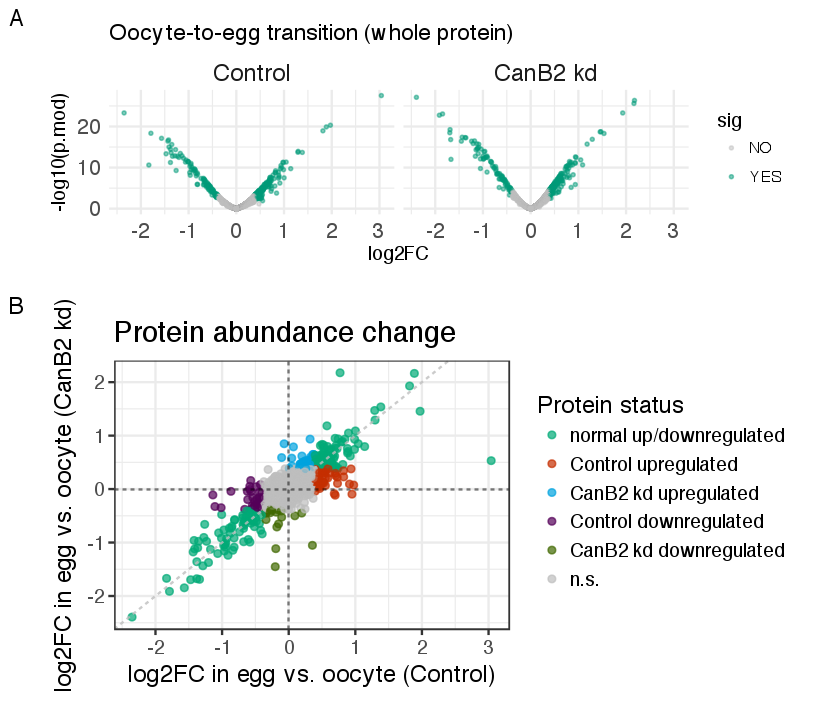

In [99]:
options(repr.plot.width = 7, repr.plot.height = 6)
# pdf("manuscript/Figures/Figure_S5.pdf", width = 7, height = 6)
plot_grid(figS5A, figS5B, labels = c("A", "B"), ncol = 1, scale = c(0.9, 0.9), rel_heights = c(1, 1.5))
# dev.off()

In [100]:
unique(ProToPlot$PROtransition)

[1] n.s.                    normal up/downregulated Control upregulated    
[4] Control downregulated   <NA>                    CanB2 kd upregulated   
[7] CanB2 kd downregulated 
8 Levels: normal up/downregulated Control upregulated ... n.s.

In [101]:
nrow(filter(ProToPlot, PROtransition == "Control downregulated"))

[1] 35

In [102]:
wholeProtein_up_in_control_only = filter(ProToPlot, PROtransition == "Control upregulated")$Accession
unique(subset(annotations, Accession %in% wholeProtein_up_in_control_only)$`Gene Symbol`)

[1] CG1943           Hsp27            Cyt-c-p          CG8507          
  [5] Obp56d           CG2608           Ucrh; UQCR-11    Snap24          
  [9] CG17493          CG6719; mgr      Aps              CG17597         
 [13] Incenp           CG9515           fon              CG31650         
 [17] CG14966          CycB             CG11523          Vago            
 [21] SmD1             CG6013           Pep              CG7668          
 [25] CycH             Tpr2             l(1)G0136; MagR  Orc1            
 [29] CG9117           CG17168          CG12007          key             
 [33] CG8368           CG8180           CG32850          l(1)G0289       
 [37] betaggt-I        CG11781          gro              CG5162          
 [41] CG5510           CG8243           CG8974           fax             
 [45] mRpS2            CG18586          Aut1; Atg3       CG14815; Pex5   
 [49] l(3)04053        fs(2)ltoPP43     Su(var)3-3       CG18292; CDK2AP1
 [53] CG42388; Nost    CG1677           P5cr             fidipidine      
 [57] MrgBP            Taf7             ari-1            CG7564          
 [61] CG7685           CycE             Apc2             HP1b            
 [65] Spt5             mof              SNF4Agamma       Liprin-beta     
 [69] CG9257           AGO3             Spt6             SMSr            
 [73] cdc2rk           pita             CG42672          Su(var)2-HP2    
 [77] SP2637           CG30467          Papss            dah             
 [81] CG31637          CG8931           CG8303           sbb             
 [85] Rb97D            CG3198           CycA             CG6498; dop     
 [89] su(Hw)           BoYb; CG11133    Taf1             CG11859; RIOK2  
 [93] MAPk-Ak2         wech             CG10984          Pfrx            
 [97] Moca-cyp         CG7082; papi     CG32176          bip2            
[101] lgs              cenB1A           tos              CG5098          
[105] milt             CG7029           Tao; Tao-1       CG8677          
4704 Levels:  128up 14-3-3epsilon 14-3-3zeta 140up 26-29-p 312 4EHP A16 ... Zyx

### Phosphopeptides:

Run the lm fit:

In [103]:
lmfit_msa.canB <- lmFit(log2(canB_peptides_msa_abundances.rn), design.sample.canB)
lmfit_msa.canB.cont <- contrasts.fit(lmfit_msa.canB, contrasts.sample.canB)
lmfit_msa.canB.cont.ebayes <- eBayes(lmfit_msa.canB.cont)

In [104]:
lmfit_nl.canB <- lmFit(log2(canB_peptides_nl_abundances.rn), design.sample.canB)
lmfit_nl.canB.cont <- contrasts.fit(lmfit_nl.canB, contrasts.sample.canB)
lmfit_nl.canB.cont.ebayes <- eBayes(lmfit_nl.canB.cont)

Warning message:
“Partial NA coefficients for 1 probe(s)”

In [105]:
lmfit_msa.cnA <- lmFit(log2(cnA_peptides_msa_abundances.rn), design.sample.cnA)
lmfit_msa.cnA.cont <- contrasts.fit(lmfit_msa.cnA, contrasts.sample.cnA)
lmfit_msa.cnA.cont.ebayes <- eBayes(lmfit_msa.cnA.cont)

In [106]:
lmfit_nl.cnA <- lmFit(log2(cnA_peptides_nl_abundances.rn), design.sample.cnA)
lmfit_nl.cnA.cont <- contrasts.fit(lmfit_nl.cnA, contrasts.sample.cnA)
lmfit_nl.cnA.cont.ebayes <- eBayes(lmfit_nl.cnA.cont)

Warning message:
“Partial NA coefficients for 1 probe(s)”

Output and combine the results for the four contrasts for both the MSA and NL data:

##### CanB

In [107]:
msa.eWT_v_oWT_peptides.canB = eb.fit.byCoef(1, lmfit_msa.canB.cont.ebayes, calcIntErr(canB_peptides_msa))
msa.eCB_v_oCB_peptides.canB = eb.fit.byCoef(2, lmfit_msa.canB.cont.ebayes, calcIntErr(canB_peptides_msa))
msa.oCB_v_oWT_peptides.canB = eb.fit.byCoef(3, lmfit_msa.canB.cont.ebayes, calcIntErr(canB_peptides_msa))
msa.eCB_v_eWT_peptides.canB = eb.fit.byCoef(4, lmfit_msa.canB.cont.ebayes, calcIntErr(canB_peptides_msa))
msa.peptides.canB.rbind = rbind(msa.eWT_v_oWT_peptides.canB, msa.eCB_v_oCB_peptides.canB, msa.oCB_v_oWT_peptides.canB, msa.eCB_v_eWT_peptides.canB)

options(repr.plot.width = 6, repr.plot.height = 4)
# ggplot(filter(msa.peptides.canB.rbind, !is.na(sig)), aes(log2FC, -log10(p.mod), colour = sig)) + 
#     geom_point(size = 0.3) + 
#     facet_wrap(~comparison) +
#     labs(title = "Phosphopeptides (CanB MSA samples)")

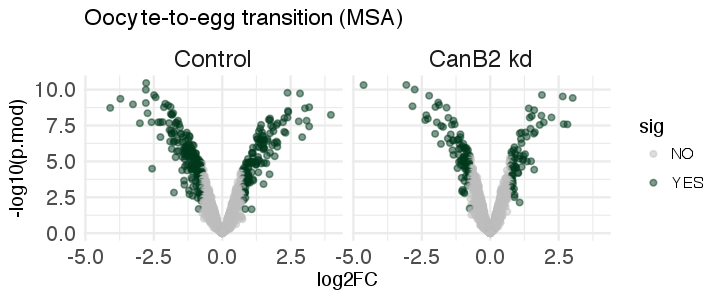

In [108]:
options(repr.plot.width = 6, repr.plot.height = 2.5)

tmpDF1 = filter(msa.peptides.canB.rbind, !is.na(sig) & (comparison == "Egg_WT - Oocyte_WT" | comparison == "Egg_CanB2 - Oocyte_CanB2"))
tmpDF1$comp2 = ifelse(tmpDF1$comparison == "Egg_WT - Oocyte_WT", "Control", "CanB2 kd")
tmpDF1$comp2 = factor(tmpDF1$comp2, levels = c("Control", "CanB2 kd"))

(fig2A = ggplot(tmpDF1, aes(log2FC, -log10(p.mod), colour = sig)) + 
    geom_point(size = 1.2, alpha = 0.5) + 
    facet_wrap(~comp2) +
    labs(title = "Oocyte-to-egg transition (MSA)") +
    scale_colour_manual(values = c("gray","#00391d")) +
    theme_minimal() +
    theme(axis.text = element_text(size = 12), strip.text = element_text(size = 14)))
    

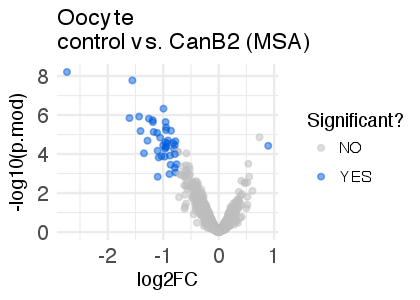

In [109]:
options(repr.plot.width = 3.5, repr.plot.height = 2.5)

canbDF1.msa = filter(msa.peptides.canB.rbind, !is.na(sig) & comparison == "Oocyte_CanB2 - Oocyte_WT")
# tmpDF1$comp2 = ifelse(tmpDF1$comparison == "Egg_WT - Oocyte_WT", "Control", "CanB2")
# tmpDF1$comp2 = factor(tmpDF1$comp2, levels = c("Control", "CanB2"))

(fig4A_left = ggplot(canbDF1.msa, aes(log2FC, -log10(p.mod), colour = sig)) + 
    geom_point(size = 1.2, alpha = 0.5) + 
#     facet_wrap(~comp2) +
    labs(title = "Oocyte\ncontrol vs. CanB2 (MSA)") +
    scale_colour_manual(values = c("gray","#015cdc")) +
    theme_minimal() +
     guides(colour=guide_legend(title="Significant?")) +
#  theme(legend.position = "none") +
    theme(axis.text = element_text(size = 12), strip.text = element_text(size = 14)))
    

In [110]:
nl.eWT_v_oWT_peptides.canB = eb.fit.byCoef(1, lmfit_nl.canB.cont.ebayes, calcIntErr(canB_peptides_nl))
nl.eCB_v_oCB_peptides.canB = eb.fit.byCoef(2, lmfit_nl.canB.cont.ebayes, calcIntErr(canB_peptides_nl))
nl.oCB_v_oWT_peptides.canB = eb.fit.byCoef(3, lmfit_nl.canB.cont.ebayes, calcIntErr(canB_peptides_nl))
nl.eCB_v_eWT_peptides.canB = eb.fit.byCoef(4, lmfit_nl.canB.cont.ebayes, calcIntErr(canB_peptides_nl))
nl.peptides.canB.rbind = rbind(nl.eWT_v_oWT_peptides.canB, nl.eCB_v_oCB_peptides.canB, nl.oCB_v_oWT_peptides.canB, nl.eCB_v_eWT_peptides.canB)

options(repr.plot.width = 6, repr.plot.height = 4)
# ggplot(filter(nl.peptides.canB.rbind, !is.na(sig)), aes(log2FC, -log10(p.mod), colour = sig)) + 
#     geom_point(size = 0.3) + 
#     facet_wrap(~comparison) +
#     labs(title = "Phosphopeptides (CanB NL samples)")

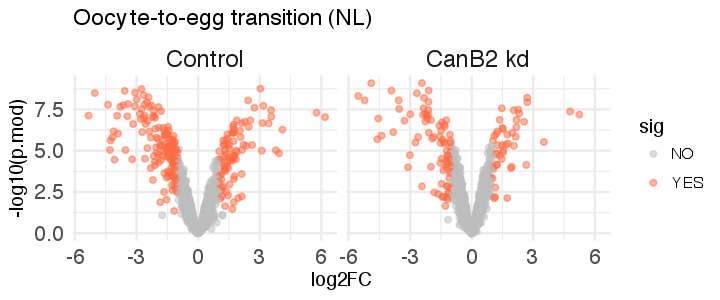

In [111]:
options(repr.plot.width = 6, repr.plot.height = 2.5)

tmpDF1 = filter(nl.peptides.canB.rbind, !is.na(sig) & (comparison == "Egg_WT - Oocyte_WT" | comparison == "Egg_CanB2 - Oocyte_CanB2"))
tmpDF1$comp2 = ifelse(tmpDF1$comparison == "Egg_WT - Oocyte_WT", "Control", "CanB2 kd")
tmpDF1$comp2 = factor(tmpDF1$comp2, levels = c("Control", "CanB2 kd"))

(fig2B = ggplot(tmpDF1, aes(log2FC, -log10(p.mod), colour = sig)) + 
    geom_point(size = 1.2, alpha = 0.5) + 
    facet_wrap(~comp2) +
    labs(title = "Oocyte-to-egg transition (NL)") +
    scale_colour_manual(values = c("gray","#ff6a43")) +
    theme_minimal() +
    theme(axis.text = element_text(size = 12), strip.text = element_text(size = 14)))

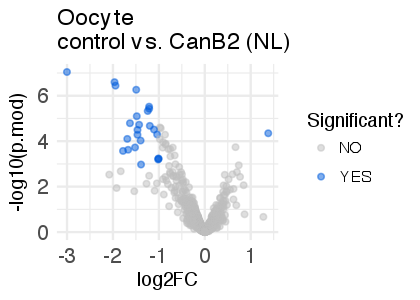

In [112]:
options(repr.plot.width = 3.5, repr.plot.height = 2.5)

canbDF1.nl = filter(nl.peptides.canB.rbind, !is.na(sig) & comparison == "Oocyte_CanB2 - Oocyte_WT")
# tmpDF1$comp2 = ifelse(tmpDF1$comparison == "Egg_WT - Oocyte_WT", "Control", "CanB2")
# tmpDF1$comp2 = factor(tmpDF1$comp2, levels = c("Control", "CanB2"))

(fig4A_right = ggplot(canbDF1.nl, aes(log2FC, -log10(p.mod), colour = sig)) + 
    geom_point(size = 1.2, alpha = 0.5) + 
#     facet_wrap(~comp2) +
    labs(title = "Oocyte\ncontrol vs. CanB2 (NL)") +
    scale_colour_manual(values = c("gray","#015cdc")) +
    theme_minimal() +
 guides(colour=guide_legend(title="Significant?")) +
#  theme(legend.position = "none") +
    theme(axis.text = element_text(size = 12), strip.text = element_text(size = 14)))
    

In [113]:
options(repr.plot.width = 6, repr.plot.height = 2.5)
fig4A = plot_grid(fig4A_left, fig4A_right, labels = c("A", ""), scale = c(0.9, 0.9))

##### CnAact:

In [114]:
msa.eWT_v_oWT_peptides.cnA = eb.fit.byCoef(1, lmfit_msa.cnA.cont.ebayes, calcIntErr(cnA_peptides_msa))
msa.eCB_v_oCB_peptides.cnA = eb.fit.byCoef(2, lmfit_msa.cnA.cont.ebayes, calcIntErr(cnA_peptides_msa))
msa.oCB_v_oWT_peptides.cnA = eb.fit.byCoef(3, lmfit_msa.cnA.cont.ebayes, calcIntErr(cnA_peptides_msa))
msa.eCB_v_eWT_peptides.cnA = eb.fit.byCoef(4, lmfit_msa.cnA.cont.ebayes, calcIntErr(cnA_peptides_msa))
msa.peptides.cnA.rbind = rbind(msa.eWT_v_oWT_peptides.cnA, msa.eCB_v_oCB_peptides.cnA, msa.oCB_v_oWT_peptides.cnA, msa.eCB_v_eWT_peptides.cnA)

options(repr.plot.width = 6, repr.plot.height = 4)
# ggplot(filter(msa.peptides.cnA.rbind, !is.na(sig)), aes(log2FC, -log10(p.mod), colour = sig)) + 
#     geom_point(size = 0.3) + 
#     facet_wrap(~comparison) +
#     labs(title = "Phosphopeptides (CnAact MSA samples)")

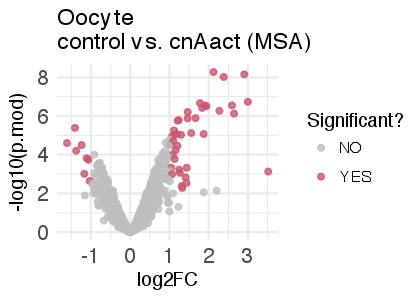

In [115]:
options(repr.plot.width = 3.5, repr.plot.height = 2.5)

canbDF1.msa = filter(msa.peptides.cnA.rbind, !is.na(sig) & comparison == "Oocyte_CnAact - Oocyte_WT")
# tmpDF1$comp2 = ifelse(tmpDF1$comparison == "Egg_WT - Oocyte_WT", "Control", "cnAact")
# tmpDF1$comp2 = factor(tmpDF1$comp2, levels = c("Control", "cnAact"))

(fig4C_left = ggplot(canbDF1.msa, aes(log2FC, -log10(p.mod), colour = sig)) + 
    geom_point(size = 1.2, alpha = 0.8) + 
#     facet_wrap(~comp2) +
    labs(title = "Oocyte\ncontrol vs. cnAact (MSA)") +
    scale_colour_manual(values = c("gray","#ca5670")) +
    theme_minimal() +
#  theme(legend.position = "none") +
 guides(colour=guide_legend(title="Significant?")) +
    theme(axis.text = element_text(size = 12), strip.text = element_text(size = 14)))
    

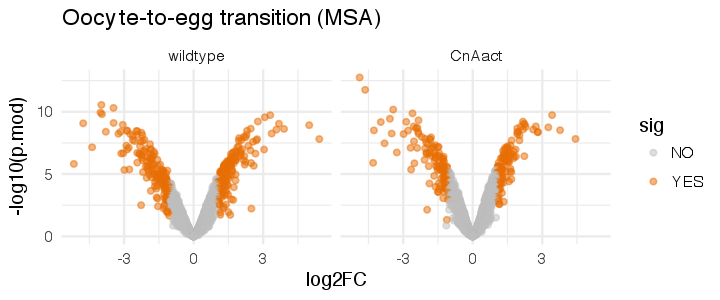

In [116]:
options(repr.plot.width = 6, repr.plot.height = 2.5)

tmpDF1 = filter(msa.peptides.cnA.rbind, !is.na(sig) & (comparison == "Egg_WT - Oocyte_WT" | comparison == "Egg_CnAact - Oocyte_CnAact"))
tmpDF1$comp2 = ifelse(tmpDF1$comparison == "Egg_WT - Oocyte_WT", "wildtype", "CnAact")
tmpDF1$comp2 = factor(tmpDF1$comp2, levels = c("wildtype", "CnAact"))

ggplot(tmpDF1, aes(log2FC, -log10(p.mod), colour = sig)) + 
    geom_point(size = 1.2, alpha = 0.5) + 
    facet_wrap(~comp2) +
    labs(title = "Oocyte-to-egg transition (MSA)") +
    scale_colour_manual(values = c("gray","#e86e04")) +
    theme_minimal()

In [117]:
nl.eWT_v_oWT_peptides.cnA = eb.fit.byCoef(1, lmfit_nl.cnA.cont.ebayes, calcIntErr(cnA_peptides_nl))
nl.eCB_v_oCB_peptides.cnA = eb.fit.byCoef(2, lmfit_nl.cnA.cont.ebayes, calcIntErr(cnA_peptides_nl))
nl.oCB_v_oWT_peptides.cnA = eb.fit.byCoef(3, lmfit_nl.cnA.cont.ebayes, calcIntErr(cnA_peptides_nl))
nl.eCB_v_eWT_peptides.cnA = eb.fit.byCoef(4, lmfit_nl.cnA.cont.ebayes, calcIntErr(cnA_peptides_nl))
nl.peptides.cnA.rbind = rbind(nl.eWT_v_oWT_peptides.cnA, nl.eCB_v_oCB_peptides.cnA, nl.oCB_v_oWT_peptides.cnA, nl.eCB_v_eWT_peptides.cnA)

options(repr.plot.width = 6, repr.plot.height = 4)
# ggplot(filter(nl.peptides.cnA.rbind, !is.na(sig)), aes(log2FC, -log10(p.mod), colour = sig)) + 
#     geom_point(size = 0.3) + 
#     facet_wrap(~comparison) +
#     labs(title = "Phosphopeptides (CnAact NL samples)")

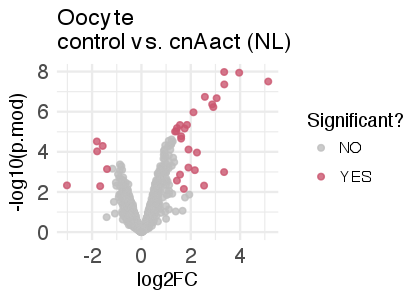

In [118]:
options(repr.plot.width = 3.5, repr.plot.height = 2.5)

canbDF1.nl = filter(nl.peptides.cnA.rbind, !is.na(sig) & comparison == "Oocyte_CnAact - Oocyte_WT")
# tmpDF1$comp2 = ifelse(tmpDF1$comparison == "Egg_WT - Oocyte_WT", "Control", "cnAact")
# tmpDF1$comp2 = factor(tmpDF1$comp2, levels = c("Control", "cnAact"))

(fig4C_right = ggplot(canbDF1.nl, aes(log2FC, -log10(p.mod), colour = sig)) + 
    geom_point(size = 1.2, alpha = 0.8) + 
#     facet_wrap(~comp2) +
    labs(title = "Oocyte\ncontrol vs. cnAact (NL)") +
    scale_colour_manual(values = c("gray","#ca5670")) +
    theme_minimal() +
#  theme(legend.position = "none") +
     guides(colour=guide_legend(title="Significant?")) +
    theme(axis.text = element_text(size = 12), strip.text = element_text(size = 14)))
    

In [119]:
options(repr.plot.width = 6, repr.plot.height = 2.5)
fig4C = plot_grid(fig4C_left, fig4C_right, scale = c(0.9, 0.9))

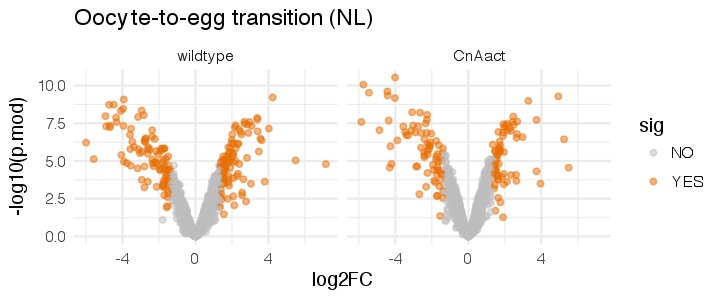

In [120]:
options(repr.plot.width = 6, repr.plot.height = 2.5)

tmpDF1 = filter(nl.peptides.cnA.rbind, !is.na(sig) & (comparison == "Egg_WT - Oocyte_WT" | comparison == "Egg_CnAact - Oocyte_CnAact"))
tmpDF1$comp2 = ifelse(tmpDF1$comparison == "Egg_WT - Oocyte_WT", "wildtype", "CnAact")
tmpDF1$comp2 = factor(tmpDF1$comp2, levels = c("wildtype", "CnAact"))

ggplot(tmpDF1, aes(log2FC, -log10(p.mod), colour = sig)) + 
    geom_point(size = 1.2, alpha = 0.5) + 
    facet_wrap(~comp2) +
    labs(title = "Oocyte-to-egg transition (NL)") +
    scale_colour_manual(values = c("gray","#e86e04")) +
    theme_minimal()

change the column names so that they're unique when combined with other data later:

##### CanB2:

In [121]:
colnames(msa.eWT_v_oWT_peptides.canB) = gsub( "^", "peptides.msa.eWT_v_oWT_", colnames(msa.eWT_v_oWT_peptides.canB))
colnames(msa.eWT_v_oWT_peptides.canB) = gsub( ".*Accession", "peptide_id", colnames(msa.eWT_v_oWT_peptides.canB))
msa.eWT_v_oWT.canB = merge(IDs.canB_msa_peptides, msa.eWT_v_oWT_peptides.canB)

colnames(msa.eCB_v_oCB_peptides.canB) = gsub( "^", "peptides.msa.eCB_v_oCB_", colnames(msa.eCB_v_oCB_peptides.canB))
colnames(msa.eCB_v_oCB_peptides.canB) = gsub( ".*Accession", "peptide_id", colnames(msa.eCB_v_oCB_peptides.canB))
msa.eCB_v_oCB.canB = merge(IDs.canB_msa_peptides, msa.eCB_v_oCB_peptides.canB)

colnames(msa.oCB_v_oWT_peptides.canB) = gsub( "^", "peptides.msa.oCB_v_oWT_", colnames(msa.oCB_v_oWT_peptides.canB))
colnames(msa.oCB_v_oWT_peptides.canB) = gsub( ".*Accession", "peptide_id", colnames(msa.oCB_v_oWT_peptides.canB))
msa.oCB_v_oWT.canB = merge(IDs.canB_msa_peptides, msa.oCB_v_oWT_peptides.canB)

colnames(msa.eCB_v_eWT_peptides.canB) = gsub( "^", "peptides.msa.eCB_v_eWT_", colnames(msa.eCB_v_eWT_peptides.canB))
colnames(msa.eCB_v_eWT_peptides.canB) = gsub( ".*Accession", "peptide_id", colnames(msa.eCB_v_eWT_peptides.canB))
msa.eCB_v_eWT.canB = merge(IDs.canB_msa_peptides, msa.eCB_v_eWT_peptides.canB)

In [122]:
colnames(nl.eWT_v_oWT_peptides.canB) = gsub( "^", "peptides.nl.eWT_v_oWT_", colnames(nl.eWT_v_oWT_peptides.canB))
colnames(nl.eWT_v_oWT_peptides.canB) = gsub( ".*Accession", "peptide_id", colnames(nl.eWT_v_oWT_peptides.canB))
nl.eWT_v_oWT.canB = merge(IDs.canB_nl_peptides, nl.eWT_v_oWT_peptides.canB)

colnames(nl.eCB_v_oCB_peptides.canB) = gsub( "^", "peptides.nl.eCB_v_oCB_", colnames(nl.eCB_v_oCB_peptides.canB))
colnames(nl.eCB_v_oCB_peptides.canB) = gsub( ".*Accession", "peptide_id", colnames(nl.eCB_v_oCB_peptides.canB))
nl.eCB_v_oCB.canB = merge(IDs.canB_nl_peptides, nl.eCB_v_oCB_peptides.canB)

colnames(nl.oCB_v_oWT_peptides.canB) = gsub( "^", "peptides.nl.oCB_v_oWT_", colnames(nl.oCB_v_oWT_peptides.canB))
colnames(nl.oCB_v_oWT_peptides.canB) = gsub( ".*Accession", "peptide_id", colnames(nl.oCB_v_oWT_peptides.canB))
nl.oCB_v_oWT.canB = merge(IDs.canB_nl_peptides, nl.oCB_v_oWT_peptides.canB)

colnames(nl.eCB_v_eWT_peptides.canB) = gsub( "^", "peptides.nl.eCB_v_eWT_", colnames(nl.eCB_v_eWT_peptides.canB))
colnames(nl.eCB_v_eWT_peptides.canB) = gsub( ".*Accession", "peptide_id", colnames(nl.eCB_v_eWT_peptides.canB))
nl.eCB_v_eWT.canB = merge(IDs.canB_nl_peptides, nl.eCB_v_eWT_peptides.canB)

In [123]:
oocyte_canB_v_control_sigProteins = union(filter(msa.oCB_v_oWT.canB, peptides.msa.oCB_v_oWT_sig == "YES")$Accession, filter(nl.oCB_v_oWT.canB, peptides.nl.oCB_v_oWT_sig == "YES")$Accession)
write.table(oocyte_canB_v_control_sigProteins, "Results/Oocyte_canB_v_control_sigPhproteins.txt", quote = F, row.names = F, col.names = F)

Output a list of significant phosphopeptides for the CanB results in both MSA and NL runs:

In [124]:
msa.eWT_v_oWT.canB.sigPeptides.up = unique(filter(msa.eWT_v_oWT.canB, peptides.msa.eWT_v_oWT_sig == "YES" & peptides.msa.eWT_v_oWT_log2FC > 0)$peptide)
nl.eWT_v_oWT.canB.sigPeptides.up = unique(filter(nl.eWT_v_oWT.canB, peptides.nl.eWT_v_oWT_sig == "YES" & peptides.nl.eWT_v_oWT_log2FC > 0)$peptide)

msa.eWT_v_oWT.canB.sigPeptides.down = unique(filter(msa.eWT_v_oWT.canB, peptides.msa.eWT_v_oWT_sig == "YES" & peptides.msa.eWT_v_oWT_log2FC < 0)$peptide)
nl.eWT_v_oWT.canB.sigPeptides.down = unique(filter(nl.eWT_v_oWT.canB, peptides.nl.eWT_v_oWT_sig == "YES" & peptides.nl.eWT_v_oWT_log2FC < 0)$peptide)

Warning message in as.POSIXlt.POSIXct(x, tz):
“unknown timezone 'zone/tz/2018f.1.0/zoneinfo/America/New_York'”

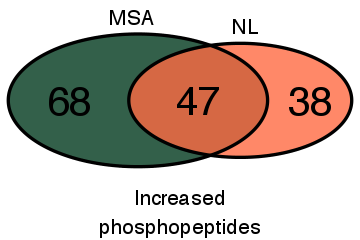

In [125]:
eWT_v_oWT.sigPeptides.up <- list(MSA = msa.eWT_v_oWT.canB.sigPeptides.up, NL = nl.eWT_v_oWT.canB.sigPeptides.up)

eWT_v_oWT.sigPeptides.up_Vdiag<-venn.diagram(eWT_v_oWT.sigPeptides.up, NULL, fill=c("#00391d", "#ff6a43"), alpha=c(0.8,0.8), cex = 2, cat.fontface= 1, cat.dist = c(0.05, 0.05), cat.cex = 1, cat.pos = c(-2,2), resolution = 1000)

# eWT_v_oWT.sigPeptides_combs <- unlist(lapply(1:length(eWT_v_oWT.sigPeptides), function(j) combn(names(eWT_v_oWT.sigPeptides), j, simplify = FALSE)), recursive = FALSE)
# names(eWT_v_oWT.sigPeptides_combs) <- sapply(eWT_v_oWT.sigPeptides_combs, function(i) paste0(i, collapse = ","))
    
# eWT_v_oWT.sigPeptides_elements <- lapply(eWT_v_oWT.sigPeptides_combs, function(i) Setdiff(eWT_v_oWT.sigPeptides[i], eWT_v_oWT.sigPeptides[setdiff(names(eWT_v_oWT.sigPeptides), i)]))
    
options(repr.plot.width = 3, repr.plot.height = 2)
Inc_phospep.venn = grid.arrange(gTree(children=eWT_v_oWT.sigPeptides.up_Vdiag), bottom = "Increased\nphosphopeptides")

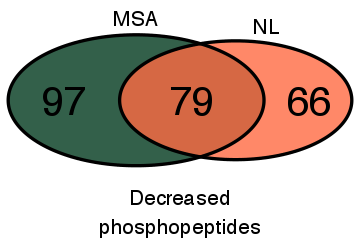

In [126]:
eWT_v_oWT.sigPeptides.down <- list(MSA = msa.eWT_v_oWT.canB.sigPeptides.down, NL = nl.eWT_v_oWT.canB.sigPeptides.down)

eWT_v_oWT.sigPeptides.down_Vdiag<-venn.diagram(eWT_v_oWT.sigPeptides.down, NULL, fill=c("#00391d", "#ff6a43"), alpha=c(0.8,0.8), cex = 2, cat.fontface= 6, cat.dist = c(0.05, 0.05), cat.cex =1, cat.pos = c(0,12), resolution = 1000)

# eWT_v_oWT.sigPeptides_combs <- unlist(lapply(1:length(eWT_v_oWT.sigPeptides), function(j) combn(names(eWT_v_oWT.sigPeptides), j, simplify = FALSE)), recursive = FALSE)
# names(eWT_v_oWT.sigPeptides_combs) <- sapply(eWT_v_oWT.sigPeptides_combs, function(i) paste0(i, collapse = ","))
    
# eWT_v_oWT.sigPeptides_elements <- lapply(eWT_v_oWT.sigPeptides_combs, function(i) Setdiff(eWT_v_oWT.sigPeptides[i], eWT_v_oWT.sigPeptides[setdiff(names(eWT_v_oWT.sigPeptides), i)]))
    
options(repr.plot.width = 3, repr.plot.height = 2)
Dec_phospep.venn = grid.arrange(gTree(children=eWT_v_oWT.sigPeptides.down_Vdiag), bottom = "Decreased\nphosphopeptides")

In [127]:
fig2C = plot_grid(Inc_phospep.venn, Dec_phospep.venn, ncol = 2, scale = c(0.7, 0.7))

##### CnAact:

In [128]:
colnames(msa.eWT_v_oWT_peptides.cnA) = gsub( "^", "peptides.msa.eWT_v_oWT_", colnames(msa.eWT_v_oWT_peptides.cnA))
colnames(msa.eWT_v_oWT_peptides.cnA) = gsub( ".*Accession", "peptide_id", colnames(msa.eWT_v_oWT_peptides.cnA))
msa.eWT_v_oWT.cnA = merge(IDs.cnA_msa_peptides, msa.eWT_v_oWT_peptides.cnA)

colnames(msa.eCB_v_oCB_peptides.cnA) = gsub( "^", "peptides.msa.eCB_v_oCB_", colnames(msa.eCB_v_oCB_peptides.cnA))
colnames(msa.eCB_v_oCB_peptides.cnA) = gsub( ".*Accession", "peptide_id", colnames(msa.eCB_v_oCB_peptides.cnA))
msa.eCB_v_oCB.cnA = merge(IDs.cnA_msa_peptides, msa.eCB_v_oCB_peptides.cnA)

colnames(msa.oCB_v_oWT_peptides.cnA) = gsub( "^", "peptides.msa.oCB_v_oWT_", colnames(msa.oCB_v_oWT_peptides.cnA))
colnames(msa.oCB_v_oWT_peptides.cnA) = gsub( ".*Accession", "peptide_id", colnames(msa.oCB_v_oWT_peptides.cnA))
msa.oCB_v_oWT.cnA = merge(IDs.cnA_msa_peptides, msa.oCB_v_oWT_peptides.cnA)

colnames(msa.eCB_v_eWT_peptides.cnA) = gsub( "^", "peptides.msa.eCB_v_eWT_", colnames(msa.eCB_v_eWT_peptides.cnA))
colnames(msa.eCB_v_eWT_peptides.cnA) = gsub( ".*Accession", "peptide_id", colnames(msa.eCB_v_eWT_peptides.cnA))
msa.eCB_v_eWT.cnA = merge(IDs.cnA_msa_peptides, msa.eCB_v_eWT_peptides.cnA)

In [129]:
colnames(nl.eWT_v_oWT_peptides.cnA) = gsub( "^", "peptides.nl.eWT_v_oWT_", colnames(nl.eWT_v_oWT_peptides.cnA))
colnames(nl.eWT_v_oWT_peptides.cnA) = gsub( ".*Accession", "peptide_id", colnames(nl.eWT_v_oWT_peptides.cnA))
nl.eWT_v_oWT.cnA = merge(IDs.cnA_nl_peptides, nl.eWT_v_oWT_peptides.cnA)

colnames(nl.eCB_v_oCB_peptides.cnA) = gsub( "^", "peptides.nl.eCB_v_oCB_", colnames(nl.eCB_v_oCB_peptides.cnA))
colnames(nl.eCB_v_oCB_peptides.cnA) = gsub( ".*Accession", "peptide_id", colnames(nl.eCB_v_oCB_peptides.cnA))
nl.eCB_v_oCB.cnA = merge(IDs.cnA_nl_peptides, nl.eCB_v_oCB_peptides.cnA)

colnames(nl.oCB_v_oWT_peptides.cnA) = gsub( "^", "peptides.nl.oCB_v_oWT_", colnames(nl.oCB_v_oWT_peptides.cnA))
colnames(nl.oCB_v_oWT_peptides.cnA) = gsub( ".*Accession", "peptide_id", colnames(nl.oCB_v_oWT_peptides.cnA))
nl.oCB_v_oWT.cnA = merge(IDs.cnA_nl_peptides, nl.oCB_v_oWT_peptides.cnA)

colnames(nl.eCB_v_eWT_peptides.cnA) = gsub( "^", "peptides.nl.eCB_v_eWT_", colnames(nl.eCB_v_eWT_peptides.cnA))
colnames(nl.eCB_v_eWT_peptides.cnA) = gsub( ".*Accession", "peptide_id", colnames(nl.eCB_v_eWT_peptides.cnA))
nl.eCB_v_eWT.cnA = merge(IDs.cnA_nl_peptides, nl.eCB_v_eWT_peptides.cnA)

Combine all the peptide results for the two platforms (MSA and NL), then combine each with the whole protein data:

##### CanB2:

First create a subset of the protein data:

In [130]:
protein_sub_data = results.eb_proteins_with_annots %>%
        select(matches('Accession|wholeProteins'))

In [131]:
msa.canB.peps = merge(msa.eWT_v_oWT.canB, merge(msa.eCB_v_oCB.canB, merge(msa.oCB_v_oWT.canB, msa.eCB_v_eWT.canB)))

nl.canB.peps = merge(nl.eWT_v_oWT.canB, merge(nl.eCB_v_oCB.canB, merge(nl.oCB_v_oWT.canB, nl.eCB_v_eWT.canB)))

msa.canB.peps.comb = merge(msa.canB.peps, protein_sub_data, by.x = "Accession",by.y = "Accession", all.x = T)
nl.canB.peps.comb = merge(nl.canB.peps, protein_sub_data, by.x = "Accession",by.y = "Accession", all.x = T)

##### CnAact:

In [132]:
msa.cnA.peps = merge(msa.eWT_v_oWT.cnA, merge(msa.eCB_v_oCB.cnA, merge(msa.oCB_v_oWT.cnA, msa.eCB_v_eWT.cnA)))

nl.cnA.peps = merge(nl.eWT_v_oWT.cnA, merge(nl.eCB_v_oCB.cnA, merge(nl.oCB_v_oWT.cnA, nl.eCB_v_eWT.cnA)))

msa.cnA.peps.comb = merge(msa.cnA.peps, protein_sub_data, by.x = "Accession",by.y = "Accession", all.x = T)
nl.cnA.peps.comb = merge(nl.cnA.peps, protein_sub_data, by.x = "Accession",by.y = "Accession", all.x = T)

Example addition of a coulmn for peptide vs. protein comparison:

### CanB2:

In [133]:
msa.canB.peps.comb$oWT_v_eWT_status = ifelse(msa.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" & msa.canB.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES", 
                                             "Both", 
                                             ifelse(msa.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" & msa.canB.peps.comb$peptides.msa.eWT_v_oWT_sig == "NO", 
                                                    "Protein", 
                                                    ifelse(msa.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "NO" & msa.canB.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES", 
                                                           "Phosphopeptides", 
                                                           "none")))

# msa.canB.peps.comb$oWT_v_eWT_status = factor(msa.canB.peps.comb$oWT_v_eWT_status, levels = c())

In [134]:
msa.canB.peps.comb$oCB_v_eCB_status = ifelse(msa.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" & msa.canB.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES", 
                                             "Both", 
                                             ifelse(msa.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" & msa.canB.peps.comb$peptides.msa.eCB_v_oCB_sig == "NO", 
                                                    "Protein", 
                                                    ifelse(msa.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "NO" & msa.canB.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES", 
                                                           "Phosphopeptides", 
                                                           "none")))

# msa.canB.peps.comb$oCB_v_eCB_status = factor(msa.canB.peps.comb$oCB_v_eCB_status, levels = c())

In [135]:
nl.canB.peps.comb$oWT_v_eWT_status = ifelse(nl.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" & nl.canB.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES", 
                                             "Both", 
                                             ifelse(nl.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" & nl.canB.peps.comb$peptides.nl.eWT_v_oWT_sig == "NO", 
                                                    "Protein", 
                                                    ifelse(nl.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "NO" & nl.canB.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES", 
                                                           "Phosphopeptides", 
                                                           "none")))

# nl.canB.peps.comb$oWT_v_eWT_status = factor(nl.canB.peps.comb$oWT_v_eWT_status, levels = c())

In [136]:
nl.canB.peps.comb$oCB_v_eCB_status = ifelse(nl.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" & nl.canB.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES", 
                                             "Both", 
                                             ifelse(nl.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" & nl.canB.peps.comb$peptides.nl.eCB_v_oCB_sig == "NO", 
                                                    "Protein", 
                                                    ifelse(nl.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "NO" & nl.canB.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES", 
                                                           "Phosphopeptides", 
                                                           "none")))

# nl.canB.peps.comb$oCB_v_eCB_status = factor(nl.canB.peps.comb$oCB_v_eCB_status, levels = c())

Let's combine those two tables ina  seamless way:

In [137]:
msa.wt.pep_v_prot = select(msa.canB.peps.comb, Accession, peptide_id, peptide, peptide_logFC = peptides.msa.eWT_v_oWT_log2FC, protein_logFC = wholeProteins.eWT_v_oWT_log2FC, sig_status = oWT_v_eWT_status)
msa.wt.pep_v_prot$samples = "control"
msa.wt.pep_v_prot$method = "MSA"

msa.canB.pep_v_prot = select(msa.canB.peps.comb, Accession, peptide_id, peptide, peptide_logFC = peptides.msa.eCB_v_oCB_log2FC, protein_logFC = wholeProteins.eCB_v_oCB_log2FC, sig_status = oCB_v_eCB_status)
msa.canB.pep_v_prot$samples = "CanB2"
msa.canB.pep_v_prot$method = "MSA"

nl.wt.pep_v_prot = select(nl.canB.peps.comb, Accession, peptide_id, peptide, peptide_logFC = peptides.nl.eWT_v_oWT_log2FC, protein_logFC = wholeProteins.eWT_v_oWT_log2FC, sig_status = oWT_v_eWT_status)
nl.wt.pep_v_prot$samples = "control"
nl.wt.pep_v_prot$method = "NL"

nl.canB.pep_v_prot = select(nl.canB.peps.comb, Accession, peptide_id, peptide, peptide_logFC = peptides.nl.eCB_v_oCB_log2FC, protein_logFC = wholeProteins.eCB_v_oCB_log2FC, sig_status = oCB_v_eCB_status)
nl.canB.pep_v_prot$samples = "CanB2"
nl.canB.pep_v_prot$method = "NL"

Combine and set the factor order:

In [138]:
canB.pep_v_prot = rbind(msa.wt.pep_v_prot, msa.canB.pep_v_prot, nl.wt.pep_v_prot, nl.canB.pep_v_prot)
canB.pep_v_prot$sig_status = factor(canB.pep_v_prot$sig_status, levels = c('Both', 'Protein', 'Phosphopeptides', 'none'))
head(canB.pep_v_prot, n = 2)

Accession 
1 A0A0B4JD97
2 A0A0B4JD97
  peptide_id                                                                                                          
1 A0A0B4JD97.K..GNTTTASLPEPTSPSFPIKEPAEK..Q.2xTMT6plex..K19..K24...1xTMT6plex..N.Term...1xPhospho..T.S.               
2 A0A0B4JD97.K..MTEIELPVESVPSASLSPPTPALQAK..I.1xOxidation..M1...1xTMT6plex..K26...1xTMT6plex..N.Term...1xPhospho..S.T.
  peptide                            peptide_logFC protein_logFC sig_status
1 [K].GNTTTASLPEPTSPSFPIKEPAEK.[Q]   0.1141748     NA            NA        
2 [K].MTEIELPVESVPSASLSPPTPALQAK.[I] 0.4997513     NA            NA        
  samples method
1 control MSA   
2 control MSA

Now plot it:

In [139]:
subset(canB.pep_v_prot, is.na(peptide))

Accession peptide_id peptide peptide_logFC protein_logFC sig_status
     samples method

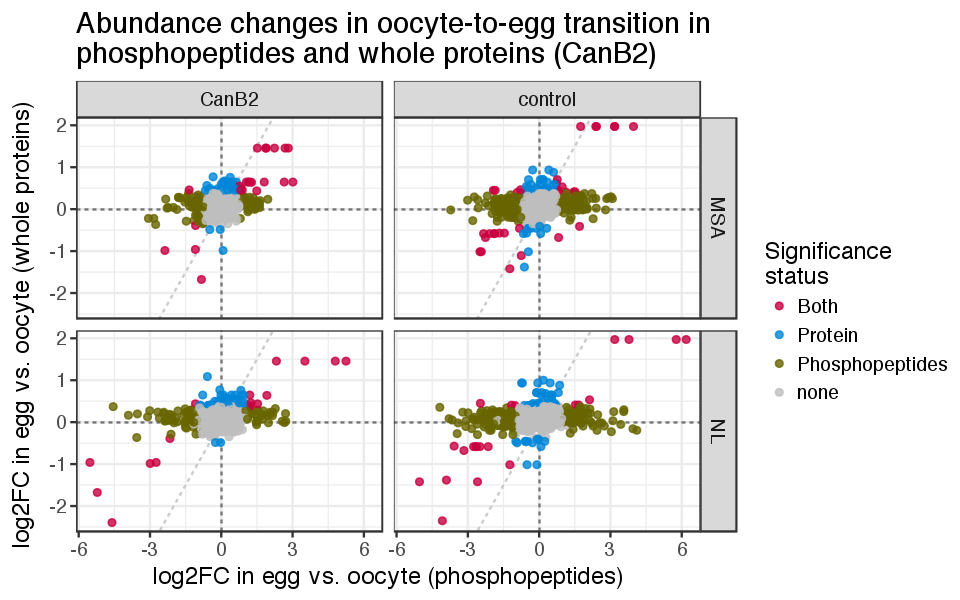

In [140]:
options(repr.plot.width = 8, repr.plot.height = 5)
# pdf("manuscript/revisions/Figure_CanB2_phosphpeptide_v_protein_logFC.pdf", width = 8, height = 5)
ggplot(filter(canB.pep_v_prot, !is.na(sig_status)), aes(peptide_logFC, protein_logFC, colour = sig_status)) + 
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
    geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
    geom_point(alpha = 0.8) +
    facet_grid(method~samples) +
    scale_colour_manual(values = c("#c80040","#0086d8","#686500","grey")) +
    labs(title = "Abundance changes in oocyte-to-egg transition in\nphosphopeptides and whole proteins (CanB2)", x = "log2FC in egg vs. oocyte (phosphopeptides)", y = "log2FC in egg vs. oocyte (whole proteins)") +
    guides(colour=guide_legend(title="Significance\nstatus"))
# dev.off()

Let's make a histogram of the number of the frequency of peptides derived from a given protein:

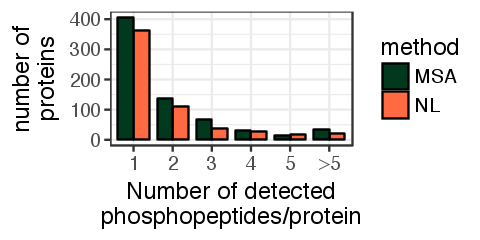

In [141]:
tmpDF.msa = filter(canB.pep_v_prot, method == "MSA")
tmpDF.msa = unique(select(tmpDF.msa, Accession, peptide))
tmpDF.msa = as.data.frame(table(tmpDF.msa$Accession))
tmpDF.msa$count = ifelse(tmpDF.msa$Freq < 6, tmpDF.msa$Freq, ">5")
tmpDF.msa = subset(tmpDF.msa, Freq != "0")
tmpDF.msa = as.data.frame(table(tmpDF.msa$count))
tmpDF.msa$method = "MSA"


tmpDF.nl = filter(canB.pep_v_prot, method == "NL")
tmpDF.nl = unique(select(tmpDF.nl, Accession, peptide))
tmpDF.nl = as.data.frame(table(tmpDF.nl$Accession))
tmpDF.nl$count = ifelse(tmpDF.nl$Freq < 6, tmpDF.nl$Freq, ">5")
tmpDF.nl = subset(tmpDF.nl, Freq != "0")
tmpDF.nl = as.data.frame(table(tmpDF.nl$count))
tmpDF.nl$method = "NL"

tmpDF = rbind(tmpDF.msa, tmpDF.nl)

tmpDF$Var1 = factor(tmpDF$Var1, levels = c(seq(0,5,1), ">5"))

options(repr.plot.width = 4, repr.plot.height = 2)
# pdf("manuscript/revisions/phosphopep_protein_histogram.pdf", height = 2, width = 4)
ggplot(tmpDF, aes(Var1, Freq, fill = method)) + 
    geom_bar(stat = "identity", position = "dodge", width = 0.8, colour = "black") +
#     geom_histogram(breaks=c(seq(0, 10, by=1), max(10)), position = "identity") +
    scale_fill_manual(values = c("#00391d", "#ff6a43")) +
    labs(x = "Number of detected\nphosphopeptides/protein", y = "number of\nproteins")
# dev.off()
rm(tmpDF)

Now let's make a plot representing the number of modifications that relate to each peptide:

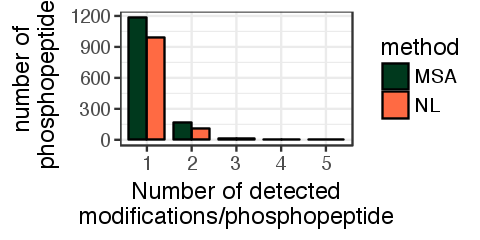

In [142]:
tmpDF.msa = filter(canB.pep_v_prot, method == "MSA")
tmpDF.msa = unique(select(tmpDF.msa, peptide, peptide_id))
tmpDF.msa = as.data.frame(table(tmpDF.msa$peptide))
tmpDF.msa$count = ifelse(tmpDF.msa$Freq < 6, tmpDF.msa$Freq, ">5")
tmpDF.msa = subset(tmpDF.msa, Freq != "0")
tmpDF.msa = as.data.frame(table(tmpDF.msa$count))
tmpDF.msa$method = "MSA"


tmpDF.nl = filter(canB.pep_v_prot, method == "NL")
tmpDF.nl = unique(select(tmpDF.nl, peptide, peptide_id))
tmpDF.nl = as.data.frame(table(tmpDF.nl$peptide))
tmpDF.nl$count = ifelse(tmpDF.nl$Freq < 6, tmpDF.nl$Freq, ">5")
tmpDF.nl = subset(tmpDF.nl, Freq != "0")
tmpDF.nl = as.data.frame(table(tmpDF.nl$count))
tmpDF.nl$method = "NL"

tmpDF = rbind(tmpDF.msa, tmpDF.nl)

tmpDF$Var1 = factor(tmpDF$Var1, levels = c(seq(0,5,1), ">5"))

options(repr.plot.width = 4, repr.plot.height = 2)
ggplot(tmpDF, aes(Var1, Freq, fill = method)) + 
    geom_bar(stat = "identity", position = "dodge", width = 0.8, colour = "black") +
#     geom_histogram(breaks=c(seq(0, 10, by=1), max(10)), position = "identity") +
    scale_fill_manual(values = c("#00391d", "#ff6a43")) +
    labs(x = "Number of detected\nmodifications/phosphopeptide", y = "number of\nphosphopeptides")

rm(tmpDF)

### CnAact:

In [143]:
msa.cnA.peps.comb$oWT_v_eWT_status = ifelse(msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" & msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES", 
                                             "Both", 
                                             ifelse(msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" & msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_sig == "NO", 
                                                    "Protein", 
                                                    ifelse(msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "NO" & msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES", 
                                                           "Phosphopeptides", 
                                                           "none")))

# msa.cnA.peps.comb$oWT_v_eWT_status = factor(msa.cnA.peps.comb$oWT_v_eWT_status, levels = c())

In [144]:
msa.cnA.peps.comb$oCB_v_eCB_status = ifelse(msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" & msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES", 
                                             "Both", 
                                             ifelse(msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" & msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_sig == "NO", 
                                                    "Protein", 
                                                    ifelse(msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "NO" & msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES", 
                                                           "Phosphopeptides", 
                                                           "none")))

# msa.cnA.peps.comb$oCB_v_eCB_status = factor(msa.cnA.peps.comb$oCB_v_eCB_status, levels = c())

In [145]:
nl.cnA.peps.comb$oWT_v_eWT_status = ifelse(nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" & nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES", 
                                             "Both", 
                                             ifelse(nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" & nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_sig == "NO", 
                                                    "Protein", 
                                                    ifelse(nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "NO" & nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES", 
                                                           "Phosphopeptides", 
                                                           "none")))

# nl.cnA.peps.comb$oWT_v_eWT_status = factor(nl.cnA.peps.comb$oWT_v_eWT_status, levels = c())

In [146]:
nl.cnA.peps.comb$oCB_v_eCB_status = ifelse(nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" & nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES", 
                                             "Both", 
                                             ifelse(nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" & nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_sig == "NO", 
                                                    "Protein", 
                                                    ifelse(nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "NO" & nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES", 
                                                           "Phosphopeptides", 
                                                           "none")))

# nl.cnA.peps.comb$oCB_v_eCB_status = factor(nl.cnA.peps.comb$oCB_v_eCB_status, levels = c())

Let's combine those two tables ina  seamless way:

In [147]:
msa.wt.pep_v_prot = select(msa.cnA.peps.comb, peptide_logFC = peptides.msa.eWT_v_oWT_log2FC, protein_logFC = wholeProteins.eWT_v_oWT_log2FC, sig_status = oWT_v_eWT_status)
msa.wt.pep_v_prot$samples = "control"
msa.wt.pep_v_prot$method = "MSA"

msa.cnA.pep_v_prot = select(msa.cnA.peps.comb, peptide_logFC = peptides.msa.eCB_v_oCB_log2FC, protein_logFC = wholeProteins.eCB_v_oCB_log2FC, sig_status = oCB_v_eCB_status)
msa.cnA.pep_v_prot$samples = "cnAact"
msa.cnA.pep_v_prot$method = "MSA"

nl.wt.pep_v_prot = select(nl.cnA.peps.comb, peptide_logFC = peptides.nl.eWT_v_oWT_log2FC, protein_logFC = wholeProteins.eWT_v_oWT_log2FC, sig_status = oWT_v_eWT_status)
nl.wt.pep_v_prot$samples = "control"
nl.wt.pep_v_prot$method = "NL"

nl.cnA.pep_v_prot = select(nl.cnA.peps.comb, peptide_logFC = peptides.nl.eCB_v_oCB_log2FC, protein_logFC = wholeProteins.eCB_v_oCB_log2FC, sig_status = oCB_v_eCB_status)
nl.cnA.pep_v_prot$samples = "cnAact"
nl.cnA.pep_v_prot$method = "NL"

Combine and set the factor order:

In [148]:
cnA.pep_v_prot = rbind(msa.wt.pep_v_prot, msa.cnA.pep_v_prot, nl.wt.pep_v_prot, nl.cnA.pep_v_prot)
cnA.pep_v_prot$sig_status = factor(cnA.pep_v_prot$sig_status, levels = c('Both', 'Protein', 'Phosphopeptides', 'none'))
head(cnA.pep_v_prot, n = 2)

peptide_logFC protein_logFC sig_status samples method
1 -0.04039752   NA            NA         control MSA   
2 -0.08528854   NA            NA         control MSA

Now plot it:

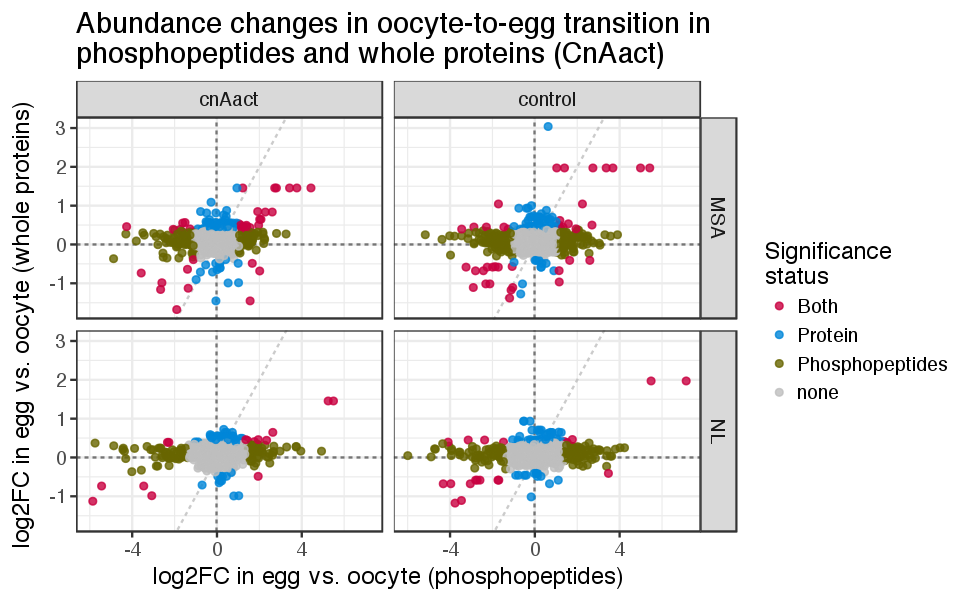

In [149]:
options(repr.plot.width = 8, repr.plot.height = 5)
# pdf("manuscript/revisions/Figure_CnAact_phosphpeptide_v_protein_logFC.pdf", width = 8, height = 5)
ggplot(filter(cnA.pep_v_prot, !is.na(sig_status)), aes(peptide_logFC, protein_logFC, colour = sig_status)) + 
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
    geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
    geom_point(alpha = 0.8) +
    facet_grid(method~samples) +
    scale_colour_manual(values = c("#c80040","#0086d8","#686500","grey")) +
    labs(title = "Abundance changes in oocyte-to-egg transition in\nphosphopeptides and whole proteins (CnAact)", x = "log2FC in egg vs. oocyte (phosphopeptides)", y = "log2FC in egg vs. oocyte (whole proteins)") +
    guides(colour=guide_legend(title="Significance\nstatus"))
# dev.off()

Example addition of phosphopeptide contrast between wildtype and mutant:

##### CanB2:

###### phosphopeptide transition from oocyte to egg:

In [150]:
msa.canB.peps.comb$PEPtransition = ifelse((msa.canB.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES" & 
                                                        msa.canB.peps.comb$peptides.msa.eWT_v_oWT_log2FC > 0) &
                                                       (msa.canB.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES" & 
                                                        msa.canB.peps.comb$peptides.msa.eCB_v_oCB_log2FC > 0),
                                                       "normal up/downregulated", ifelse((msa.canB.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES" &
                                                                         msa.canB.peps.comb$peptides.msa.eWT_v_oWT_log2FC < 0) &
                                                                        (msa.canB.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES" &
                                                                         msa.canB.peps.comb$peptides.msa.eCB_v_oCB_log2FC < 0),
                                                                        "normal up/downregulated", ifelse((msa.canB.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES" &
                                                                                          msa.canB.peps.comb$peptides.msa.eWT_v_oWT_log2FC > 0) &
                                                                                         (msa.canB.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES" &
                                                                                          msa.canB.peps.comb$peptides.msa.eCB_v_oCB_log2FC < 0),
                                                                                         "Control upregulated, CanB2 kd downregulated", ifelse((msa.canB.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES" &
                                                                                                           msa.canB.peps.comb$peptides.msa.eWT_v_oWT_log2FC < 0) &
                                                                                                          (msa.canB.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES" &
                                                                                                           msa.canB.peps.comb$peptides.msa.eCB_v_oCB_log2FC > 0),
                                                                                                          "CanB2 kd upregulated, Control downregulated", ifelse((msa.canB.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES" &
                                                                                                                              msa.canB.peps.comb$peptides.msa.eWT_v_oWT_log2FC < 0) &
                                                                                                                             msa.canB.peps.comb$peptides.msa.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control downregulated", ifelse((msa.canB.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES" &
                                                                                                                              msa.canB.peps.comb$peptides.msa.eWT_v_oWT_log2FC > 0) &
                                                                                                                             msa.canB.peps.comb$peptides.msa.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control upregulated", ifelse((msa.canB.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES" &
                                                                                                                              msa.canB.peps.comb$peptides.msa.eCB_v_oCB_log2FC < 0) &
                                                                                                                             msa.canB.peps.comb$peptides.msa.eWT_v_oWT_sig == "NO",
                                                                                                                             "CanB2 kd downregulated", ifelse((msa.canB.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES" &
                                                                                                                              msa.canB.peps.comb$peptides.msa.eCB_v_oCB_log2FC > 0) &
                                                                                                                             msa.canB.peps.comb$peptides.msa.eWT_v_oWT_sig == "NO",
                                                                                                                             "CanB2 kd upregulated", "n.s."))))))))
msa.canB.peps.comb$PEPtransition = factor(msa.canB.peps.comb$PEPtransition, levels = c("normal up/downregulated", "normal up/downregulated", "Control upregulated", "CanB2 kd upregulated", "Control downregulated", "CanB2 kd downregulated", "Control upregulated, CanB2 kd downregulated", "CanB2 kd upregulated, Control downregulated", "n.s."))

Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”

In [151]:
nl.canB.peps.comb$PEPtransition = ifelse((nl.canB.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES" & 
                                                        nl.canB.peps.comb$peptides.nl.eWT_v_oWT_log2FC > 0) &
                                                       (nl.canB.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES" & 
                                                        nl.canB.peps.comb$peptides.nl.eCB_v_oCB_log2FC > 0),
                                                       "normal up/downregulated", ifelse((nl.canB.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES" &
                                                                         nl.canB.peps.comb$peptides.nl.eWT_v_oWT_log2FC < 0) &
                                                                        (nl.canB.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES" &
                                                                         nl.canB.peps.comb$peptides.nl.eCB_v_oCB_log2FC < 0),
                                                                        "normal up/downregulated", ifelse((nl.canB.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES" &
                                                                                          nl.canB.peps.comb$peptides.nl.eWT_v_oWT_log2FC > 0) &
                                                                                         (nl.canB.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES" &
                                                                                          nl.canB.peps.comb$peptides.nl.eCB_v_oCB_log2FC < 0),
                                                                                         "Control upregulated, CanB2 kd downregulated", ifelse((nl.canB.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES" &
                                                                                                           nl.canB.peps.comb$peptides.nl.eWT_v_oWT_log2FC < 0) &
                                                                                                          (nl.canB.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES" &
                                                                                                           nl.canB.peps.comb$peptides.nl.eCB_v_oCB_log2FC > 0),
                                                                                                          "CanB2 kd upregulated, Control downregulated", ifelse((nl.canB.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES" &
                                                                                                                              nl.canB.peps.comb$peptides.nl.eWT_v_oWT_log2FC < 0) &
                                                                                                                             nl.canB.peps.comb$peptides.nl.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control downregulated", ifelse((nl.canB.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES" &
                                                                                                                              nl.canB.peps.comb$peptides.nl.eWT_v_oWT_log2FC > 0) &
                                                                                                                             nl.canB.peps.comb$peptides.nl.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control upregulated", ifelse((nl.canB.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES" &
                                                                                                                              nl.canB.peps.comb$peptides.nl.eCB_v_oCB_log2FC < 0) &
                                                                                                                             nl.canB.peps.comb$peptides.nl.eWT_v_oWT_sig == "NO",
                                                                                                                             "CanB2 kd downregulated", ifelse((nl.canB.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES" &
                                                                                                                              nl.canB.peps.comb$peptides.nl.eCB_v_oCB_log2FC > 0) &
                                                                                                                             nl.canB.peps.comb$peptides.nl.eWT_v_oWT_sig == "NO",
                                                                                                                             "CanB2 kd upregulated", "n.s."))))))))
nl.canB.peps.comb$PEPtransition = factor(nl.canB.peps.comb$PEPtransition, levels = c("normal up/downregulated", "normal up/downregulated", "Control upregulated", "CanB2 kd upregulated", "Control downregulated", "CanB2 kd downregulated", "Control upregulated, CanB2 kd downregulated", "CanB2 kd upregulated, Control downregulated", "n.s."))

Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”

###### whole-protein transition from oocyte to egg:

In [152]:
msa.canB.peps.comb$PROtransition = ifelse((msa.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" & 
                                                        msa.canB.peps.comb$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                       (msa.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" & 
                                                        msa.canB.peps.comb$wholeProteins.eCB_v_oCB_log2FC > 0),
                                                       "normal up/downregulated", ifelse((msa.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                         msa.canB.peps.comb$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                        (msa.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                         msa.canB.peps.comb$wholeProteins.eCB_v_oCB_log2FC < 0),
                                                                        "normal up/downregulated", ifelse((msa.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                          msa.canB.peps.comb$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                                                         (msa.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                          msa.canB.peps.comb$wholeProteins.eCB_v_oCB_log2FC < 0),
                                                                                         "Control upregulated, CanB2 kd downregulated", ifelse((msa.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                           msa.canB.peps.comb$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                                                          (msa.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                           msa.canB.peps.comb$wholeProteins.eCB_v_oCB_log2FC > 0),
                                                                                                          "CanB2 kd upregulated, Control downregulated", ifelse((msa.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                                              msa.canB.peps.comb$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                                                                             msa.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control downregulated", ifelse((msa.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                                              msa.canB.peps.comb$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                                                                                             msa.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control upregulated", ifelse((msa.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                                              msa.canB.peps.comb$wholeProteins.eCB_v_oCB_log2FC < 0) &
                                                                                                                             msa.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "NO",
                                                                                                                             "CanB2 kd downregulated", ifelse((msa.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                                              msa.canB.peps.comb$wholeProteins.eCB_v_oCB_log2FC > 0) &
                                                                                                                             msa.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "NO",
                                                                                                                             "CanB2 kd upregulated", "n.s."))))))))
msa.canB.peps.comb$PROtransition = factor(msa.canB.peps.comb$PROtransition, levels = c("normal up/downregulated", "normal up/downregulated", "Control upregulated", "CanB2 kd upregulated", "Control downregulated", "CanB2 kd downregulated", "Control upregulated, CanB2 kd downregulated", "CanB2 kd upregulated, Control downregulated", "n.s."))

Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”

In [153]:
nl.canB.peps.comb$PROtransition = ifelse((nl.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" & 
                                                        nl.canB.peps.comb$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                       (nl.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" & 
                                                        nl.canB.peps.comb$wholeProteins.eCB_v_oCB_log2FC > 0),
                                                       "normal up/downregulated", ifelse((nl.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                         nl.canB.peps.comb$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                        (nl.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                         nl.canB.peps.comb$wholeProteins.eCB_v_oCB_log2FC < 0),
                                                                        "normal up/downregulated", ifelse((nl.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                          nl.canB.peps.comb$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                                                         (nl.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                          nl.canB.peps.comb$wholeProteins.eCB_v_oCB_log2FC < 0),
                                                                                         "Control upregulated, CanB2 kd downregulated", ifelse((nl.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                           nl.canB.peps.comb$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                                                          (nl.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                           nl.canB.peps.comb$wholeProteins.eCB_v_oCB_log2FC > 0),
                                                                                                          "CanB2 kd upregulated, Control downregulated", ifelse((nl.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                                              nl.canB.peps.comb$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                                                                             nl.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control downregulated", ifelse((nl.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                                              nl.canB.peps.comb$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                                                                                             nl.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control upregulated", ifelse((nl.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                                              nl.canB.peps.comb$wholeProteins.eCB_v_oCB_log2FC < 0) &
                                                                                                                             nl.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "NO",
                                                                                                                             "CanB2 kd downregulated", ifelse((nl.canB.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                                              nl.canB.peps.comb$wholeProteins.eCB_v_oCB_log2FC > 0) &
                                                                                                                             nl.canB.peps.comb$wholeProteins.eWT_v_oWT_sig == "NO",
                                                                                                                             "CanB2 kd upregulated", "n.s."))))))))
nl.canB.peps.comb$PROtransition = factor(nl.canB.peps.comb$PROtransition, levels = c("normal up/downregulated", "normal up/downregulated", "Control upregulated", "CanB2 kd upregulated", "Control downregulated", "CanB2 kd downregulated", "Control upregulated, CanB2 kd downregulated", "CanB2 kd upregulated, Control downregulated", "n.s."))

Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”

##### CnAact:

###### phosphopeptide transition from oocyte to egg:

In [154]:
msa.cnA.peps.comb$PEPtransition = ifelse((msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES" & 
                                                        msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_log2FC > 0) &
                                                       (msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES" & 
                                                        msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_log2FC > 0),
                                                       "normal up/downregulated", ifelse((msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES" &
                                                                         msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_log2FC < 0) &
                                                                        (msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES" &
                                                                         msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_log2FC < 0),
                                                                        "normal up/downregulated", ifelse((msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES" &
                                                                                          msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_log2FC > 0) &
                                                                                         (msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES" &
                                                                                          msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_log2FC < 0),
                                                                                         "Control upregulated, cnA2 downregulated", ifelse((msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES" &
                                                                                                           msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_log2FC < 0) &
                                                                                                          (msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES" &
                                                                                                           msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_log2FC > 0),
                                                                                                          "cnA2 upregulated, Control downregulated", ifelse((msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES" &
                                                                                                                              msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_log2FC < 0) &
                                                                                                                             msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control downregulated", ifelse((msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_sig == "YES" &
                                                                                                                              msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_log2FC > 0) &
                                                                                                                             msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control upregulated", ifelse((msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES" &
                                                                                                                              msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_log2FC < 0) &
                                                                                                                             msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_sig == "NO",
                                                                                                                             "cnA2 downregulated", ifelse((msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_sig == "YES" &
                                                                                                                              msa.cnA.peps.comb$peptides.msa.eCB_v_oCB_log2FC > 0) &
                                                                                                                             msa.cnA.peps.comb$peptides.msa.eWT_v_oWT_sig == "NO",
                                                                                                                             "cnA2 upregulated", "n.s."))))))))
msa.cnA.peps.comb$PEPtransition = factor(msa.cnA.peps.comb$PEPtransition, levels = c("normal up/downregulated", "normal up/downregulated", "Control upregulated", "cnA2 upregulated", "Control downregulated", "cnA2 downregulated", "Control upregulated, cnA2 downregulated", "cnA2 upregulated, Control downregulated", "n.s."))

Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”

In [155]:
nl.cnA.peps.comb$PEPtransition = ifelse((nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES" & 
                                                        nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_log2FC > 0) &
                                                       (nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES" & 
                                                        nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_log2FC > 0),
                                                       "normal up/downregulated", ifelse((nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES" &
                                                                         nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_log2FC < 0) &
                                                                        (nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES" &
                                                                         nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_log2FC < 0),
                                                                        "normal up/downregulated", ifelse((nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES" &
                                                                                          nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_log2FC > 0) &
                                                                                         (nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES" &
                                                                                          nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_log2FC < 0),
                                                                                         "Control upregulated, cnA2 downregulated", ifelse((nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES" &
                                                                                                           nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_log2FC < 0) &
                                                                                                          (nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES" &
                                                                                                           nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_log2FC > 0),
                                                                                                          "cnA2 upregulated, Control downregulated", ifelse((nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES" &
                                                                                                                              nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_log2FC < 0) &
                                                                                                                             nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control downregulated", ifelse((nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_sig == "YES" &
                                                                                                                              nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_log2FC > 0) &
                                                                                                                             nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control upregulated", ifelse((nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES" &
                                                                                                                              nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_log2FC < 0) &
                                                                                                                             nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_sig == "NO",
                                                                                                                             "cnA2 downregulated", ifelse((nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_sig == "YES" &
                                                                                                                              nl.cnA.peps.comb$peptides.nl.eCB_v_oCB_log2FC > 0) &
                                                                                                                             nl.cnA.peps.comb$peptides.nl.eWT_v_oWT_sig == "NO",
                                                                                                                             "cnA2 upregulated", "n.s."))))))))
nl.cnA.peps.comb$PEPtransition = factor(nl.cnA.peps.comb$PEPtransition, levels = c("normal up/downregulated", "normal up/downregulated", "Control upregulated", "cnA2 upregulated", "Control downregulated", "cnA2 downregulated", "Control upregulated, cnA2 downregulated", "cnA2 upregulated, Control downregulated", "n.s."))

Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”

###### whole-protein transition from oocyte to egg:

In [156]:
msa.cnA.peps.comb$PROtransition = ifelse((msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" & 
                                                        msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                       (msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" & 
                                                        msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_log2FC > 0),
                                                       "normal up/downregulated", ifelse((msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                         msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                        (msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                         msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_log2FC < 0),
                                                                        "normal up/downregulated", ifelse((msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                          msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                                                         (msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                          msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_log2FC < 0),
                                                                                         "Control upregulated, cnA2 downregulated", ifelse((msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                           msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                                                          (msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                           msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_log2FC > 0),
                                                                                                          "cnA2 upregulated, Control downregulated", ifelse((msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                                              msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                                                                             msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control downregulated", ifelse((msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                                              msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                                                                                             msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control upregulated", ifelse((msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                                              msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_log2FC < 0) &
                                                                                                                             msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "NO",
                                                                                                                             "cnA2 downregulated", ifelse((msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                                              msa.cnA.peps.comb$wholeProteins.eCB_v_oCB_log2FC > 0) &
                                                                                                                             msa.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "NO",
                                                                                                                             "cnA2 upregulated", "n.s."))))))))
msa.cnA.peps.comb$PROtransition = factor(msa.cnA.peps.comb$PROtransition, levels = c("normal up/downregulated", "normal up/downregulated", "Control upregulated", "cnA2 upregulated", "Control downregulated", "cnA2 downregulated", "Control upregulated, cnA2 downregulated", "cnA2 upregulated, Control downregulated", "n.s."))

Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”

In [157]:
nl.cnA.peps.comb$PROtransition = ifelse((nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" & 
                                                        nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                       (nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" & 
                                                        nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_log2FC > 0),
                                                       "upregulated", ifelse((nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                         nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                        (nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                         nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_log2FC < 0),
                                                                        "downregulated", ifelse((nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                          nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                                                         (nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                          nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_log2FC < 0),
                                                                                         "Control upregulated, cnA2 downregulated", ifelse((nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                           nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                                                          (nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                           nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_log2FC > 0),
                                                                                                          "cnA2 upregulated, Control downregulated", ifelse((nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                                              nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_log2FC < 0) &
                                                                                                                             nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control downregulated", ifelse((nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "YES" &
                                                                                                                              nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_log2FC > 0) &
                                                                                                                             nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "NO",
                                                                                                                             "Control upregulated", ifelse((nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                                              nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_log2FC < 0) &
                                                                                                                             nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "NO",
                                                                                                                             "cnA2 downregulated", ifelse((nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_sig == "YES" &
                                                                                                                              nl.cnA.peps.comb$wholeProteins.eCB_v_oCB_log2FC > 0) &
                                                                                                                             nl.cnA.peps.comb$wholeProteins.eWT_v_oWT_sig == "NO",
                                                                                                                             "cnA2 upregulated", "n.s."))))))))
nl.cnA.peps.comb$PROtransition = factor(nl.cnA.peps.comb$PROtransition, levels = c("upregulated", "downregulated", "Control upregulated", "cnA2 upregulated", "Control downregulated", "cnA2 downregulated", "Control upregulated, cnA2 downregulated", "cnA2 upregulated, Control downregulated", "n.s."))

Add the phophoprotein anotation columns:

In [158]:
msa.canB.peps.comb = merge(msa.canB.peps.comb, canB_phosphoproteins_msa.annots, by.x = "Accession", by.y = "Accession", all.x=T)
nl.canB.peps.comb = merge(nl.canB.peps.comb, canB_phosphoproteins_nl.annots, by.x = "Accession", by.y = "Accession", all.x=T)

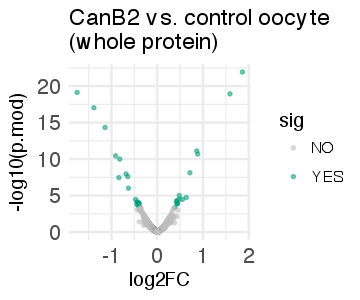

In [159]:
options(repr.plot.width = 3, repr.plot.height = 2.5)

protDF1 = filter(results.eb_proteins.rbind, !is.na(sig) & comparison == "Oocyte_CanB2 - Oocyte_WT")
# protDF1$comp = "CanB2 vs. control (oocyte)"

ggplot(protDF1, aes(log2FC, -log10(p.mod), colour = sig)) + 
    geom_point(size = 0.5, alpha = 0.5) + 
#     facet_wrap(~comp) +
    labs(title = "CanB2 vs. control oocyte\n(whole protein)") +
    scale_colour_manual(values = c("gray","#019a78")) +
    theme_minimal() +
    theme(axis.text = element_text(size = 12), strip.text = element_text(size = 14))
    

Comparing oocytes at the whole protein level between control and CanB2

In [160]:
oCB_v_oWT_up = filter(results.eb_proteins.rbind, !is.na(sig) & comparison == "Oocyte_CanB2 - Oocyte_WT" & sig == "YES" & log2FC > 0)$Accession
oCB_v_oWT_down = filter(results.eb_proteins.rbind, !is.na(sig) & comparison == "Oocyte_CanB2 - Oocyte_WT" & sig == "YES" & log2FC < 0)$Accession

Proteins that are higher in canB2 occytes:

In [161]:
oCB_v_oWT_up.genes = subset(annotations, Accession %in% oCB_v_oWT_up)$`Gene Symbol`

Proteins that are higher in control occytes:

In [162]:
oCB_v_oWT_down.genes = subset(annotations, Accession %in% oCB_v_oWT_down)$`Gene Symbol`

Compare to the Kronjas results:

In [163]:
CanB2_down_proteins = filter(kronjas, GeneSymbol %in% oCB_v_oWT_down.genes)
colnames(CanB2_down_proteins) = c("Kronjas_status", "GeneSymbol")
CanB2_down_proteins$Zhang_status = "downregulated in CanB2 knockdown"
CanB2_down_proteins$Kronjas_status = gsub("\\.", " ", CanB2_down_proteins$Kronjas_status)
CanB2_down_proteins = subset(CanB2_down_proteins, select = c("GeneSymbol", "Zhang_status", "Kronjas_status"))

CanB2_up_proteins = filter(kronjas, GeneSymbol %in% oCB_v_oWT_up.genes)
colnames(CanB2_up_proteins) = c("Kronjas_status", "GeneSymbol")
CanB2_up_proteins$Zhang_status = "upregulated in CanB2 knockup"
CanB2_up_proteins$Kronjas_status = gsub("\\.", " ", CanB2_up_proteins$Kronjas_status)
CanB2_up_proteins = subset(CanB2_up_proteins, select = c("GeneSymbol", "Zhang_status", "Kronjas_status"))

Zhang_v_Kronjas_comparison = rbind(CanB2_up_proteins, CanB2_down_proteins)
write.table(Zhang_v_Kronjas_comparison, file = "manuscript/revisions/Zhang_vs_Kronjas_comparison.txt", quote = F, sep = "\t", row.names = F)

At this stage we can look at the overlap between significantly phosphoregulated proteins from this study and from the Krauchunas *et al* study:

We'll compare the phosphoproteins found in the current study (MSA and NL) and in the Krauchunas *et al* study:

In [164]:
msa.annots.breif = select(canB_phosphoproteins_msa.annots, FBgn_ID = `Ensembl Gene ID`, GeneSymbol = `Gene Symbol`)
nl.annots.breif = select(canB_phosphoproteins_nl.annots, FBgn_ID = `Ensembl Gene ID`, GeneSymbol = `Gene Symbol`)

In [165]:
msaDF = select(msa.canB.peps.comb, Accession, 'Ensembl Gene ID', peptide_id, peptide, logFC = peptides.msa.eWT_v_oWT_log2FC, pValue = peptides.msa.eWT_v_oWT_p.ord, sig = peptides.msa.eWT_v_oWT_sig)
msaDF$krau = ifelse(msaDF$`Ensembl Gene ID` %in% krauchunas, "yes", "no")
msaSig = filter(msaDF, sig == "YES" & !is.na(sig) & `Ensembl Gene ID` != "")$`Ensembl Gene ID`

nlDF = select(nl.canB.peps.comb, Accession, 'Ensembl Gene ID', peptide_id, peptide, logFC = peptides.nl.eWT_v_oWT_log2FC, pValue = peptides.nl.eWT_v_oWT_p.ord, sig = peptides.nl.eWT_v_oWT_sig)
nlDF$krau = ifelse(nlDF$`Ensembl Gene ID` %in% krauchunas, "yes", "no")
nlSig = filter(nlDF, sig == "YES" & !is.na(sig) & `Ensembl Gene ID` != "")$`Ensembl Gene ID`

In [166]:
nlDF$method = "NL"
nlDF = merge(nlDF, nl.annots.breif, by.x = "Ensembl Gene ID", by.y = "FBgn_ID", all.x = T)

msaDF$method = "MSA"
msaDF = merge(msaDF, msa.annots.breif, by.x = "Ensembl Gene ID", by.y = "FBgn_ID", all.x = T)

Zhang_v_Krauchunas = rbind(msaDF, nlDF)
Zhang_v_Krauchunas = filter(Zhang_v_Krauchunas, !is.na("Ensembl Gene ID") & `Ensembl Gene ID` != "")
head(Zhang_v_Krauchunas)
write.table(Zhang_v_Krauchunas, "manuscript/revisions/Zhang_vs_Krauchunas_table.txt", quote = F, sep = "\t", row.names = F)

Ensembl Gene ID Accession
1 FBgn0000100     M9PG76   
2 FBgn0000100     M9PG76   
3 FBgn0000100     M9PG76   
4 FBgn0000100     M9PG76   
5 FBgn0000140     Q9VC45   
6 FBgn0000140     Q9VC45   
  peptide_id                                                                                                                
1 M9PG76.K..KPESESEEEDDDMGFGLFD....1xTMT6plex..K1...1xTMT6plex..N.Term...1xPhospho..S.                                      
2 M9PG76.K..KPESESEEEDDDMGFGLFD....1xOxidation..M13...1xTMT6plex..K1...1xTMT6plex..N.Term...2xPhospho..S4.100...S6.100..    
3 M9PG76.K..KPESESEEEDDDMGFGLFD....1xTMT6plex..K1...1xTMT6plex..N.Term...2xPhospho..S4.100...S6.100..                       
4 M9PG76.K..KPESESEEEDDDMGFGLFD....1xOxidation..M13...1xTMT6plex..K1...1xTMT6plex..N.Term...1xPhospho..S.                   
5 Q9VC45.R..SLKENLSPMTPGNLLDVIDNLR..F.1xOxidation..M9...1xTMT6plex..K3...1xTMT6plex..N.Term...2xPhospho..S7.97.9...T10.100..
6 Q9VC45.R..SLKENLSPMTPGNLLDVIDNLR..F.1xTMT6plex..K3...1xTMT6plex..N.Term...2xPhospho..S.T.                                 
  peptide                        logFC       pValue      sig krau method
1 [K].KPESESEEEDDDMGFGLFD.[-]    -0.58215381 0.002911082 NO  yes  MSA   
2 [K].KPESESEEEDDDMGFGLFD.[-]    -0.01759279 0.814706953 NO  yes  MSA   
3 [K].KPESESEEEDDDMGFGLFD.[-]     0.08834762 0.429746606 NO  yes  MSA   
4 [K].KPESESEEEDDDMGFGLFD.[-]    -0.08310338 0.570931295 NO  yes  MSA   
5 [R].SLKENLSPMTPGNLLDVIDNLR.[F] -0.69766770 0.003808101 NO  no   MSA   
6 [R].SLKENLSPMTPGNLLDVIDNLR.[F] -0.83624283 0.014257548 YES no   MSA   
  GeneSymbol
1 RpLP0     
2 RpLP0     
3 RpLP0     
4 RpLP0     
5 asp       
6 asp

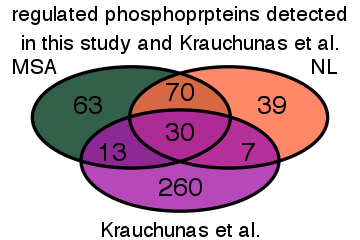

In [167]:
# msa_phosphopeptides_FBgn = canB_phosphoproteins_msa.annots$'Ensembl Gene ID'
# nl_phosphopeptides_FBgn = canB_phosphoproteins_nl.annots$'Ensembl Gene ID'

MSA_NL_KRA <- list(MSA = msaSig, NL = nlSig, `Krauchunas et al.` = krauchunas)

MSA_NL_KRA_Vdiag<-venn.diagram(MSA_NL_KRA, NULL, fill=c("#00391d", "#ff6a43", "#a41ba7"), alpha=c(0.8,0.8, 0.8), cex = 1.3, cat.fontface= 6, cat.dist = c(0.1, 0.1, 0.1), cat.cex =1, resolution = 1000)

# eWT_v_oWT.sigPeptides_combs <- unlist(lapply(1:length(eWT_v_oWT.sigPeptides), function(j) combn(names(eWT_v_oWT.sigPeptides), j, simplify = FALSE)), recursive = FALSE)
# names(eWT_v_oWT.sigPeptides_combs) <- sapply(eWT_v_oWT.sigPeptides_combs, function(i) paste0(i, collapse = ","))
    
# eWT_v_oWT.sigPeptides_elements <- lapply(eWT_v_oWT.sigPeptides_combs, function(i) Setdiff(eWT_v_oWT.sigPeptides[i], eWT_v_oWT.sigPeptides[setdiff(names(eWT_v_oWT.sigPeptides), i)]))
    
options(repr.plot.width = 3, repr.plot.height = 2)
# pdf("manuscript/revisions/Zhang_vs_Krauchunas_Venn_diagram.pdf", width = 4, height = 2.5)
grid.arrange(gTree(children=MSA_NL_KRA_Vdiag), top = "regulated phosphoprpteins detected\nin this study and Krauchunas et al.")
# dev.off()

Plot kinases and/or phosphatases in the dataset. First plot the oocyte abundances of control against CanB2 mutant:

In [252]:
options(repr.plot.width = 5, repr.plot.height = 3)
tmpDF = subset(canB_peptides_msa_abundances.rn, rownames(canB_peptides_msa_abundances.rn) %in% kinases_peptides_msa)
tmpDF = subset(tmpDF, select = grepl("Oocyte", colnames(tmpDF)))
tmpDF$Oocyte_WT = rowMeans(subset(tmpDF, select = c("126_Oocyte_WT", "127C_Oocyte_WT")))
tmpDF$Oocyte_CanB2 = rowMeans(subset(tmpDF, select = c("127N_Oocyte_CanB2", "128N_Oocyte_CanB2", "128C_Oocyte_CanB2")))
tmpDF$peptide_id = rownames(tmpDF)
tmpDF = merge(tmpDF, IDs.canB_msa_peptides, by.x = "peptide_id", by.y = "peptide_id", all.x = T)
tmpDF = merge(tmpDF, msa.canB.peps.comb, by.x = "peptide_id", by.y = "peptide_id", all.x = T)

kinases_peptides_msa_gg = ggplot(tmpDF, aes(log2(Oocyte_WT), log2(Oocyte_CanB2), colour = peptides.msa.oCB_v_oWT_sig)) + 
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
    geom_point() +
    labs(colour = "Misregulated\nkinase", x = "log2 abundance\n(control oocyte)", y = "log2 abundance\n(CanB2 oocyte)", title = "Detected kinases (MSA)") +
    geom_text_repel(data =subset(tmpDF, peptides.msa.oCB_v_oWT_sig == "YES"),aes(log2(Oocyte_WT), log2(Oocyte_CanB2), label = `Gene Symbol`), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
    scale_colour_manual(values = c("darkgrey","#00391d"))

rm(tmpDF)

options(repr.plot.width = 5, repr.plot.height = 3)
tmpDF = subset(canB_peptides_nl_abundances.rn, rownames(canB_peptides_nl_abundances.rn) %in% kinases_peptides_nl)
tmpDF = subset(tmpDF, select = grepl("Oocyte", colnames(tmpDF)))
tmpDF$Oocyte_WT = rowMeans(subset(tmpDF, select = c("126_Oocyte_WT", "127C_Oocyte_WT")))
tmpDF$Oocyte_CanB2 = rowMeans(subset(tmpDF, select = c("127N_Oocyte_CanB2", "128N_Oocyte_CanB2", "128C_Oocyte_CanB2")))
tmpDF$peptide_id = rownames(tmpDF)
tmpDF = merge(tmpDF, IDs.canB_nl_peptides, by.x = "peptide_id", by.y = "peptide_id", all.x = T)
tmpDF = merge(tmpDF, nl.canB.peps.comb, by.x = "peptide_id", by.y = "peptide_id", all.x = T)

kinases_peptides_nl_gg = ggplot(tmpDF, aes(log2(Oocyte_WT), log2(Oocyte_CanB2), colour = peptides.nl.oCB_v_oWT_sig)) + 
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
    geom_point() +
    labs(colour = "Misregulated\nkinase", x = "log2 abundance\n(control oocyte)", y = "log2 abundance\n(CanB2 oocyte)", title = "Detected kinases (NL)") +
#     geom_text_repel(data =subset(tmpDF, grepl("Akap", `Gene Symbol`)),aes(log2(Oocyte_WT), log2(Oocyte_CanB2), label = `Gene Symbol`), 
#                     force = 12, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 3) +
    scale_colour_manual(values = c("darkgrey","#00391d"))

rm(tmpDF)

In [269]:
options(repr.plot.width = 5, repr.plot.height = 3)
tmpDF = subset(canB_peptides_msa_abundances.rn, rownames(canB_peptides_msa_abundances.rn) %in% phosphatases_peptides_msa)
tmpDF = subset(tmpDF, select = grepl("Oocyte", colnames(tmpDF)))
tmpDF$Oocyte_WT = rowMeans(subset(tmpDF, select = c("126_Oocyte_WT", "127C_Oocyte_WT")))
tmpDF$Oocyte_CanB2 = rowMeans(subset(tmpDF, select = c("127N_Oocyte_CanB2", "128N_Oocyte_CanB2", "128C_Oocyte_CanB2")))
tmpDF$peptide_id = rownames(tmpDF)
tmpDF = merge(tmpDF, IDs.canB_msa_peptides, by.x = "peptide_id", by.y = "peptide_id", all.x = T)
tmpDF = merge(tmpDF, msa.canB.peps.comb, by.x = "peptide_id", by.y = "peptide_id", all.x = T)

phosphatases_peptides_msa_gg = ggplot(tmpDF, aes(log2(Oocyte_WT), log2(Oocyte_CanB2), colour = peptides.msa.oCB_v_oWT_sig)) + 
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
    geom_point() +
    labs(colour = "Misregulated\nphosphatase", x = "log2 abundance\n(control oocyte)", y = "log2 abundance\n(CanB2 oocyte)", title = "Detected phosphatases (MSA)") +
    geom_text_repel(data =subset(tmpDF, peptides.msa.oCB_v_oWT_sig == "YES"),aes(log2(Oocyte_WT), log2(Oocyte_CanB2), label = `Gene Symbol`), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
    scale_colour_manual(values = c("darkgrey","#00391d"))

rm(tmpDF)

options(repr.plot.width = 5, repr.plot.height = 3)
tmpDF = subset(canB_peptides_nl_abundances.rn, rownames(canB_peptides_nl_abundances.rn) %in% phosphatases_peptides_nl)
tmpDF = subset(tmpDF, select = grepl("Oocyte", colnames(tmpDF)))
tmpDF$Oocyte_WT = rowMeans(subset(tmpDF, select = c("126_Oocyte_WT", "127C_Oocyte_WT")))
tmpDF$Oocyte_CanB2 = rowMeans(subset(tmpDF, select = c("127N_Oocyte_CanB2", "128N_Oocyte_CanB2", "128C_Oocyte_CanB2")))
tmpDF$peptide_id = rownames(tmpDF)
tmpDF = merge(tmpDF, IDs.canB_nl_peptides, by.x = "peptide_id", by.y = "peptide_id", all.x = T)
tmpDF = merge(tmpDF, nl.canB.peps.comb, by.x = "peptide_id", by.y = "peptide_id", all.x = T)

phosphatases_peptides_nl_gg = ggplot(tmpDF, aes(log2(Oocyte_WT), log2(Oocyte_CanB2), colour = peptides.nl.oCB_v_oWT_sig)) + 
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
    geom_point() +
    labs(colour = "Misregulated\nphosphatase", x = "log2 abundance\n(control oocyte)", y = "log2 abundance\n(CanB2 oocyte)", title = "Detected phosphatases (NL)") +
#     geom_text_repel(data =subset(tmpDF, grepl("Akap", `Gene Symbol`)),aes(log2(Oocyte_WT), log2(Oocyte_CanB2), label = `Gene Symbol`), 
#                     force = 12, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 3) +
    scale_colour_manual(values = c("darkgrey","#00391d"))

rm(tmpDF)

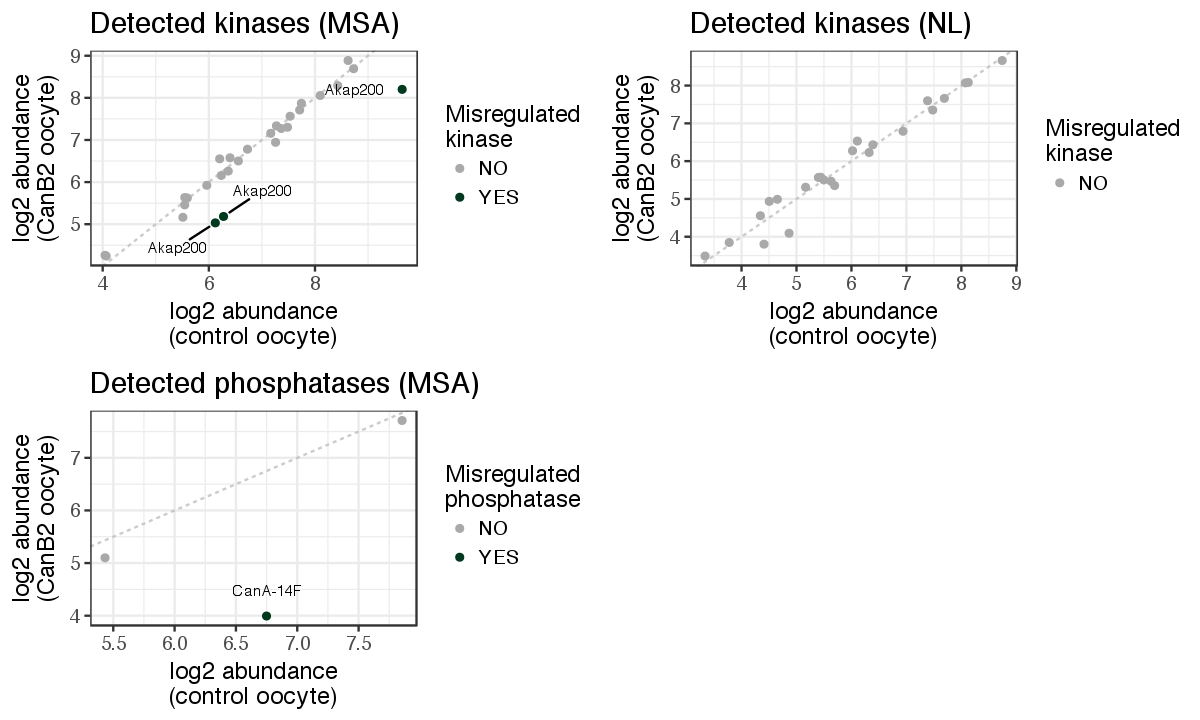

In [270]:
options(repr.plot.width = 10, repr.plot.height = 6)
# pdf("manuscript/revisions/kinases_phosphotase_abundance_in_oocytes.pdf", width = 10, height = 6)
suppressWarnings(plot_grid(kinases_peptides_msa_gg, kinases_peptides_nl_gg, phosphatases_peptides_msa_gg, ncol = 2))
# dev.off()

Let's also look at the transition from oocyte to egg between the two states:

In [191]:
options(repr.plot.width = 6, repr.plot.height = 3)
nl_kinase = ggplot(filter(nl.canB.peps.comb, Accession %in% kinases), aes(peptides.nl.eWT_v_oWT_log2FC, peptides.nl.eCB_v_oCB_log2FC, colour = PEPtransition)) +
        geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
        geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
        geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
        geom_point(alpha = 0.7, size = 1.2) +
        geom_text_repel(data =subset(nl.canB.peps.comb, Accession %in% kinases & PEPtransition != "n.s."),aes(peptides.nl.eWT_v_oWT_log2FC, peptides.nl.eCB_v_oCB_log2FC, label = `Gene Symbol`), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3)  +
        labs(title = "Kinases (NL)", x = "log2FC (Control)", y = "log2FC (CanB2 kd)") +
        guides(colour=guide_legend(title="Phosphopeptide\nstatus")) +
        scale_colour_manual(values = c("#3f04b8",
                                        "#305e00",
                                        "#b40095",
                                        "gray"))

# No phosphatases in this dataset

In [192]:
options(repr.plot.width = 6, repr.plot.height = 3)
msa_kinase = ggplot(filter(msa.canB.peps.comb, Accession %in% kinases), aes(peptides.msa.eWT_v_oWT_log2FC, peptides.msa.eCB_v_oCB_log2FC, colour = PEPtransition)) +
        geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
        geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
        geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
        geom_point(alpha = 0.7, size = 1.2) +
        geom_text_repel(data =subset(msa.canB.peps.comb, Accession %in% kinases & PEPtransition != "n.s."),aes(peptides.msa.eWT_v_oWT_log2FC, peptides.msa.eCB_v_oCB_log2FC, label = `Gene Symbol`), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
        labs(title = "Kinases (MSA)", x = "log2FC (Control)", y = "log2FC (CanB2 kd)") +
        guides(colour=guide_legend(title="Phosphopeptide\nstatus")) +
        scale_colour_manual(values = c("#3f04b8",
                                        "#305e00",
                                        "#b40095",
                                        "#cc4500",
                                        "#0268d9",
                                        "gray"))

# ggplot(filter(msa.canB.peps.comb, Accession %in% phosphatases), aes(peptides.msa.eWT_v_oWT_log2FC, peptides.msa.eCB_v_oCB_log2FC, colour = PEPtransition)) +
#         geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
#         geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
#         geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
#         geom_point(alpha = 0.7, size = 1.2) +
#         geom_text_repel(data =subset(msa.canB.peps.comb, Accession %in% phosphatases & PEPtransition != "n.s."),aes(peptides.msa.eWT_v_oWT_log2FC, peptides.msa.eCB_v_oCB_log2FC, label = `Gene Symbol`), 
#                     force = 12, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 3) +
#         scale_colour_manual(values = c("#3f04b8",
#                                         "#305e00",
#                                         "#b40095",
#                                         "#cc4500",
#                                         "#0268d9",
#                                         "gray")) 

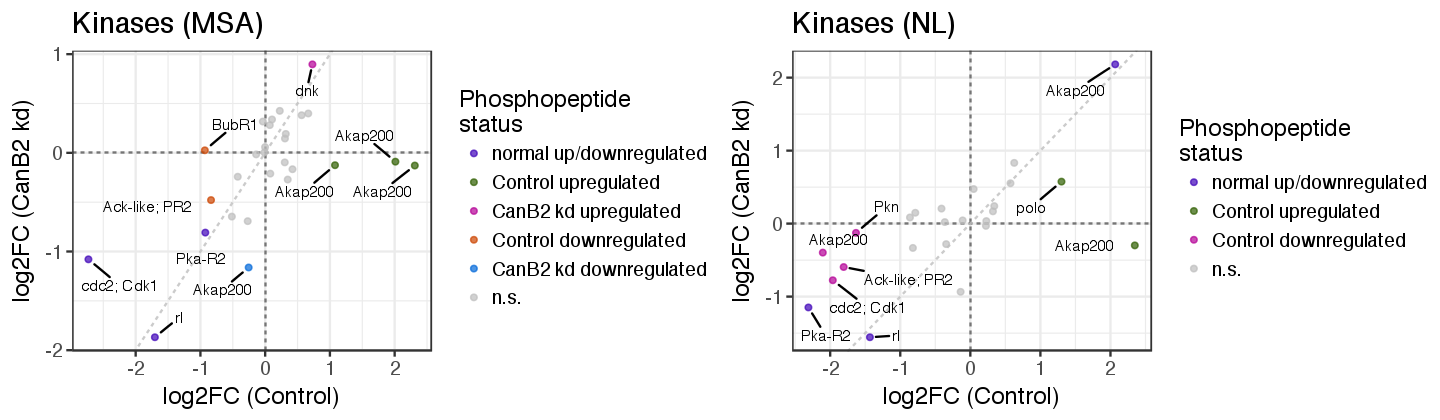

In [193]:
options(repr.plot.width = 12, repr.plot.height = 3.5)
# pdf("manuscript/revisions/kinases_point_plot.pdf", width = 12, height = 3.5)
suppressWarnings(plot_grid(msa_kinase, nl_kinase, ncol = 2))
# dev.off()

Plot to contrast fold-change between two contrasts:

##### CanB2:

In [94]:
msa_phos_wt.v.canB = ggplot(msa.canB.peps.comb, aes(peptides.msa.eWT_v_oWT_log2FC, peptides.msa.eCB_v_oCB_log2FC, colour = PEPtransition)) + 
    geom_point(alpha = 0.7, size = 1.2) + 
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
    geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
#     geom_smooth(colour = "gray", fill = "gray", size = 0.5, linetype = "dashed") +
#     geom_text_repel(data =subset(msa.canB.peps.comb, PEPtransition == "abnormal" & (peptides.msa.eWT_v_oWT_log2FC < -2 | peptides.msa.eWT_v_oWT_log2FC > 2)),aes(peptides.msa.eWT_v_oWT_log2FC, peptides.msa.eCB_v_oCB_log2FC, label = `Gene Symbol`), 
#                     force = 12, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 3) +
    scale_colour_manual(values = c("#3f04b8",
"#305e00",
"#b40095",
"#cc4500",
"#0268d9",
"#cf2e8a",
"#21004d", "gray")) +
    labs(title = "MSA", x = "log2FC (Control)", y = "log2FC (CanB2 kd)") +
guides(colour=guide_legend(title="Phosphopeptide\nstatus"))

In [95]:
nl_phos_wt.v.canB = ggplot(filter(nl.canB.peps.comb, !is.na(PEPtransition)), aes(peptides.nl.eWT_v_oWT_log2FC, peptides.nl.eCB_v_oCB_log2FC, colour = PEPtransition)) + 
    geom_point(alpha = 0.7, size = 1.2) + 
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
    geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
#     geom_smooth(colour = "gray", fill = "gray",size = 0.5, linetype = "dashed") +
#     geom_text_repel(data =subset(nl.canB.peps.comb, PEPtransition == "abnormal" & (peptides.nl.eWT_v_oWT_log2FC < -2 | peptides.nl.eWT_v_oWT_log2FC > 2)),aes(peptides.nl.eWT_v_oWT_log2FC, peptides.nl.eCB_v_oCB_log2FC, label = `Gene Symbol`), 
#                     force = 12, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 3) +
    theme(legend.position = "none") +
    scale_colour_manual(values = c("#3f04b8",
"#305e00",
"#b40095",
"#cc4500",
"#0268d9",
"#cf2e8a",
"#21004d", "gray")) +
    labs(title = "NL", x = "log2FC (Control)", y = "log2FC (CanB2 kd)") +
guides(colour=guide_legend(title="Phosphopeptide\nstatus"))

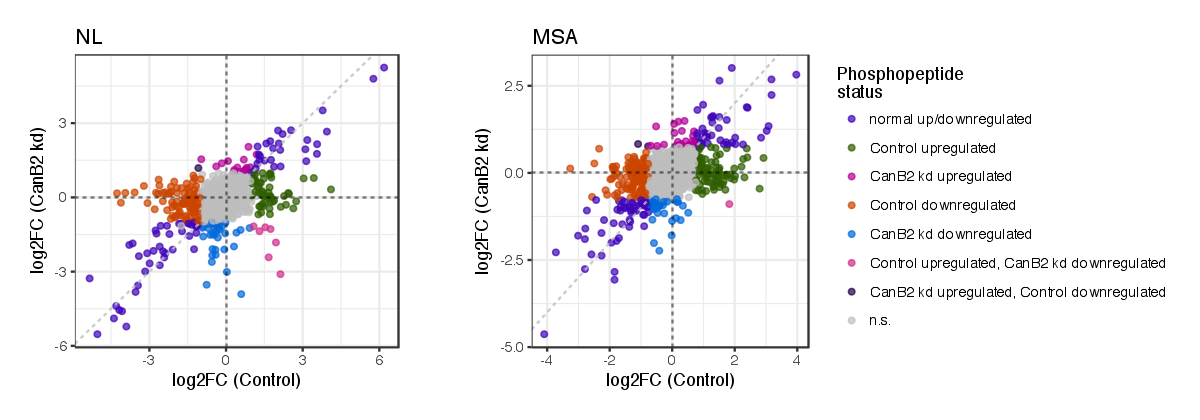

In [96]:
options(repr.plot.width = 10, repr.plot.height = 3.5)
(fig3A = suppressWarnings(plot_grid(nl_phos_wt.v.canB, msa_phos_wt.v.canB, ncol = 2, rel_widths = c(1,1.8), scale = c(0.9, 0.9))))

In [241]:
binom.test(150, 390, 0.5)


	Exact binomial test

data:  150 and 390
number of successes = 150, number of trials = 390, p-value = 6.021e-06
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.3360867 0.4349095
sample estimates:
probability of success 
             0.3846154 


Output peptide and protein counts for the significant peptides/proteins:

MSA CanB2

In [97]:
msa.canB.proteins_with_upregulated_phosphopeptides.Control = unique(subset(msa.canB.peps.comb, PEPtransition == "upregulated" | PEPtransition == "Control upregulated")$Accession)
msa.canB.upregulated_phosphopeptides.Control = unique(subset(msa.canB.peps.comb, PEPtransition == "upregulated" | PEPtransition == "Control upregulated")$peptide)
# length(msa.canB.proteins_with_upregulated_phosphopeptides.Control)
# length(msa.canB.upregulated_phosphopeptides.Control)

msa.canB.proteins_with_upregulated_phosphopeptides.CanB2 = unique(subset(msa.canB.peps.comb, PEPtransition == "upregulated" | PEPtransition == "CanB2 kd upregulated")$Accession)
msa.canB.upregulated_phosphopeptides.CanB2 = unique(subset(msa.canB.peps.comb, PEPtransition == "upregulated" | PEPtransition == "CanB2 kd upregulated")$peptide)
# length(msa.canB.proteins_with_upregulated_phosphopeptides.CanB2)
# length(msa.canB.upregulated_phosphopeptides.CanB2)

msa.canB.proteins_with_downregulated_phosphopeptides.Control = unique(subset(msa.canB.peps.comb, PEPtransition == "downregulated" | PEPtransition == "Control downregulated")$Accession)
msa.canB.downregulated_phosphopeptides.Control = unique(subset(msa.canB.peps.comb, PEPtransition == "downregulated" | PEPtransition == "Control downregulated")$peptide)
# length(msa.canB.proteins_with_downregulated_phosphopeptides.Control)
# length(msa.canB.downregulated_phosphopeptides.Control)

msa.canB.proteins_with_downregulated_phosphopeptides.CanB2 = unique(subset(msa.canB.peps.comb, PEPtransition == "downregulated" | PEPtransition == "CanB2 kd downregulated")$Accession)
msa.canB.downregulated_phosphopeptides.CanB2 = unique(subset(msa.canB.peps.comb, PEPtransition == "downregulated" | PEPtransition == "CanB2 kd downregulated")$peptide)
# length(msa.canB.proteins_with_downregulated_phosphopeptides.CanB2)
# length(msa.canB.downregulated_phosphopeptides.CanB2)

msa.canB.proteins_with_upregulated_phosphopeptides.ControlOnly = unique(subset(msa.canB.peps.comb, PEPtransition == "Control upregulated")$Accession)
msa.canB.upregulated_phosphopeptides.ControlOnly = unique(subset(msa.canB.peps.comb, PEPtransition == "Control upregulated")$peptide)
# length(msa.canB.proteins_with_upregulated_phosphopeptides.ControlOnly)
# length(msa.canB.upregulated_phosphopeptides.ControlOnly)

msa.canB.proteins_with_upregulated_phosphopeptides.CanB2Only = unique(subset(msa.canB.peps.comb, PEPtransition == "CanB2 kd upregulated")$Accession)
msa.canB.upregulated_phosphopeptides.CanB2Only = unique(subset(msa.canB.peps.comb, PEPtransition == "CanB2 kd upregulated")$peptide)
# length(msa.canB.proteins_with_upregulated_phosphopeptides.CanB2Only)
# length(msa.canB.upregulated_phosphopeptides.CanB2Only)

msa.canB.proteins_with_downregulated_phosphopeptides.ControlOnly = unique(subset(msa.canB.peps.comb, PEPtransition == "Control downregulated")$Accession)
msa.canB.downregulated_phosphopeptides.ControlOnly = unique(subset(msa.canB.peps.comb, PEPtransition == "Control downregulated")$peptide)
# length(msa.canB.proteins_with_downregulated_phosphopeptides.ControlOnly)
# length(msa.canB.downregulated_phosphopeptides.ControlOnly)

msa.canB.proteins_with_downregulated_phosphopeptides.CanB2Only = unique(subset(msa.canB.peps.comb, PEPtransition == "CanB2 kd downregulated")$Accession)
msa.canB.downregulated_phosphopeptides.CanB2Only = unique(subset(msa.canB.peps.comb, PEPtransition == "CanB2 kd downregulated")$peptide)
# length(msa.canB.proteins_with_downregulated_phosphopeptides.CanB2Only)
# length(msa.canB.downregulated_phosphopeptides.CanB2Only)

msa.canB.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte = unique(subset(msa.canB.peps.comb, peptides.msa.oCB_v_oWT_sig == "YES" & peptides.msa.oCB_v_oWT_log2FC > 0)$Accession)
msa.canB.upegulated_phosphopeptides_in_mutant_oocyte = unique(subset(msa.canB.peps.comb, peptides.msa.oCB_v_oWT_sig == "YES" & peptides.msa.oCB_v_oWT_log2FC > 0)$peptide)
# length(msa.canB.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte)
# length(msa.canB.upegulated_phosphopeptides_in_mutant_oocyte)

msa.canB.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte = unique(subset(msa.canB.peps.comb, peptides.msa.oCB_v_oWT_sig == "YES" & peptides.msa.oCB_v_oWT_log2FC < 0)$Accession)
msa.canB.downegulated_phosphopeptides_in_mutant_oocyte = unique(subset(msa.canB.peps.comb, peptides.msa.oCB_v_oWT_sig == "YES" & peptides.msa.oCB_v_oWT_log2FC < 0)$peptide)
# length(msa.canB.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte)
# length(msa.canB.downegulated_phosphopeptides_in_mutant_oocyte)

msa.canB.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut = unique(subset(msa.canB.peps.comb, PEPtransition == "Control upregulated, CanB2 downregulated")$Accession)
msa.canB.phosphopeptides_up_in_wt_but_down_in_mut = unique(subset(msa.canB.peps.comb, PEPtransition == "Control upregulated, CanB2 downregulated")$peptide)
# length(msa.canB.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut)
# length(msa.canB.phosphopeptides_up_in_wt_but_down_in_mut)

msa.canB.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt = unique(subset(msa.canB.peps.comb, PEPtransition == "CanB2 kd upregulated, Control downregulated")$Accession)
msa.canB.phosphopeptides_up_in_mut_but_down_in_wt = unique(subset(msa.canB.peps.comb, PEPtransition == "CanB2 kd upregulated, Control downregulated")$peptide)
# length(msa.canB.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt)
# length(msa.canB.phosphopeptides_up_in_mut_but_down_in_wt)

In [98]:
msa.canB.proteins_with_upregulated_phosphopeptides.Control_gs = unique(subset(msa.canB.peps.comb, PEPtransition == "upregulated" | PEPtransition == "Control upregulated")$`Gene Symbol`)
# length(msa.canB.proteins_with_upregulated_phosphopeptides.Control)
# length(msa.canB.upregulated_phosphopeptides.Control)

msa.canB.proteins_with_upregulated_phosphopeptides.CanB2_gs = unique(subset(msa.canB.peps.comb, PEPtransition == "upregulated" | PEPtransition == "CanB2 kd upregulated")$`Gene Symbol`)
# length(msa.canB.proteins_with_upregulated_phosphopeptides.CanB2)
# length(msa.canB.upregulated_phosphopeptides.CanB2)

msa.canB.proteins_with_downregulated_phosphopeptides.Control_gs = unique(subset(msa.canB.peps.comb, PEPtransition == "downregulated" | PEPtransition == "Control downregulated")$`Gene Symbol`)
# length(msa.canB.proteins_with_downregulated_phosphopeptides.Control)
# length(msa.canB.downregulated_phosphopeptides.Control)

msa.canB.proteins_with_downregulated_phosphopeptides.CanB2_gs = unique(subset(msa.canB.peps.comb, PEPtransition == "downregulated" | PEPtransition == "CanB2 kd downregulated")$`Gene Symbol`)
# length(msa.canB.proteins_with_downregulated_phosphopeptides.CanB2)
# length(msa.canB.downregulated_phosphopeptides.CanB2)

msa.canB.proteins_with_upregulated_phosphopeptides.ControlOnly_gs = unique(subset(msa.canB.peps.comb, PEPtransition == "Control upregulated")$`Gene Symbol`)
# length(msa.canB.proteins_with_upregulated_phosphopeptides.ControlOnly)
# length(msa.canB.upregulated_phosphopeptides.ControlOnly)

msa.canB.proteins_with_upregulated_phosphopeptides.CanB2Only_gs = unique(subset(msa.canB.peps.comb, PEPtransition == "CanB2 kd upregulated")$`Gene Symbol`)
# length(msa.canB.proteins_with_upregulated_phosphopeptides.CanB2Only)
# length(msa.canB.upregulated_phosphopeptides.CanB2Only)

msa.canB.proteins_with_downregulated_phosphopeptides.ControlOnly_gs = unique(subset(msa.canB.peps.comb, PEPtransition == "Control downregulated")$`Gene Symbol`)
# length(msa.canB.proteins_with_downregulated_phosphopeptides.ControlOnly)
# length(msa.canB.downregulated_phosphopeptides.ControlOnly)

msa.canB.proteins_with_downregulated_phosphopeptides.CanB2Only_gs = unique(subset(msa.canB.peps.comb, PEPtransition == "CanB2 kd downregulated")$`Gene Symbol`)
# length(msa.canB.proteins_with_downregulated_phosphopeptides.CanB2Only)
# length(msa.canB.downregulated_phosphopeptides.CanB2Only)

msa.canB.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte_gs = unique(subset(msa.canB.peps.comb, peptides.msa.oCB_v_oWT_sig == "YES" & peptides.msa.oCB_v_oWT_log2FC > 0)$`Gene Symbol`)
# length(msa.canB.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte)
# length(msa.canB.upegulated_phosphopeptides_in_mutant_oocyte)

msa.canB.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte_gs = unique(subset(msa.canB.peps.comb, peptides.msa.oCB_v_oWT_sig == "YES" & peptides.msa.oCB_v_oWT_log2FC < 0)$`Gene Symbol`)
# length(msa.canB.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte)
# length(msa.canB.downegulated_phosphopeptides_in_mutant_oocyte)

msa.canB.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut_gs = unique(subset(msa.canB.peps.comb, PEPtransition == "Control upregulated, CanB2 downregulated")$`Gene Symbol`)
# length(msa.canB.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut)
# length(msa.canB.phosphopeptides_up_in_wt_but_down_in_mut)

msa.canB.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt_gs = unique(subset(msa.canB.peps.comb, PEPtransition == "CanB2 kd upregulated, Control downregulated")$`Gene Symbol`)
# length(msa.canB.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt)
# length(msa.canB.phosphopeptides_up_in_mut_but_down_in_wt)

NL CanB2

In [99]:
nl.canB.proteins_with_upregulated_phosphopeptides.Control = unique(subset(nl.canB.peps.comb, PEPtransition == "upregulated" | PEPtransition == "Control upregulated")$Accession)
nl.canB.upregulated_phosphopeptides.Control = unique(subset(nl.canB.peps.comb, PEPtransition == "upregulated" | PEPtransition == "Control upregulated")$peptide)
# length(nl.canB.proteins_with_upregulated_phosphopeptides.Control)
# length(nl.canB.upregulated_phosphopeptides.Control)

nl.canB.proteins_with_upregulated_phosphopeptides.CanB2 = unique(subset(nl.canB.peps.comb, PEPtransition == "upregulated" | PEPtransition == "CanB2 kd upregulated")$Accession)
nl.canB.upregulated_phosphopeptides.CanB2 = unique(subset(nl.canB.peps.comb, PEPtransition == "upregulated" | PEPtransition == "CanB2 kd upregulated")$peptide)
# length(nl.canB.proteins_with_upregulated_phosphopeptides.CanB2)
# length(nl.canB.upregulated_phosphopeptides.CanB2)

nl.canB.proteins_with_downregulated_phosphopeptides.Control = unique(subset(nl.canB.peps.comb, PEPtransition == "downregulated" | PEPtransition == "Control downregulated")$Accession)
nl.canB.downregulated_phosphopeptides.Control = unique(subset(nl.canB.peps.comb, PEPtransition == "downregulated" | PEPtransition == "Control downregulated")$peptide)
# length(nl.canB.proteins_with_downregulated_phosphopeptides.Control)
# length(nl.canB.downregulated_phosphopeptides.Control)

nl.canB.proteins_with_downregulated_phosphopeptides.CanB2 = unique(subset(nl.canB.peps.comb, PEPtransition == "downregulated" | PEPtransition == "CanB2 kd downregulated")$Accession)
nl.canB.downregulated_phosphopeptides.CanB2 = unique(subset(nl.canB.peps.comb, PEPtransition == "downregulated" | PEPtransition == "CanB2 kd downregulated")$peptide)
# length(nl.canB.proteins_with_downregulated_phosphopeptides.CanB2)
# length(nl.canB.downregulated_phosphopeptides.CanB2)

nl.canB.proteins_with_upregulated_phosphopeptides.ControlOnly = unique(subset(nl.canB.peps.comb, PEPtransition == "Control upregulated")$Accession)
nl.canB.upregulated_phosphopeptides.ControlOnly = unique(subset(nl.canB.peps.comb, PEPtransition == "Control upregulated")$peptide)
# length(nl.canB.proteins_with_upregulated_phosphopeptides.ControlOnly)
# length(nl.canB.upregulated_phosphopeptides.ControlOnly)

nl.canB.proteins_with_upregulated_phosphopeptides.CanB2Only = unique(subset(nl.canB.peps.comb, PEPtransition == "CanB2 kd upregulated")$Accession)
nl.canB.upregulated_phosphopeptides.CanB2Only = unique(subset(nl.canB.peps.comb, PEPtransition == "CanB2 kd upregulated")$peptide)
# length(nl.canB.proteins_with_upregulated_phosphopeptides.CanB2Only)
# length(nl.canB.upregulated_phosphopeptides.CanB2Only)

nl.canB.proteins_with_downregulated_phosphopeptides.ControlOnly = unique(subset(nl.canB.peps.comb, PEPtransition == "Control downregulated")$Accession)
nl.canB.downregulated_phosphopeptides.ControlOnly = unique(subset(nl.canB.peps.comb, PEPtransition == "Control downregulated")$peptide)
# length(nl.canB.proteins_with_downregulated_phosphopeptides.ControlOnly)
# length(nl.canB.downregulated_phosphopeptides.ControlOnly)

nl.canB.proteins_with_downregulated_phosphopeptides.CanB2Only = unique(subset(nl.canB.peps.comb, PEPtransition == "CanB2 kd downregulated")$Accession)
nl.canB.downregulated_phosphopeptides.CanB2Only = unique(subset(nl.canB.peps.comb, PEPtransition == "CanB2 kd downregulated")$peptide)
# length(nl.canB.proteins_with_downregulated_phosphopeptides.CanB2Only)
# length(nl.canB.downregulated_phosphopeptides.CanB2Only)

nl.canB.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte = unique(subset(nl.canB.peps.comb, peptides.nl.oCB_v_oWT_sig == "YES" & peptides.nl.oCB_v_oWT_log2FC > 0)$Accession)
nl.canB.upegulated_phosphopeptides_in_mutant_oocyte = unique(subset(nl.canB.peps.comb, peptides.nl.oCB_v_oWT_sig == "YES" & peptides.nl.oCB_v_oWT_log2FC > 0)$peptide)
# length(nl.canB.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte)
# length(nl.canB.upegulated_phosphopeptides_in_mutant_oocyte)

nl.canB.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte = unique(subset(nl.canB.peps.comb, peptides.nl.oCB_v_oWT_sig == "YES" & peptides.nl.oCB_v_oWT_log2FC < 0)$Accession)
nl.canB.downegulated_phosphopeptides_in_mutant_oocyte = unique(subset(nl.canB.peps.comb, peptides.nl.oCB_v_oWT_sig == "YES" & peptides.nl.oCB_v_oWT_log2FC < 0)$peptide)
# length(nl.canB.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte)
# length(nl.canB.downegulated_phosphopeptides_in_mutant_oocyte)

nl.canB.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut = unique(subset(nl.canB.peps.comb, PEPtransition == "Control upregulated, CanB2 downregulated")$Accession)
nl.canB.phosphopeptides_up_in_wt_but_down_in_mut = unique(subset(nl.canB.peps.comb, PEPtransition == "Control upregulated, CanB2 downregulated")$peptide)
# length(nl.canB.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut)
# length(nl.canB.phosphopeptides_up_in_wt_but_down_in_mut)

nl.canB.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt = unique(subset(nl.canB.peps.comb, PEPtransition == "CanB2 kd upregulated, Control downregulated")$Accession)
nl.canB.phosphopeptides_up_in_mut_but_down_in_wt = unique(subset(nl.canB.peps.comb, PEPtransition == "CanB2 kd upregulated, Control downregulated")$peptide)
# length(nl.canB.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt)
# length(nl.canB.phosphopeptides_up_in_mut_but_down_in_wt)

In [100]:
nl.canB.proteins_with_upregulated_phosphopeptides.Control_gs = unique(subset(nl.canB.peps.comb, PEPtransition == "upregulated" | PEPtransition == "Control upregulated")$`Gene Symbol`)
# length(nl.canB.proteins_with_upregulated_phosphopeptides.Control)
# length(nl.canB.upregulated_phosphopeptides.Control)

nl.canB.proteins_with_upregulated_phosphopeptides.CanB2_gs = unique(subset(nl.canB.peps.comb, PEPtransition == "upregulated" | PEPtransition == "CanB2 kd upregulated")$`Gene Symbol`)
# length(nl.canB.proteins_with_upregulated_phosphopeptides.CanB2)
# length(nl.canB.upregulated_phosphopeptides.CanB2)

nl.canB.proteins_with_downregulated_phosphopeptides.Control_gs = unique(subset(nl.canB.peps.comb, PEPtransition == "downregulated" | PEPtransition == "Control downregulated")$`Gene Symbol`)
# length(nl.canB.proteins_with_downregulated_phosphopeptides.Control)
# length(nl.canB.downregulated_phosphopeptides.Control)

nl.canB.proteins_with_downregulated_phosphopeptides.CanB2_gs = unique(subset(nl.canB.peps.comb, PEPtransition == "downregulated" | PEPtransition == "CanB2 kd downregulated")$`Gene Symbol`)
# length(nl.canB.proteins_with_downregulated_phosphopeptides.CanB2)
# length(nl.canB.downregulated_phosphopeptides.CanB2)

nl.canB.proteins_with_upregulated_phosphopeptides.ControlOnly_gs = unique(subset(nl.canB.peps.comb, PEPtransition == "Control upregulated")$`Gene Symbol`)
# length(nl.canB.proteins_with_upregulated_phosphopeptides.ControlOnly)
# length(nl.canB.upregulated_phosphopeptides.ControlOnly)

nl.canB.proteins_with_upregulated_phosphopeptides.CanB2Only_gs = unique(subset(nl.canB.peps.comb, PEPtransition == "CanB2 kd upregulated")$`Gene Symbol`)
# length(nl.canB.proteins_with_upregulated_phosphopeptides.CanB2Only)
# length(nl.canB.upregulated_phosphopeptides.CanB2Only)

nl.canB.proteins_with_downregulated_phosphopeptides.ControlOnly_gs = unique(subset(nl.canB.peps.comb, PEPtransition == "Control downregulated")$`Gene Symbol`)
# length(nl.canB.proteins_with_downregulated_phosphopeptides.ControlOnly)
# length(nl.canB.downregulated_phosphopeptides.ControlOnly)

nl.canB.proteins_with_downregulated_phosphopeptides.CanB2Only_gs = unique(subset(nl.canB.peps.comb, PEPtransition == "CanB2 kd downregulated")$`Gene Symbol`)
# length(nl.canB.proteins_with_downregulated_phosphopeptides.CanB2Only)
# length(nl.canB.downregulated_phosphopeptides.CanB2Only)

nl.canB.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte_gs = unique(subset(nl.canB.peps.comb, peptides.nl.oCB_v_oWT_sig == "YES" & peptides.nl.oCB_v_oWT_log2FC > 0)$`Gene Symbol`)
# length(nl.canB.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte)
# length(nl.canB.upegulated_phosphopeptides_in_mutant_oocyte)

nl.canB.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte_gs = unique(subset(nl.canB.peps.comb, peptides.nl.oCB_v_oWT_sig == "YES" & peptides.nl.oCB_v_oWT_log2FC < 0)$`Gene Symbol`)
# length(nl.canB.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte)
# length(nl.canB.downegulated_phosphopeptides_in_mutant_oocyte)

nl.canB.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut_gs = unique(subset(nl.canB.peps.comb, PEPtransition == "Control upregulated, CanB2 downregulated")$`Gene Symbol`)
# length(nl.canB.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut)
# length(nl.canB.phosphopeptides_up_in_wt_but_down_in_mut)

nl.canB.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt_gs = unique(subset(nl.canB.peps.comb, PEPtransition == "CanB2 kd upregulated, Control downregulated")$`Gene Symbol`)
# length(nl.canB.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt)
# length(nl.canB.phosphopeptides_up_in_mut_but_down_in_wt)

Union of NL and MSA CanB2

In [101]:
# length(unique(union(nl.canB.proteins_with_upregulated_phosphopeptides.Control, msa.canB.proteins_with_upregulated_phosphopeptides.Control)))
# length(unique(union(nl.canB.upregulated_phosphopeptides.Control, msa.canB.upregulated_phosphopeptides.Control)))
# length(unique(union(nl.canB.proteins_with_upregulated_phosphopeptides.CanB2, msa.canB.proteins_with_upregulated_phosphopeptides.CanB2)))
# length(unique(union(nl.canB.upregulated_phosphopeptides.CanB2, msa.canB.upregulated_phosphopeptides.CanB2)))

In [102]:
# length(unique(union(nl.canB.proteins_with_downregulated_phosphopeptides.Control, msa.canB.proteins_with_downregulated_phosphopeptides.Control)))
# length(unique(union(nl.canB.downregulated_phosphopeptides.Control, msa.canB.downregulated_phosphopeptides.Control)))
# length(unique(union(nl.canB.proteins_with_downregulated_phosphopeptides.CanB2, msa.canB.proteins_with_downregulated_phosphopeptides.CanB2)))
# length(unique(union(nl.canB.downregulated_phosphopeptides.CanB2, msa.canB.downregulated_phosphopeptides.CanB2)))

In [103]:
Phosphorylated_during_egg_activation_in_control_but_not_in_CanB2_kd = unique(union(nl.canB.proteins_with_upregulated_phosphopeptides.ControlOnly_gs, msa.canB.proteins_with_upregulated_phosphopeptides.ControlOnly_gs))
write.table(Phosphorylated_during_egg_activation_in_control_but_not_in_CanB2_kd, "Results/Phosphorylated_during_egg_activation_in_control_but_not_in_CanB2_kd.txt", quote = F, row.names = F)

# length(unique(union(nl.canB.upregulated_phosphopeptides.ControlOnly, msa.canB.upregulated_phosphopeptides.ControlOnly)))
Phosphorylated_during_egg_activation_in_CanB2_kd_but_not_in_Control = unique(union(nl.canB.proteins_with_upregulated_phosphopeptides.CanB2Only_gs, msa.canB.proteins_with_upregulated_phosphopeptides.CanB2Only))
write.table(Phosphorylated_during_egg_activation_in_CanB2_kd_but_not_in_Control, "Results/Phosphorylated_during_egg_activation_in_CanB2_kd_but_not_in_Control.txt", quote = F, row.names = F)
# length(unique(union(nl.canB.upregulated_phosphopeptides.CanB2Only, msa.canB.upregulated_phosphopeptides.CanB2Only)))

In [104]:
Dephosphorylated_during_egg_activation_in_control_but_not_in_CanB2_kd = unique(union(nl.canB.proteins_with_downregulated_phosphopeptides.ControlOnly_gs, msa.canB.proteins_with_downregulated_phosphopeptides.ControlOnly_gs))
write.table(Dephosphorylated_during_egg_activation_in_control_but_not_in_CanB2_kd, "Results/Dephosphorylated_during_egg_activation_in_control_but_not_in_CanB2_kd.txt", quote = F, row.names = F)

Dephosphorylated_during_egg_activation_in_CanB2_kd_but_not_in_Control = unique(union(nl.canB.proteins_with_downregulated_phosphopeptides.CanB2Only_gs, msa.canB.proteins_with_downregulated_phosphopeptides.CanB2Only_gs))
write.table(Dephosphorylated_during_egg_activation_in_CanB2_kd_but_not_in_Control, "Results/Dephosphorylated_during_egg_activation_in_CanB2_kd_but_not_in_Control.txt", quote = F, row.names = F)

# length(unique(union(nl.canB.downregulated_phosphopeptides.ControlOnly, msa.canB.downregulated_phosphopeptides.ControlOnly)))
# length(unique(union(nl.canB.proteins_with_downregulated_phosphopeptides.CanB2Only, msa.canB.proteins_with_downregulated_phosphopeptides.CanB2Only)))
# length(unique(union(nl.canB.downregulated_phosphopeptides.CanB2Only, msa.canB.downregulated_phosphopeptides.CanB2Only)))

In [105]:
# length(unique(union(nl.canB.proteins_with_downregulated_phosphopeptides.ControlOnly, msa.canB.proteins_with_downregulated_phosphopeptides.ControlOnly)))
# length(unique(union(nl.canB.downregulated_phosphopeptides.ControlOnly, msa.canB.downregulated_phosphopeptides.ControlOnly)))
# length(unique(union(nl.canB.proteins_with_downregulated_phosphopeptides.CanB2Only, msa.canB.proteins_with_downregulated_phosphopeptides.CanB2Only)))
# length(unique(union(nl.canB.downregulated_phosphopeptides.CanB2Only, msa.canB.downregulated_phosphopeptides.CanB2Only)))

In [106]:
hyperphosphorylated_in_oocyte_with_CanB2_kd = unique(union(nl.canB.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte_gs, msa.canB.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte_gs))
write.table(hyperphosphorylated_in_oocyte_with_CanB2_kd, "Results/hyperphosphorylated_in_oocyte_with_CanB2_kd.txt", quote = F, row.names = F)
# length(unique(union(nl.canB.upegulated_phosphopeptides_in_mutant_oocyte, msa.canB.upegulated_phosphopeptides_in_mutant_oocyte)))

underphosphorylated_in_oocyte_with_CanB2_kd  = unique(union(nl.canB.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte_gs, msa.canB.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte_gs))
write.table(underphosphorylated_in_oocyte_with_CanB2_kd, "Results/underphosphorylated_in_oocyte_with_CanB2_kd.txt", quote = F, row.names = F)
# length(unique(union(nl.canB.downegulated_phosphopeptides_in_mutant_oocyte, msa.canB.downegulated_phosphopeptides_in_mutant_oocyte)))

In [107]:
# length(unique(union(nl.canB.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut, msa.canB.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut)))
# length(unique(union(nl.canB.phosphopeptides_up_in_wt_but_down_in_mut, msa.canB.phosphopeptides_up_in_wt_but_down_in_mut)))
# length(unique(union(nl.canB.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt, msa.canB.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt)))
# length(unique(union(nl.canB.phosphopeptides_up_in_mut_but_down_in_wt, msa.canB.phosphopeptides_up_in_mut_but_down_in_wt)))

In [108]:
canB.proteins_with_upregulated_phosphopeptides.Control = unique(c(as.character(msa.canB.proteins_with_upregulated_phosphopeptides.Control), as.character(nl.canB.proteins_with_upregulated_phosphopeptides.Control)))

In [109]:
canB.proteins_with_downregulated_phosphopeptides.Control = unique(c(as.character(msa.canB.proteins_with_downregulated_phosphopeptides.Control), as.character(nl.canB.proteins_with_downregulated_phosphopeptides.Control)))

In [110]:
canB.proteins_with_upregulated_phosphopeptides.CanB2 = unique(c(as.character(msa.canB.proteins_with_upregulated_phosphopeptides.CanB2), as.character(nl.canB.proteins_with_upregulated_phosphopeptides.CanB2)))

In [111]:
canB.proteins_with_downregulated_phosphopeptides.CanB2 = unique(c(as.character(msa.canB.proteins_with_downregulated_phosphopeptides.CanB2), as.character(nl.canB.proteins_with_downregulated_phosphopeptides.CanB2)))

In [112]:
Control_phUP = length(canB.proteins_with_upregulated_phosphopeptides.Control)
Control_phUP_protUP = nrow(filter(protDF1, Accession %in% canB.proteins_with_upregulated_phosphopeptides.Control & comp2 == "Control" & sig == "YES" & log2FC > 0))
Control_phUP_protDN = nrow(filter(protDF1, Accession %in% canB.proteins_with_upregulated_phosphopeptides.Control & comp2 == "Control" & sig == "YES" & log2FC < 0))
Control_phUP_protNC = nrow(filter(protDF1, Accession %in% canB.proteins_with_upregulated_phosphopeptides.Control & comp2 == "Control" & sig == "NO"))
Control_phUP_protND = nrow(filter(as.data.frame(canB.proteins_with_upregulated_phosphopeptides.Control), canB.proteins_with_upregulated_phosphopeptides.Control %!in% protDF1$Accession))

df.Control_phUP = data.frame(protein_status = c("increased", "decreased", "unchanged", "undetected"), proportion_of_proteins = c(Control_phUP_protUP/Control_phUP, Control_phUP_protDN/Control_phUP, Control_phUP_protNC/Control_phUP, Control_phUP_protND/Control_phUP), treatment = "Control", phosphostate = "up")

In [113]:
Control_phDOWN = length(canB.proteins_with_downregulated_phosphopeptides.Control)
Control_phDOWN_protUP = nrow(filter(protDF1, Accession %in% canB.proteins_with_downregulated_phosphopeptides.Control & comp2 == "Control" & sig == "YES" & log2FC > 0))
Control_phDOWN_protDN = nrow(filter(protDF1, Accession %in% canB.proteins_with_downregulated_phosphopeptides.Control & comp2 == "Control" & sig == "YES" & log2FC < 0))
Control_phDOWN_protNC = nrow(filter(protDF1, Accession %in% canB.proteins_with_downregulated_phosphopeptides.Control & comp2 == "Control" & sig == "NO"))
Control_phDOWN_protND = nrow(filter(as.data.frame(canB.proteins_with_downregulated_phosphopeptides.Control), canB.proteins_with_downregulated_phosphopeptides.Control %!in% protDF1$Accession))

df.Control_phDOWN = data.frame(protein_status = c("increased", "decreased", "unchanged", "undetected"), proportion_of_proteins = c(Control_phDOWN_protUP/Control_phDOWN, Control_phDOWN_protDN/Control_phDOWN, Control_phDOWN_protNC/Control_phDOWN, Control_phDOWN_protND/Control_phDOWN), treatment = "Control", phosphostate = "down")

In [114]:
CanB2_phUP = length(canB.proteins_with_upregulated_phosphopeptides.CanB2)
CanB2_phUP_protUP = nrow(filter(protDF1, Accession %in% canB.proteins_with_upregulated_phosphopeptides.CanB2 & comp2 == "CanB2 kd" & sig == "YES" & log2FC > 0))
CanB2_phUP_protDN = nrow(filter(protDF1, Accession %in% canB.proteins_with_upregulated_phosphopeptides.CanB2 & comp2 == "CanB2 kd" & sig == "YES" & log2FC < 0))
CanB2_phUP_protNC = nrow(filter(protDF1, Accession %in% canB.proteins_with_upregulated_phosphopeptides.CanB2 & comp2 == "CanB2 kd" & sig == "NO"))
CanB2_phUP_protND = nrow(filter(as.data.frame(canB.proteins_with_upregulated_phosphopeptides.CanB2), canB.proteins_with_upregulated_phosphopeptides.CanB2 %!in% protDF1$Accession))

df.CanB2_phUP = data.frame(protein_status = c("increased", "decreased", "unchanged", "undetected"), proportion_of_proteins = c(CanB2_phUP_protUP/CanB2_phUP, CanB2_phUP_protDN/CanB2_phUP, CanB2_phUP_protNC/CanB2_phUP, CanB2_phUP_protND/CanB2_phUP), treatment = "CanB2 kd", phosphostate = "up")

In [115]:
CanB2_phDOWN = length(canB.proteins_with_downregulated_phosphopeptides.CanB2)
CanB2_phDOWN_protUP = nrow(filter(protDF1, Accession %in% canB.proteins_with_downregulated_phosphopeptides.CanB2 & comp2 == "CanB2 kd" & sig == "YES" & log2FC > 0))
CanB2_phDOWN_protDN = nrow(filter(protDF1, Accession %in% canB.proteins_with_downregulated_phosphopeptides.CanB2 & comp2 == "CanB2 kd" & sig == "YES" & log2FC < 0))
CanB2_phDOWN_protNC = nrow(filter(protDF1, Accession %in% canB.proteins_with_downregulated_phosphopeptides.CanB2 & comp2 == "CanB2 kd" & sig == "NO"))
CanB2_phDOWN_protND = nrow(filter(as.data.frame(canB.proteins_with_downregulated_phosphopeptides.CanB2), canB.proteins_with_downregulated_phosphopeptides.CanB2 %!in% protDF1$Accession))

df.CanB2_phDOWN = data.frame(protein_status = c("increased", "decreased", "unchanged", "undetected"), proportion_of_proteins = c(CanB2_phDOWN_protUP/CanB2_phDOWN, CanB2_phDOWN_protDN/CanB2_phDOWN, CanB2_phDOWN_protNC/CanB2_phDOWN, CanB2_phDOWN_protND/CanB2_phDOWN), treatment = "CanB2 kd", phosphostate = "down")

In [116]:
(prot_phos_status = rbind(df.Control_phUP, df.Control_phDOWN, df.CanB2_phUP, df.CanB2_phDOWN))
prot_phos_status$protein_status = factor(prot_phos_status$protein_status, levels = c("undetected", "decreased", "increased","unchanged"))

protein_status proportion_of_proteins treatment phosphostate
1  increased      0.02500000             Control   up          
2  decreased      0.02500000             Control   up          
3  unchanged      0.90000000             Control   up          
4  undetected     0.05000000             Control   up          
5  increased      0.02631579             Control   down        
6  decreased      0.03508772             Control   down        
7  unchanged      0.78947368             Control   down        
8  undetected     0.14912281             Control   down        
9  increased      0.14285714             CanB2 kd  up          
10 decreased      0.00000000             CanB2 kd  up          
11 unchanged      0.75000000             CanB2 kd  up          
12 undetected     0.10714286             CanB2 kd  up          
13 increased      0.00000000             CanB2 kd  down        
14 decreased      0.02380952             CanB2 kd  down        
15 unchanged      0.83333333             CanB2 kd  down        
16 undetected     0.14285714             CanB2 kd  down

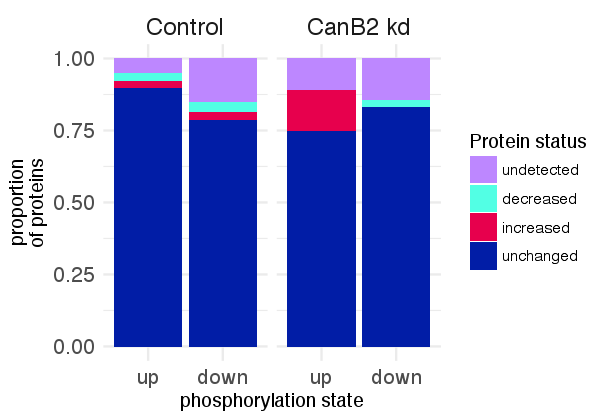

In [117]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
(fig2D = ggplot(prot_phos_status, aes(phosphostate, proportion_of_proteins, fill = protein_status)) + 
    geom_bar(stat = "identity") + 
    facet_wrap(~treatment) +
    scale_fill_manual(values = c("#bd87ff","#52ffe4","#e7004d","#011da6")) +
theme_minimal() +
    theme(axis.text.x = element_text(size = 12), axis.text.y = element_text(size = 12), strip.text = element_text(size = 14)) +
    labs(x = "phosphorylation state", y = "proportion\nof proteins") +
    guides(fill=guide_legend(title="Protein status")))

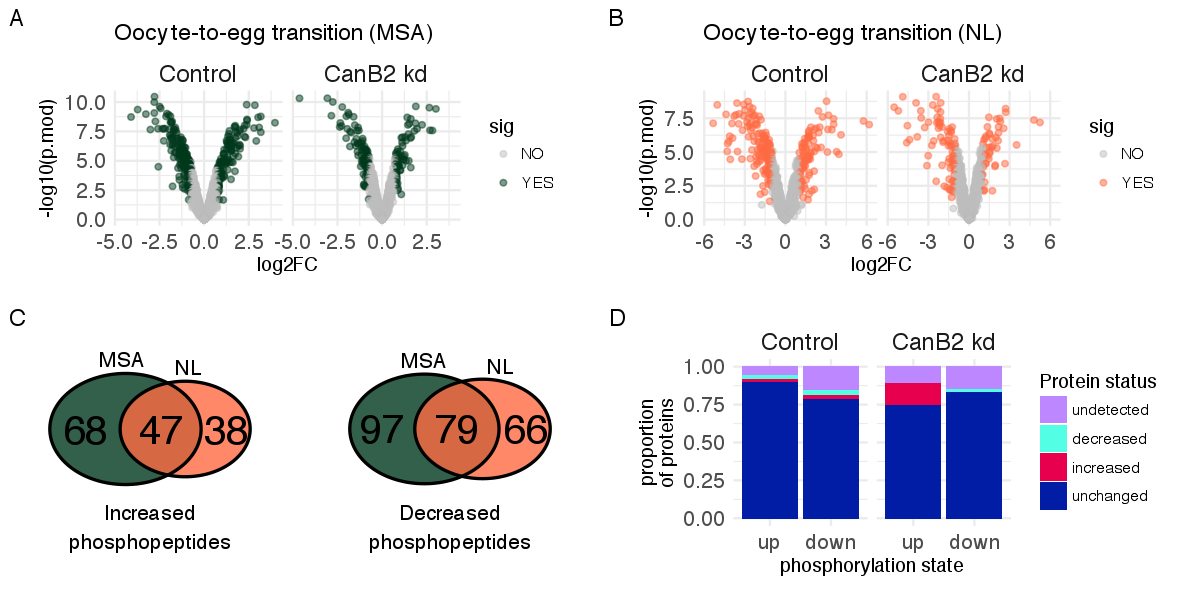

In [118]:
options(repr.plot.width = 10, repr.plot.height = 5)
# pdf("manuscript/Figures/Figure_2.pdf", width = 10, height = 5)
plot_grid(fig2A, fig2B, fig2C, fig2D,labels = c("A", "B", "C", "D"), ncol = 2, scale = c(0.9,0.9,1,0.9))
# dev.off()

##### CnAact:

In [119]:
msa_phos_wt.v.cnA = ggplot(msa.cnA.peps.comb, aes(peptides.msa.eWT_v_oWT_log2FC, peptides.msa.eCB_v_oCB_log2FC, colour = PEPtransition)) + 
    geom_point(alpha = 0.5, size = 1.2) + 
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
    geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
#     geom_smooth(colour = "gray", fill = "gray", size = 0.5, linetype = "dashed") +
#     geom_text_repel(data =subset(msa.cnA.peps.comb, PEPtransition == "abnormal" & (peptides.msa.eWT_v_oWT_log2FC < -2 | peptides.msa.eWT_v_oWT_log2FC > 2 | peptides.msa.eCB_v_oCB_log2FC < -2 | peptides.msa.eCB_v_oCB_log2FC > 2)),aes(peptides.msa.eWT_v_oWT_log2FC, peptides.msa.eCB_v_oCB_log2FC, label = `Accession`), 
#                     force = 12, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 3) +
    scale_colour_manual(values = c("#3f04b8",
"#305e00",
"#b40095",
"#cc4500",
"#0268d9",
"#cf2e8a","gray")) +
    labs(title = "MSA", x = "log2FC (Control)", y = "log2FC (CnAact2)")+
guides(colour=guide_legend(title="Phosphopeptide\nstatus"))

In [120]:
nl_phos_wt.v.cnA = ggplot(filter(nl.cnA.peps.comb, !is.na(PEPtransition)), aes(peptides.nl.eWT_v_oWT_log2FC, peptides.nl.eCB_v_oCB_log2FC, colour = PEPtransition)) + 
    geom_point(alpha = 0.5, size = 1.2) + 
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
    geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
#     geom_smooth(colour = "gray", fill = "gray",size = 0.5, linetype = "dashed") +
#     geom_text_repel(data =subset(nl.cnA.peps.comb, PEPtransition == "abnormal" & (peptides.nl.eWT_v_oWT_log2FC < -2 | peptides.nl.eWT_v_oWT_log2FC > 2 | peptides.nl.eCB_v_oCB_log2FC < -2 | peptides.nl.eCB_v_oCB_log2FC > 2)),aes(peptides.nl.eWT_v_oWT_log2FC, peptides.nl.eCB_v_oCB_log2FC, label = `Accession`), 
#                     force = 12, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 3) +
    theme(legend.position = "none") +
    scale_colour_manual(values = c("#3f04b8",
"#305e00",
"#b40095",
"#cc4500",
"#0268d9",
"#cf2e8a",
"#21004d", "gray")) +
    labs(title = "NL", x = "log2FC (Control)", y = "log2FC (CnAact2)")+
    guides(colour=guide_legend(title="Phosphopeptide\nstatus"))

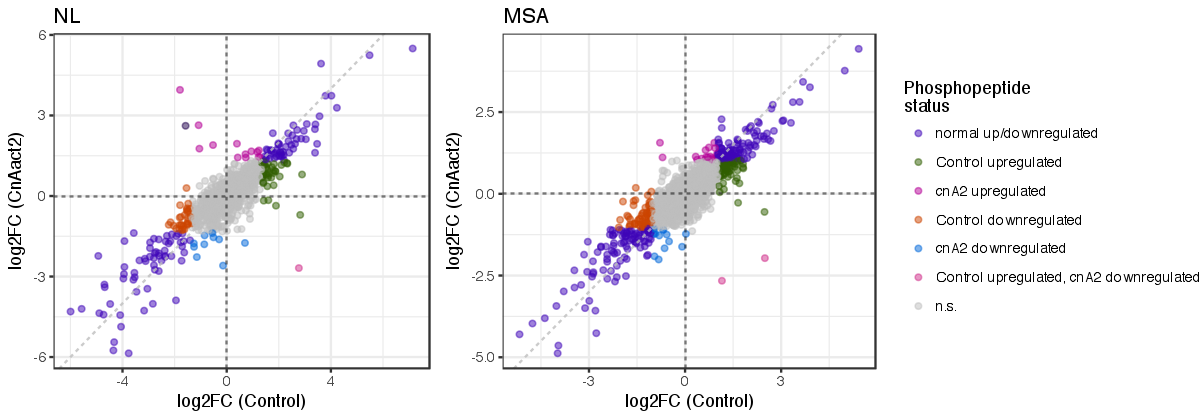

In [121]:
options(repr.plot.width = 10, repr.plot.height = 3.5)
suppressWarnings(plot_grid(nl_phos_wt.v.cnA, msa_phos_wt.v.cnA, ncol = 2, rel_widths = c(1.15,2)))

Output peptide and protein counts for the significant peptides/proteins:

MSA CnAact2

In [122]:
msa.cnA.proteins_with_upregulated_phosphopeptides.Control = unique(subset(msa.cnA.peps.comb, PEPtransition == "upregulated" | PEPtransition == "Control upregulated")$Accession)
msa.cnA.upregulated_phosphopeptides.Control = unique(subset(msa.cnA.peps.comb, PEPtransition == "upregulated" | PEPtransition == "Control upregulated")$peptide)
# length(msa.cnA.proteins_with_upregulated_phosphopeptides.Control)
# length(msa.cnA.upregulated_phosphopeptides.Control)

msa.cnA.proteins_with_upregulated_phosphopeptides.cnA2 = unique(subset(msa.cnA.peps.comb, PEPtransition == "upregulated" | PEPtransition == "cnA2 upregulated")$Accession)
msa.cnA.upregulated_phosphopeptides.cnA2 = unique(subset(msa.cnA.peps.comb, PEPtransition == "upregulated" | PEPtransition == "cnA2 upregulated")$peptide)
# length(msa.cnA.proteins_with_upregulated_phosphopeptides.cnA2)
# length(msa.cnA.upregulated_phosphopeptides.cnA2)

msa.cnA.proteins_with_downregulated_phosphopeptides.Control = unique(subset(msa.cnA.peps.comb, PEPtransition == "downregulated" | PEPtransition == "Control downregulated")$Accession)
msa.cnA.downregulated_phosphopeptides.Control = unique(subset(msa.cnA.peps.comb, PEPtransition == "downregulated" | PEPtransition == "Control downregulated")$peptide)
# length(msa.cnA.proteins_with_downregulated_phosphopeptides.Control)
# length(msa.cnA.downregulated_phosphopeptides.Control)

msa.cnA.proteins_with_downregulated_phosphopeptides.cnA2 = unique(subset(msa.cnA.peps.comb, PEPtransition == "downregulated" | PEPtransition == "cnA2 downregulated")$Accession)
msa.cnA.downregulated_phosphopeptides.cnA2 = unique(subset(msa.cnA.peps.comb, PEPtransition == "downregulated" | PEPtransition == "cnA2 downregulated")$peptide)
# length(msa.cnA.proteins_with_downregulated_phosphopeptides.cnA2)
# length(msa.cnA.downregulated_phosphopeptides.cnA2)

msa.cnA.proteins_with_upregulated_phosphopeptides.ControlOnly = unique(subset(msa.cnA.peps.comb, PEPtransition == "Control upregulated")$Accession)
msa.cnA.upregulated_phosphopeptides.ControlOnly = unique(subset(msa.cnA.peps.comb, PEPtransition == "Control upregulated")$peptide)
# length(msa.cnA.proteins_with_upregulated_phosphopeptides.ControlOnly)
# length(msa.cnA.upregulated_phosphopeptides.ControlOnly)

msa.cnA.proteins_with_upregulated_phosphopeptides.cnA2Only = unique(subset(msa.cnA.peps.comb, PEPtransition == "cnA2 upregulated")$Accession)
msa.cnA.upregulated_phosphopeptides.cnA2Only = unique(subset(msa.cnA.peps.comb, PEPtransition == "cnA2 upregulated")$peptide)
# length(msa.cnA.proteins_with_upregulated_phosphopeptides.cnA2Only)
# length(msa.cnA.upregulated_phosphopeptides.cnA2Only)

msa.cnA.proteins_with_downregulated_phosphopeptides.ControlOnly = unique(subset(msa.cnA.peps.comb, PEPtransition == "Control downregulated")$Accession)
msa.cnA.downregulated_phosphopeptides.ControlOnly = unique(subset(msa.cnA.peps.comb, PEPtransition == "Control downregulated")$peptide)
# length(msa.cnA.proteins_with_downregulated_phosphopeptides.ControlOnly)
# length(msa.cnA.downregulated_phosphopeptides.ControlOnly)

msa.cnA.proteins_with_downregulated_phosphopeptides.cnA2Only = unique(subset(msa.cnA.peps.comb, PEPtransition == "cnA2 downregulated")$Accession)
msa.cnA.downregulated_phosphopeptides.cnA2Only = unique(subset(msa.cnA.peps.comb, PEPtransition == "cnA2 downregulated")$peptide)
# length(msa.cnA.proteins_with_downregulated_phosphopeptides.cnA2Only)
# length(msa.cnA.downregulated_phosphopeptides.cnA2Only)

msa.cnA.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte = unique(subset(msa.cnA.peps.comb, peptides.msa.oCB_v_oWT_sig == "YES" & peptides.msa.oCB_v_oWT_log2FC > 0)$Accession)
msa.cnA.upegulated_phosphopeptides_in_mutant_oocyte = unique(subset(msa.cnA.peps.comb, peptides.msa.oCB_v_oWT_sig == "YES" & peptides.msa.oCB_v_oWT_log2FC > 0)$peptide)
# length(msa.cnA.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte)
# length(msa.cnA.upegulated_phosphopeptides_in_mutant_oocyte)

msa.cnA.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte = unique(subset(msa.cnA.peps.comb, peptides.msa.oCB_v_oWT_sig == "YES" & peptides.msa.oCB_v_oWT_log2FC < 0)$Accession)
msa.cnA.downegulated_phosphopeptides_in_mutant_oocyte = unique(subset(msa.cnA.peps.comb, peptides.msa.oCB_v_oWT_sig == "YES" & peptides.msa.oCB_v_oWT_log2FC < 0)$peptide)
# length(msa.cnA.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte)
# length(msa.cnA.downegulated_phosphopeptides_in_mutant_oocyte)

msa.cnA.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut = unique(subset(msa.cnA.peps.comb, PEPtransition == "Control upregulated, cnA2 downregulated")$Accession)
msa.cnA.phosphopeptides_up_in_wt_but_down_in_mut = unique(subset(msa.cnA.peps.comb, PEPtransition == "Control upregulated, cnA2 downregulated")$peptide)
# length(msa.cnA.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut)
# length(msa.cnA.phosphopeptides_up_in_wt_but_down_in_mut)

msa.cnA.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt = unique(subset(msa.cnA.peps.comb, PEPtransition == "cnA2 upregulated, Control downregulated")$Accession)
msa.cnA.phosphopeptides_up_in_mut_but_down_in_wt = unique(subset(msa.cnA.peps.comb, PEPtransition == "cnA2 upregulated, Control downregulated")$peptide)
# length(msa.cnA.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt)
# length(msa.cnA.phosphopeptides_up_in_mut_but_down_in_wt)

NL cnA2

In [123]:
nl.cnA.proteins_with_upregulated_phosphopeptides.Control = unique(subset(nl.cnA.peps.comb, PEPtransition == "upregulated" | PEPtransition == "Control upregulated")$Accession)
nl.cnA.upregulated_phosphopeptides.Control = unique(subset(nl.cnA.peps.comb, PEPtransition == "upregulated" | PEPtransition == "Control upregulated")$peptide)
# length(nl.cnA.proteins_with_upregulated_phosphopeptides.Control)
# length(nl.cnA.upregulated_phosphopeptides.Control)

nl.cnA.proteins_with_upregulated_phosphopeptides.cnA2 = unique(subset(nl.cnA.peps.comb, PEPtransition == "upregulated" | PEPtransition == "cnA2 upregulated")$Accession)
nl.cnA.upregulated_phosphopeptides.cnA2 = unique(subset(nl.cnA.peps.comb, PEPtransition == "upregulated" | PEPtransition == "cnA2 upregulated")$peptide)
# length(nl.cnA.proteins_with_upregulated_phosphopeptides.cnA2)
# length(nl.cnA.upregulated_phosphopeptides.cnA2)

nl.cnA.proteins_with_downregulated_phosphopeptides.Control = unique(subset(nl.cnA.peps.comb, PEPtransition == "downregulated" | PEPtransition == "Control downregulated")$Accession)
nl.cnA.downregulated_phosphopeptides.Control = unique(subset(nl.cnA.peps.comb, PEPtransition == "downregulated" | PEPtransition == "Control downregulated")$peptide)
# length(nl.cnA.proteins_with_downregulated_phosphopeptides.Control)
# length(nl.cnA.downregulated_phosphopeptides.Control)

nl.cnA.proteins_with_downregulated_phosphopeptides.cnA2 = unique(subset(nl.cnA.peps.comb, PEPtransition == "downregulated" | PEPtransition == "cnA2 downregulated")$Accession)
nl.cnA.downregulated_phosphopeptides.cnA2 = unique(subset(nl.cnA.peps.comb, PEPtransition == "downregulated" | PEPtransition == "cnA2 downregulated")$peptide)
# length(nl.cnA.proteins_with_downregulated_phosphopeptides.cnA2)
# length(nl.cnA.downregulated_phosphopeptides.cnA2)

nl.cnA.proteins_with_upregulated_phosphopeptides.ControlOnly = unique(subset(nl.cnA.peps.comb, PEPtransition == "Control upregulated")$Accession)
nl.cnA.upregulated_phosphopeptides.ControlOnly = unique(subset(nl.cnA.peps.comb, PEPtransition == "Control upregulated")$peptide)
# length(nl.cnA.proteins_with_upregulated_phosphopeptides.ControlOnly)
# length(nl.cnA.upregulated_phosphopeptides.ControlOnly)

nl.cnA.proteins_with_upregulated_phosphopeptides.cnA2Only = unique(subset(nl.cnA.peps.comb, PEPtransition == "cnA2 upregulated")$Accession)
nl.cnA.upregulated_phosphopeptides.cnA2Only = unique(subset(nl.cnA.peps.comb, PEPtransition == "cnA2 upregulated")$peptide)
# length(nl.cnA.proteins_with_upregulated_phosphopeptides.cnA2Only)
# length(nl.cnA.upregulated_phosphopeptides.cnA2Only)

nl.cnA.proteins_with_downregulated_phosphopeptides.ControlOnly = unique(subset(nl.cnA.peps.comb, PEPtransition == "Control downregulated")$Accession)
nl.cnA.downregulated_phosphopeptides.ControlOnly = unique(subset(nl.cnA.peps.comb, PEPtransition == "Control downregulated")$peptide)
# length(nl.cnA.proteins_with_downregulated_phosphopeptides.ControlOnly)
# length(nl.cnA.downregulated_phosphopeptides.ControlOnly)

nl.cnA.proteins_with_downregulated_phosphopeptides.cnA2Only = unique(subset(nl.cnA.peps.comb, PEPtransition == "cnA2 downregulated")$Accession)
nl.cnA.downregulated_phosphopeptides.cnA2Only = unique(subset(nl.cnA.peps.comb, PEPtransition == "cnA2 downregulated")$peptide)
# length(nl.cnA.proteins_with_downregulated_phosphopeptides.cnA2Only)
# length(nl.cnA.downregulated_phosphopeptides.cnA2Only)

nl.cnA.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte = unique(subset(nl.cnA.peps.comb, peptides.nl.oCB_v_oWT_sig == "YES" & peptides.nl.oCB_v_oWT_log2FC > 0)$Accession)
nl.cnA.upegulated_phosphopeptides_in_mutant_oocyte = unique(subset(nl.cnA.peps.comb, peptides.nl.oCB_v_oWT_sig == "YES" & peptides.nl.oCB_v_oWT_log2FC > 0)$peptide)
# length(nl.cnA.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte)
# length(nl.cnA.upegulated_phosphopeptides_in_mutant_oocyte)

nl.cnA.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte = unique(subset(nl.cnA.peps.comb, peptides.nl.oCB_v_oWT_sig == "YES" & peptides.nl.oCB_v_oWT_log2FC < 0)$Accession)
nl.cnA.downegulated_phosphopeptides_in_mutant_oocyte = unique(subset(nl.cnA.peps.comb, peptides.nl.oCB_v_oWT_sig == "YES" & peptides.nl.oCB_v_oWT_log2FC < 0)$peptide)
# length(nl.cnA.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte)
# length(nl.cnA.downegulated_phosphopeptides_in_mutant_oocyte)

nl.cnA.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut = unique(subset(nl.cnA.peps.comb, PEPtransition == "Control upregulated, cnA2 downregulated")$Accession)
nl.cnA.phosphopeptides_up_in_wt_but_down_in_mut = unique(subset(nl.cnA.peps.comb, PEPtransition == "Control upregulated, cnA2 downregulated")$peptide)
# length(nl.cnA.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut)
# length(nl.cnA.phosphopeptides_up_in_wt_but_down_in_mut)

nl.cnA.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt = unique(subset(nl.cnA.peps.comb, PEPtransition == "cnA2 upregulated, Control downregulated")$Accession)
nl.cnA.phosphopeptides_up_in_mut_but_down_in_wt = unique(subset(nl.cnA.peps.comb, PEPtransition == "cnA2 upregulated, Control downregulated")$peptide)
# length(nl.cnA.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt)
# length(nl.cnA.phosphopeptides_up_in_mut_but_down_in_wt)

Union of NL and MSA cnA2

In [124]:
# length(unique(union(nl.cnA.proteins_with_upregulated_phosphopeptides.Control, msa.cnA.proteins_with_upregulated_phosphopeptides.Control)))
# length(unique(union(nl.cnA.upregulated_phosphopeptides.Control, msa.cnA.upregulated_phosphopeptides.Control)))
# length(unique(union(nl.cnA.proteins_with_upregulated_phosphopeptides.cnA2, msa.cnA.proteins_with_upregulated_phosphopeptides.cnA2)))
# length(unique(union(nl.cnA.upregulated_phosphopeptides.cnA2, msa.cnA.upregulated_phosphopeptides.cnA2)))
# length(unique(union(nl.cnA.proteins_with_downregulated_phosphopeptides.Control, msa.cnA.proteins_with_downregulated_phosphopeptides.Control)))
# length(unique(union(nl.cnA.downregulated_phosphopeptides.Control, msa.cnA.downregulated_phosphopeptides.Control)))
# length(unique(union(nl.cnA.proteins_with_downregulated_phosphopeptides.cnA2, msa.cnA.proteins_with_downregulated_phosphopeptides.cnA2)))
# length(unique(union(nl.cnA.downregulated_phosphopeptides.cnA2, msa.cnA.downregulated_phosphopeptides.cnA2)))
# length(unique(union(nl.cnA.proteins_with_upregulated_phosphopeptides.ControlOnly, msa.cnA.proteins_with_upregulated_phosphopeptides.ControlOnly)))
# length(unique(union(nl.cnA.upregulated_phosphopeptides.ControlOnly, msa.cnA.upregulated_phosphopeptides.ControlOnly)))
# length(unique(union(nl.cnA.proteins_with_upregulated_phosphopeptides.cnA2Only, msa.cnA.proteins_with_upregulated_phosphopeptides.cnA2Only)))
# length(unique(union(nl.cnA.upregulated_phosphopeptides.cnA2Only, msa.cnA.upregulated_phosphopeptides.cnA2Only)))
# length(unique(union(nl.cnA.proteins_with_downregulated_phosphopeptides.ControlOnly, msa.cnA.proteins_with_downregulated_phosphopeptides.ControlOnly)))
# length(unique(union(nl.cnA.downregulated_phosphopeptides.ControlOnly, msa.cnA.downregulated_phosphopeptides.ControlOnly)))
# length(unique(union(nl.cnA.proteins_with_downregulated_phosphopeptides.cnA2Only, msa.cnA.proteins_with_downregulated_phosphopeptides.cnA2Only)))
# length(unique(union(nl.cnA.downregulated_phosphopeptides.cnA2Only, msa.cnA.downregulated_phosphopeptides.cnA2Only)))

In [125]:
hyperphosphorylated_in_oocyte_with_CnAact_expression = filter(cnA_accessions, Accession %in% unique(union(nl.cnA.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte, msa.cnA.proteins_with_upegulated_phosphopeptides_in_mutant_oocyte)))$gene_symbol
write.table(hyperphosphorylated_in_oocyte_with_CnAact_expression, "Results/hyperphosphorylated_in_oocyte_with_CnAact_expression.txt", quote = F, row.names = F)

underphosphorylated_in_oocyte_with_CnAact_expression = filter(cnA_accessions, Accession %in% unique(union(nl.cnA.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte, msa.cnA.proteins_with_downegulated_phosphopeptides_in_mutant_oocyte)))$gene_symbol
write.table(underphosphorylated_in_oocyte_with_CnAact_expression, "Results/underphosphorylated_in_oocyte_with_CnAact_expression.txt", quote = F, row.names = F)

In [126]:
# length(unique(union(nl.cnA.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut, msa.cnA.proteins_with_phosphopeptides_up_in_wt_but_down_in_mut)))
# length(unique(union(nl.cnA.phosphopeptides_up_in_wt_but_down_in_mut, msa.cnA.phosphopeptides_up_in_wt_but_down_in_mut)))
# length(unique(union(nl.cnA.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt, msa.cnA.proteins_with_phosphopeptides_up_in_mut_but_down_in_wt)))
# length(unique(union(nl.cnA.phosphopeptides_up_in_mut_but_down_in_wt, msa.cnA.phosphopeptides_up_in_mut_but_down_in_wt)))

Write those BIG tables to files in the "Results" folder:

In [127]:
write.table(msa.canB.peps.comb, "Results/combined_PHpeptide_protein_canB.results.msa.txt", quote = F, row.names = F, sep = "\t")
write.table(nl.canB.peps.comb, "Results/combined_PHpeptide_protein_canB.results.nl.txt", quote = F, row.names = F, sep = "\t")
write.table(msa.cnA.peps.comb, "Results/combined_PHpeptide_protein_cnA.results.msa.txt", quote = F, row.names = F, sep = "\t")
write.table(nl.cnA.peps.comb, "Results/combined_PHpeptide_protein_cnA.results.nl.txt", quote = F, row.names = F, sep = "\t")

Write out gene lists of up/downregulated peptides for GO analyses:

In [128]:
canB.msa.abnormalProteins = unique(filter(msa.canB.peps.comb, PEPtransition != "normal up/downregulated" & PEPtransition != "n.s." & !is.na(`Accession`))$`Accession`)
canB.nl.abnormalProteins = unique(filter(nl.canB.peps.comb, PEPtransition != "normal up/downregulated" & PEPtransition != "n.s." & !is.na(`Accession`))$`Accession`)
canB.union.abnormalProteins = union(canB.msa.abnormalProteins, canB.nl.abnormalProteins)

write.table(canB.msa.abnormalProteins, "Results/canB.msa.abnormal.proteins.txt", quote = F, row.names = F, col.names = F)
write.table(canB.nl.abnormalProteins, "Results/canB.nl.abnormal.proteins.txt", quote = F, row.names = F, col.names = F)
write.table(canB.union.abnormalProteins, "Results/canB.union.abnormal.proteins.txt", quote = F, row.names = F, col.names = F)

In [129]:
cnA.msa.abnormalProteins = unique(filter(msa.cnA.peps.comb, PEPtransition != "normal up/downregulated" & PEPtransition != "n.s." & !is.na(`Accession`))$`Accession`)
cnA.nl.abnormalProteins = unique(filter(nl.cnA.peps.comb, PEPtransition != "normal up/downregulated" & PEPtransition != "n.s." & !is.na(`Accession`))$`Accession`)
cnA.union.abnormalProteins = union(cnA.msa.abnormalProteins, cnA.nl.abnormalProteins)

write.table(cnA.msa.abnormalProteins, "Results/cnA.msa.abnormal.proteins.txt", quote = F, row.names = F, col.names = F)
write.table(cnA.nl.abnormalProteins, "Results/cnA.nl.abnormal.proteins.txt", quote = F, row.names = F, col.names = F)
write.table(cnA.union.abnormalProteins, "Results/cnA.union.abnormal.proteins.txt", quote = F, row.names = F, col.names = F)

In [130]:
canB.msa.normalProteins = unique(filter(msa.canB.peps.comb, PEPtransition != "normal up/downregulated" & PEPtransition != "n.s." & !is.na(`Accession`))$`Accession`)
canB.nl.normalProteins = unique(filter(nl.canB.peps.comb, PEPtransition != "normal up/downregulated" & PEPtransition != "n.s." & !is.na(`Accession`))$`Accession`)
canB.union.normalProteins = union(canB.msa.normalProteins, canB.nl.normalProteins)

write.table(canB.msa.normalProteins, "Results/canB.msa.normal.proteins.txt", quote = F, row.names = F, col.names = F)
write.table(canB.nl.normalProteins, "Results/canB.nl.normal.proteins.txt", quote = F, row.names = F, col.names = F)
write.table(canB.union.normalProteins, "Results/canB.union.normal.proteins.txt", quote = F, row.names = F, col.names = F)

In [131]:
cnA.msa.normalProteins = unique(filter(msa.cnA.peps.comb, PEPtransition != "normal up/downregulated" & PEPtransition != "n.s." & !is.na(`Accession`))$`Accession`)
cnA.nl.normalProteins = unique(filter(nl.cnA.peps.comb, PEPtransition != "normal up/downregulated" & PEPtransition != "n.s." & !is.na(`Accession`))$`Accession`)
cnA.union.normalProteins = union(cnA.msa.normalProteins, cnA.nl.normalProteins)

write.table(cnA.msa.normalProteins, "Results/cnA.msa.normal.proteins.txt", quote = F, row.names = F, col.names = F)
write.table(cnA.nl.normalProteins, "Results/cnA.nl.normal.proteins.txt", quote = F, row.names = F, col.names = F)
write.table(cnA.union.normalProteins, "Results/cnA.union.normal.proteins.txt", quote = F, row.names = F, col.names = F)

##### Whole protein:

In [132]:
# options(repr.plot.width = 7, repr.plot.height = 4)
# ProToPlot = unique(subset(msa.canB.peps.comb, select = c("wholeProteins.eWT_v_oWT_log2FC", "wholeProteins.eCB_v_oCB_log2FC", "PROtransition", "Gene Symbol")))
# (fig3B = ggplot(filter(ProToPlot, PROtransition != "NA"), aes(wholeProteins.eWT_v_oWT_log2FC, wholeProteins.eCB_v_oCB_log2FC, colour = PROtransition)) + 
#     geom_point(alpha = 0.7, size = 1.5) + 
#     geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
#     geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
#     geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
#     geom_text_repel(data =subset(ProToPlot, PROtransition == "wildtype downregulated" & wholeProteins.eWT_v_oWT_log2FC < -.37),aes(wholeProteins.eWT_v_oWT_log2FC, wholeProteins.eCB_v_oCB_log2FC, label = `Gene Symbol`), 
#                     force = 12, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 3) +
#     scale_colour_manual(values = c("#00a976","#c42e00","#01a3de","#550058","#416900","gray")) +
#     labs(title = "Protein abundnace change", x = "log2FC in egg vs. oocyte (WT)", y = "log2FC in egg vs. oocyte (CanB2)") +
#     guides(colour=guide_legend(title="Protein status")))

Output lists with significant peptides/proteins:

In [133]:
up_in_wt_wholeProteins = unique(filter(msa.canB.peps.comb, PROtransition == "upregulated" | PROtransition == "Control upregulated")$Accession)
up_in_mut_wholeProteins = unique(filter(msa.canB.peps.comb, PROtransition == "upregulated" | PROtransition == "CanB2 kd upregulated")$Accession)
up_in_wtOnly_wholeProteins = unique(filter(msa.canB.peps.comb, PROtransition == "Control upregulated")$Accession)
up_in_mutOnly_wholeProteins = unique(filter(msa.canB.peps.comb, PROtransition == "CanB2 kd upregulated")$Accession)
length(up_in_wt_wholeProteins)
length(up_in_wtOnly_wholeProteins)
length(up_in_mut_wholeProteins)
length(up_in_mutOnly_wholeProteins)

[1] 14

[1] 14

[1] 21

[1] 21

In [134]:
down_in_wt_wholeProteins = unique(filter(msa.canB.peps.comb, PROtransition == "downregulated" | PROtransition == "Control downregulated")$Accession)
down_in_mut_wholeProteins = unique(filter(msa.canB.peps.comb, PROtransition == "downregulated" | PROtransition == "CanB2 kd downregulated")$Accession)
down_in_wtOnly_wholeProteins = unique(filter(msa.canB.peps.comb, PROtransition == "Control downregulated")$Accession)
down_in_mutOnly_wholeProteins = unique(filter(msa.canB.peps.comb, PROtransition == "CanB2 kd downregulated")$Accession)
length(down_in_wt_wholeProteins)
length(down_in_wtOnly_wholeProteins)
length(down_in_mut_wholeProteins)
length(down_in_mutOnly_wholeProteins)

[1] 5

[1] 5

[1] 1

[1] 1

We can look at the overlap of peptides between the two transitions:

##### CanB2:

In [135]:
WT_res.eb_upSig.msa.canB = unique(filter(msa.canB.peps.comb, peptides.msa.eWT_v_oWT_sig == "YES" & peptides.msa.eWT_v_oWT_log2FC > 0)$peptide_id)
WT_res.eb_downSig.msa.canB = unique(filter(msa.canB.peps.comb, peptides.msa.eWT_v_oWT_sig == "YES" & peptides.msa.eWT_v_oWT_log2FC < -0)$peptide_id)
CanB2_res.eb_upSig.msa.canB = unique(filter(msa.canB.peps.comb, peptides.msa.eCB_v_oCB_sig == "YES" & peptides.msa.eCB_v_oCB_log2FC > 0)$peptide_id)
CanB2_res.eb_downSig.msa.canB = unique(filter(msa.canB.peps.comb, peptides.msa.eCB_v_oCB_sig == "YES" & peptides.msa.eCB_v_oCB_log2FC < -0)$peptide_id)

In [136]:
WT_res.eb_upSig.nl.canB = unique(filter(nl.canB.peps.comb, peptides.nl.eWT_v_oWT_sig == "YES" & peptides.nl.eWT_v_oWT_log2FC > 0)$peptide_id)
WT_res.eb_downSig.nl.canB = unique(filter(nl.canB.peps.comb, peptides.nl.eWT_v_oWT_sig == "YES" & peptides.nl.eWT_v_oWT_log2FC < -0)$peptide_id)
CanB2_res.eb_upSig.nl.canB = unique(filter(nl.canB.peps.comb, peptides.nl.eCB_v_oCB_sig == "YES" & peptides.nl.eCB_v_oCB_log2FC > 0)$peptide_id)
CanB2_res.eb_downSig.nl.canB = unique(filter(nl.canB.peps.comb, peptides.nl.eCB_v_oCB_sig == "YES" & peptides.nl.eCB_v_oCB_log2FC < -0)$peptide_id)

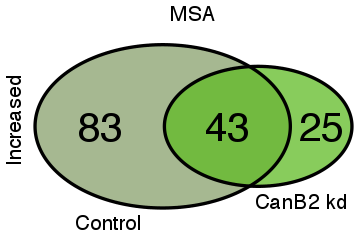

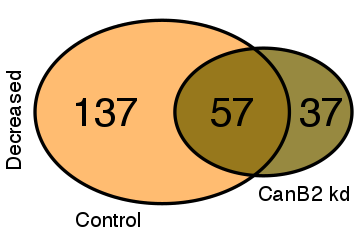

In [137]:
up_candidates <- list(`CanB2 kd` = CanB2_res.eb_upSig.msa.canB, Control = WT_res.eb_upSig.msa.canB)
down_candidates <- list(`CanB2 kd` = CanB2_res.eb_downSig.msa.canB, Control = WT_res.eb_downSig.msa.canB)

up_Vdiag<-venn.diagram(up_candidates, NULL, fill=c("#61bb26", "#88a06c"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, cat.pos = c(-20, 20), cat.dist = c(0.05, 0.05), resolution = 1000)
down_Vdiag<-venn.diagram(down_candidates, NULL, fill=c("#756200", "#ffa642"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, cat.pos = c(-20, 20), cat.dist = c(0.05, 0.05), resolution = 100)

up_combs <- unlist(lapply(1:length(up_candidates), function(j) combn(names(up_candidates), j, simplify = FALSE)), recursive = FALSE)
names(up_combs) <- sapply(up_combs, function(i) paste0(i, collapse = ","))
down_combs <- unlist(lapply(1:length(down_candidates), function(j) combn(names(down_candidates), j, simplify = FALSE)), recursive = FALSE)
names(down_combs) <- sapply(down_combs, function(i) paste0(i, collapse = ","))
    
up_elements <- lapply(up_combs, function(i) Setdiff(up_candidates[i], up_candidates[setdiff(names(up_candidates), i)]))
down_elements <- lapply(down_combs, function(i) Setdiff(down_candidates[i], down_candidates[setdiff(names(down_candidates), i)]))
    
options(repr.plot.width = 3, repr.plot.height = 2)
msaInc_phospep = grid.arrange(gTree(children=up_Vdiag), top = "MSA", left = "Increased")
msaDec_phospep = grid.arrange(gTree(children=down_Vdiag), left = "Decreased")
    
options(repr.plot.width = 3, repr.plot.height = 4)
fig3B_left = plot_grid(msaInc_phospep, msaDec_phospep, ncol = 1)

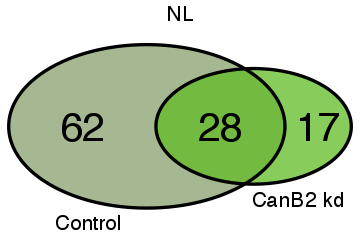

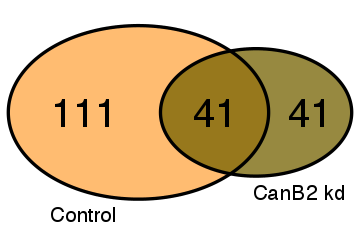

In [138]:
up_candidates <- list(`CanB2 kd` = CanB2_res.eb_upSig.nl.canB, Control = WT_res.eb_upSig.nl.canB)
down_candidates <- list(`CanB2 kd` = CanB2_res.eb_downSig.nl.canB, Control = WT_res.eb_downSig.nl.canB)

up_Vdiag<-venn.diagram(up_candidates, NULL, fill=c("#61bb26", "#88a06c"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, cat.pos = c(-20, 20), cat.dist = c(0.05, 0.05), resolution = 1000)
down_Vdiag<-venn.diagram(down_candidates, NULL, fill=c("#756200", "#ffa642"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, cat.pos = c(-20, 20), cat.dist = c(0.05, 0.05), resolution = 100)

up_combs <- unlist(lapply(1:length(up_candidates), function(j) combn(names(up_candidates), j, simplify = FALSE)), recursive = FALSE)
names(up_combs) <- sapply(up_combs, function(i) paste0(i, collapse = ","))
down_combs <- unlist(lapply(1:length(down_candidates), function(j) combn(names(down_candidates), j, simplify = FALSE)), recursive = FALSE)
names(down_combs) <- sapply(down_combs, function(i) paste0(i, collapse = ","))
    
up_elements <- lapply(up_combs, function(i) Setdiff(up_candidates[i], up_candidates[setdiff(names(up_candidates), i)]))
down_elements <- lapply(down_combs, function(i) Setdiff(down_candidates[i], down_candidates[setdiff(names(down_candidates), i)]))
    
options(repr.plot.width = 3, repr.plot.height = 2)
nlInc_phospep = grid.arrange(gTree(children=up_Vdiag), top = "NL")
nlDec_phospep = grid.arrange(gTree(children=down_Vdiag))

options(repr.plot.width = 3, repr.plot.height = 4)
fig3B_right = plot_grid(nlInc_phospep, nlDec_phospep, ncol = 1)

In [139]:
options(repr.plot.width = 5.5, repr.plot.height = 4)
fig3B = plot_grid(fig3B_left, fig3B_right, ncol = 2, rel_widths = c(1, 0.8))

##### CnAact:

In [140]:
WT_res.eb_upSig.msa.cnA = unique(filter(msa.cnA.peps.comb, peptides.msa.eWT_v_oWT_sig == "YES" & peptides.msa.eWT_v_oWT_log2FC > 0)$peptide_id)
WT_res.eb_downSig.msa.cnA = unique(filter(msa.cnA.peps.comb, peptides.msa.eWT_v_oWT_sig == "YES" & peptides.msa.eWT_v_oWT_log2FC < -0)$peptide_id)
cnA2_res.eb_upSig.msa.cnA = unique(filter(msa.cnA.peps.comb, peptides.msa.eCB_v_oCB_sig == "YES" & peptides.msa.eCB_v_oCB_log2FC > 0)$peptide_id)
cnA2_res.eb_downSig.msa.cnA = unique(filter(msa.cnA.peps.comb, peptides.msa.eCB_v_oCB_sig == "YES" & peptides.msa.eCB_v_oCB_log2FC < -0)$peptide_id)

In [141]:
WT_res.eb_upSig.nl.cnA = unique(filter(nl.cnA.peps.comb, peptides.nl.eWT_v_oWT_sig == "YES" & peptides.nl.eWT_v_oWT_log2FC > 0)$peptide_id)
WT_res.eb_downSig.nl.cnA = unique(filter(nl.cnA.peps.comb, peptides.nl.eWT_v_oWT_sig == "YES" & peptides.nl.eWT_v_oWT_log2FC < -0)$peptide_id)
cnA2_res.eb_upSig.nl.cnA = unique(filter(nl.cnA.peps.comb, peptides.nl.eCB_v_oCB_sig == "YES" & peptides.nl.eCB_v_oCB_log2FC > 0)$peptide_id)
cnA2_res.eb_downSig.nl.cnA = unique(filter(nl.cnA.peps.comb, peptides.nl.eCB_v_oCB_sig == "YES" & peptides.nl.eCB_v_oCB_log2FC < -0)$peptide_id)

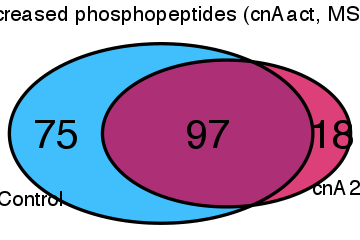

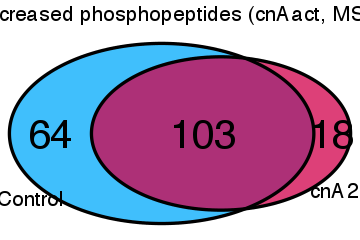

In [142]:
up_candidates <- list(cnA2 = cnA2_res.eb_upSig.msa.cnA, Control =  WT_res.eb_upSig.msa.cnA)
down_candidates <- list(cnA2 = cnA2_res.eb_downSig.msa.cnA, Control =  WT_res.eb_downSig.msa.cnA)

up_Vdiag<-venn.diagram(up_candidates, NULL, fill=c("#d1004b", "#01aafb"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 1000)
down_Vdiag<-venn.diagram(down_candidates, NULL, fill=c("#d1004b", "#01aafb"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100)

up_combs <- unlist(lapply(1:length(up_candidates), function(j) combn(names(up_candidates), j, simplify = FALSE)), recursive = FALSE)
names(up_combs) <- sapply(up_combs, function(i) paste0(i, collapse = ","))
down_combs <- unlist(lapply(1:length(down_candidates), function(j) combn(names(down_candidates), j, simplify = FALSE)), recursive = FALSE)
names(down_combs) <- sapply(down_combs, function(i) paste0(i, collapse = ","))
    
up_elements <- lapply(up_combs, function(i) Setdiff(up_candidates[i], up_candidates[setdiff(names(up_candidates), i)]))
down_elements <- lapply(down_combs, function(i) Setdiff(down_candidates[i], down_candidates[setdiff(names(down_candidates), i)]))
    
options(repr.plot.width = 3, repr.plot.height = 2)
msaInc_phospep = grid.arrange(gTree(children=up_Vdiag), top = "Increased phosphopeptides (cnAact, MSA)")
msaDec_phospep = grid.arrange(gTree(children=down_Vdiag), top = "Decreased phosphopeptides (cnAact, MSA)")

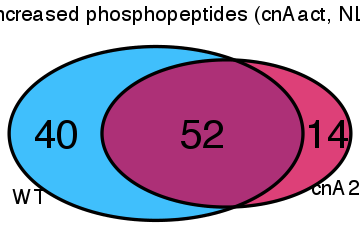

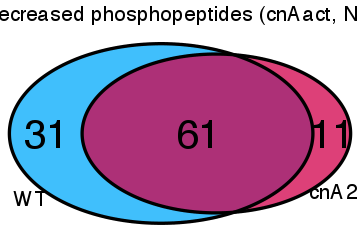

In [143]:
up_candidates <- list(cnA2 = cnA2_res.eb_upSig.nl.cnA, WT = WT_res.eb_upSig.nl.cnA)
down_candidates <- list(cnA2 = cnA2_res.eb_downSig.nl.cnA, WT = WT_res.eb_downSig.nl.cnA)

up_Vdiag<-venn.diagram(up_candidates, NULL, fill=c("#d1004b", "#01aafb"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 1000)
down_Vdiag<-venn.diagram(down_candidates, NULL, fill=c("#d1004b", "#01aafb"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100)

up_combs <- unlist(lapply(1:length(up_candidates), function(j) combn(names(up_candidates), j, simplify = FALSE)), recursive = FALSE)
names(up_combs) <- sapply(up_combs, function(i) paste0(i, collapse = ","))
down_combs <- unlist(lapply(1:length(down_candidates), function(j) combn(names(down_candidates), j, simplify = FALSE)), recursive = FALSE)
names(down_combs) <- sapply(down_combs, function(i) paste0(i, collapse = ","))
    
up_elements <- lapply(up_combs, function(i) Setdiff(up_candidates[i], up_candidates[setdiff(names(up_candidates), i)]))
down_elements <- lapply(down_combs, function(i) Setdiff(down_candidates[i], down_candidates[setdiff(names(down_candidates), i)]))
    
options(repr.plot.width = 3, repr.plot.height = 2)
nlInc_phospep = grid.arrange(gTree(children=up_Vdiag), top = "Increased phosphopeptides (cnAact, NL)")
nlDec_phospep = grid.arrange(gTree(children=down_Vdiag), top = "Decreased phosphopeptides (cnAact, NL)")

#### GO analysis:

In [144]:
canB.abnormal.GO = read.csv(file = "Results/canB.union.abnormal.proteins.DAVID.min5prots.txt", header = T, sep = "\t", check.names = F)
canB.normal.GO = read.csv(file = "Results/canB.union.normal.proteins.DAVID.min5prots.txt", header = T, sep = "\t", check.names = F)

sig.BP.abnormal.GO = filter(canB.abnormal.GO, Benjamini < 0.05 & Category == "GOTERM_BP_DIRECT")
sig.BP.abnormal.GO$phosphostate = "misregulated"

sig.BP.normal.GO = filter(canB.normal.GO, Benjamini < 0.05 & Category == "GOTERM_BP_DIRECT")
sig.BP.normal.GO$phosphostate = "normal"

sig.BP.GO = rbind(sig.BP.abnormal.GO, sig.BP.normal.GO)
sig.BP.GO$`Biological Process` = gsub(".*~", "", sig.BP.GO$Term)
head(sig.BP.GO, n = 2)

Category         Term                                Count %        
1 GOTERM_BP_DIRECT GO:0007067~mitotic nuclear division 17     7.657658
2 GOTERM_BP_DIRECT GO:0022008~neurogenesis             28    12.612613
  PValue      
1 5.567351e-09
2 5.568490e-06
  Genes                                                                                                                                                                                                                         
1 E1JIK0, Q9VCN6, P13496, P25028, A0A0B4JD97, P40688, Q9VUI0, P23572, Q9VZ20, Q9VUB8, P52304, P05205, Q9VC45, A8DZ29, Q95TN8, Q24044, A0A0C4DHG5                                                                                
2 E1JIK0, P35600, Q7JRJ9, P13496, F6J1D0, Q9W2U4, Q9VBB3, P23572, Q9W3R9, X2JEX8, Q9VKU2, Q9VN58, Q05344, P05205, M9NCZ5, Q24044, P49847, Q9VCN6, P02844, A8JV18, Q8MQX9, P52304, Q9VM76, Q9V3W7, Q9VP57, Q7K0D8, A1Z6I7, Q9VZ62
  List Total Pop Hits Pop Total Fold Enrichment Bonferroni  Benjamini   
1 205        139      10996     6.560168        4.16437e-06 4.164370e-06
2 205        565      10996     2.658217        4.15658e-03 2.080454e-03
  FDR          phosphostate Biological Process      
1 8.470427e-06 misregulated mitotic nuclear division
2 8.471825e-03 misregulated neurogenesis

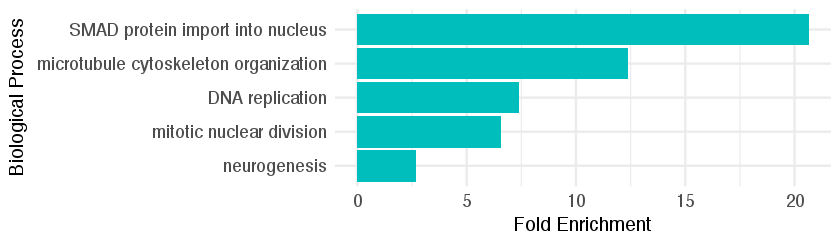

In [145]:
options(repr.plot.width = 7, repr.plot.height = 2)
(fig3C = ggplot(filter(sig.BP.GO, phosphostate == "misregulated"), aes(reorder(`Biological Process`, `Fold Enrichment`), `Fold Enrichment`)) + 
    geom_bar(stat = "identity", fill = "#00bebb") +
    coord_flip() +
#     facet_grid(phosphostate~., space = "free_y") +
    labs(x = "Biological Process") +
    theme_minimal() +
    theme(axis.text = element_text(face="bold", size = 10)))
# sig.MF.abnormal.GO = filter(canB.abnormal.GO, Benjamini < 0.05 & Category == "GOTERM_MF_DIRECT")
# sig.MF.normal.GO = filter(canB.normal.GO, Benjamini < 0.05 & Category == "GOTERM_MF_DIRECT")
# sig.CC.abnormal.GO = filter(canB.abnormal.GO, Benjamini < 0.05 & Category == "GOTERM_BP_DIRECT")
# sig.CC.normal.GO = filter(canB.normal.GO, Benjamini < 0.05 & Category == "GOTERM_CC_DIRECT")

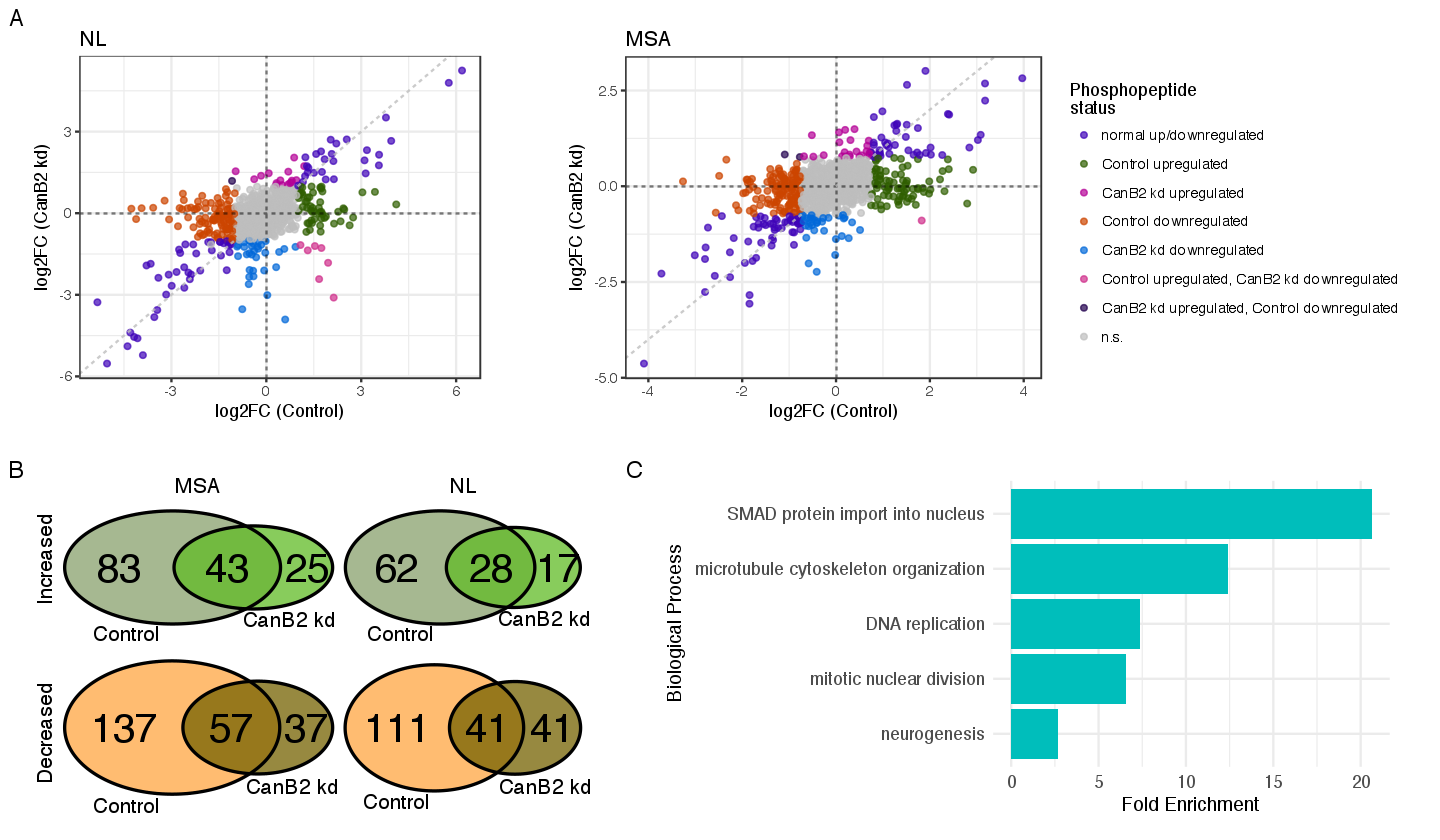

In [146]:
options(repr.plot.width = 12, repr.plot.height = 7)
# pdf("manuscript/Figures/Figure_3.pdf", width = 12, height = 7)
# figTop3 = suppressWarnings(plot_grid(fig3A, fig3B, rel_widths = c(1, 0.5), ncol = 2, labels = c("A", "B"), scale = c(0.90, 0.90)))
figBottom3 = suppressWarnings(plot_grid(fig3B, fig3C, rel_widths = c(0.75, 1), ncol = 2, labels = c("B", "C"), scale = c(0.90, 0.90)))
plot_grid(fig3A, figBottom3, ncol = 1, scale = c(1,1), labels = c("A", ""), rel_heights = c(1.4, 1.2))
# plot_grid(fig3A, fig3B, fig3C, fig3D,labels = c("A", "B", "C", "D"), ncol = 2, scale = c(0.9,0.9,0.9,0.9))
# dev.off()

In [147]:
Oocyte.GO = read.csv(file = "Results/Oocyte_canB_v_control_sigPhproteins.DAVID.txt", header = T, sep = "\t", check.names = F)

sig.Oocyte.GO = filter(Oocyte.GO, Benjamini < 0.05 & grepl("GOTERM", Category))

sig.Oocyte.GO$`GO term` = gsub(".*~", "", sig.Oocyte.GO$Term)
sig.Oocyte.GO$Ontology = ifelse(sig.Oocyte.GO$Category == "GOTERM_CC_DIRECT", "CC", ifelse(sig.Oocyte.GO$Category == "GOTERM_MF_DIRECT", "MF", "BP"))
sig.Oocyte.GO

Category        
1  GOTERM_CC_DIRECT
2  GOTERM_MF_DIRECT
3  GOTERM_BP_DIRECT
4  GOTERM_CC_DIRECT
5  GOTERM_CC_DIRECT
6  GOTERM_MF_DIRECT
7  GOTERM_MF_DIRECT
8  GOTERM_CC_DIRECT
9  GOTERM_BP_DIRECT
10 GOTERM_CC_DIRECT
11 GOTERM_MF_DIRECT
12 GOTERM_CC_DIRECT
   Term                                                           Count
1  GO:0005875~microtubule associated complex                      10   
2  GO:0005515~protein binding                                     12   
3  GO:0006413~translational initiation                             5   
4  GO:0005737~cytoplasm                                           17   
5  GO:0005811~lipid particle                                       8   
6  GO:0003723~RNA binding                                          8   
7  GO:0042393~histone binding                                      4   
8  GO:0043186~P granule                                            4   
9  GO:0006260~DNA replication                                      4   
10 GO:0016281~eukaryotic translation initiation factor 4F complex  3   
11 GO:0003743~translation initiation factor activity               4   
12 GO:0005829~cytosol                                             10   
   %         PValue      
1  23.809524 7.884923e-07
2  28.571429 1.538580e-05
3  11.904762 1.699125e-05
4  40.476190 3.373382e-05
5  19.047619 4.781237e-05
6  19.047619 5.573166e-05
7   9.523810 1.202626e-04
8   9.523810 2.571536e-04
9   9.523810 6.024904e-04
10  7.142857 9.537832e-04
11  9.523810 1.186667e-03
12 23.809524 1.498454e-03
   Genes                                                                                                                                         
1  M9PF20, P23128, Q9VK59, P35600, Q7KUX7, A0A0B4KGU4, E1JGK5, A0A0B4K7J2, X2J9P9, Q7KN62                                                        
2  M9PF20, Q9W4M7, P23128, A1Z7K9, Q9VSD6, P20240, Q24572, Q05344, P05205, X2J9P9, Q9V444, Q7KN62                                                
3  A1Z968, Q7KUX7, A0A0B4KGU4, Q7PLL3, A8DZ29                                                                                                    
4  Q9VSD6, P20240, P13496, X2J9P9, P25822, A0A0B4KF69, P02828, P23128, X2J4N6, O16043, Q9VLL3, Q9VK59, Q9XZ32, A0A0B4KGU4, E1JGK5, E1JHT6, Q7KN62
5  P02828, A0A0B4KFV2, Q9VLL3, A0A0B4KGU4, Q9VWS2, A0A0B4K7J2, E1JHT6, Q7KN62                                                                    
6  P23128, A1Z968, Q05344, P05205, A0A0B4KGU4, X2J9P9, A8DZ29, P25822                                                                            
7  O16043, Q24572, P05205, E1JGK5                                                                                                                
8  M9PF20, P23128, A0A0B4KGU4, Q7KN62                                                                                                            
9  A0A0B4LEV2, P35600, Q05344, Q7K2L1                                                                                                            
10 Q7KUX7, Q7PLL3, A8DZ29                                                                                                                        
11 A1Z968, Q7KUX7, Q7PLL3, A8DZ29                                                                                                                
12 M9PF20, Q9VSD6, O97428, Q7KUX7, A0A0B4KGU4, Q7PLL3, X2J9P9, A8DZ29, E1JHT6, Q9W0L7                                                            
   List Total Pop Hits Pop Total Fold Enrichment Bonferroni   Benjamini   
1  37          300     10026      9.032432       7.490399e-05 7.490399e-05
2  36          647      9284      4.783101       1.199382e-03 1.199382e-03
3  37           48     10996     30.957207       3.968092e-03 3.968092e-03
4  37         1553     10026      2.966221       3.199637e-03 1.601100e-03
5  37          277     10026      7.825934       4.531984e-03 1.512949e-03
6  36          271      9284      7.612956       4.337755e-03 2.171235e-03
7  36           26      9284     39.675214    

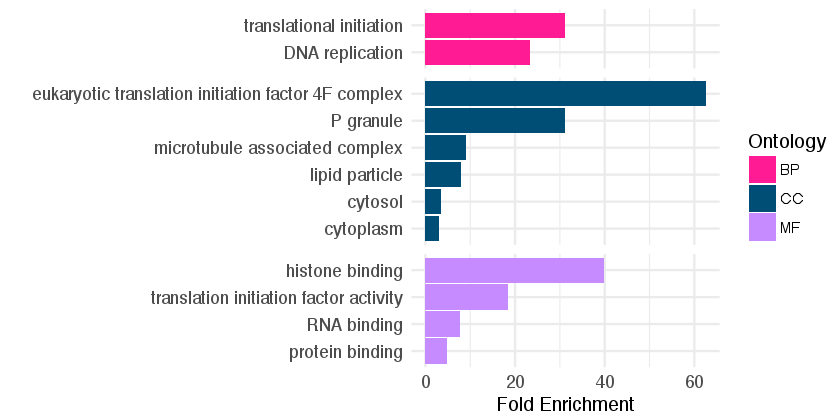

In [148]:
options(repr.plot.width = 7, repr.plot.height = 3.5)
(fig4B = ggplot(sig.Oocyte.GO, aes(reorder(`GO term`, `Fold Enrichment`), `Fold Enrichment`, fill = Ontology)) + 
    geom_bar(stat = "identity") +
    coord_flip() +
    facet_grid(Ontology~., scale = "free_y", space = "free") +
    theme_minimal() +
    theme(axis.text = element_text(face="bold", size = 10), strip.text = element_blank(), axis.title.y = element_blank()) +
    scale_fill_manual(values = c("#ff1b94",
"#004e75",
"#c58bff")))
# sig.MF.abnormal.GO = filter(canB.abnormal.GO, Benjamini < 0.05 & Category == "GOTERM_MF_DIRECT")
# sig.MF.normal.GO = filter(canB.normal.GO, Benjamini < 0.05 & Category == "GOTERM_MF_DIRECT")
# sig.CC.abnormal.GO = filter(canB.abnormal.GO, Benjamini < 0.05 & Category == "GOTERM_BP_DIRECT")
# sig.CC.normal.GO = filter(canB.normal.GO, Benjamini < 0.05 & Category == "GOTERM_CC_DIRECT")

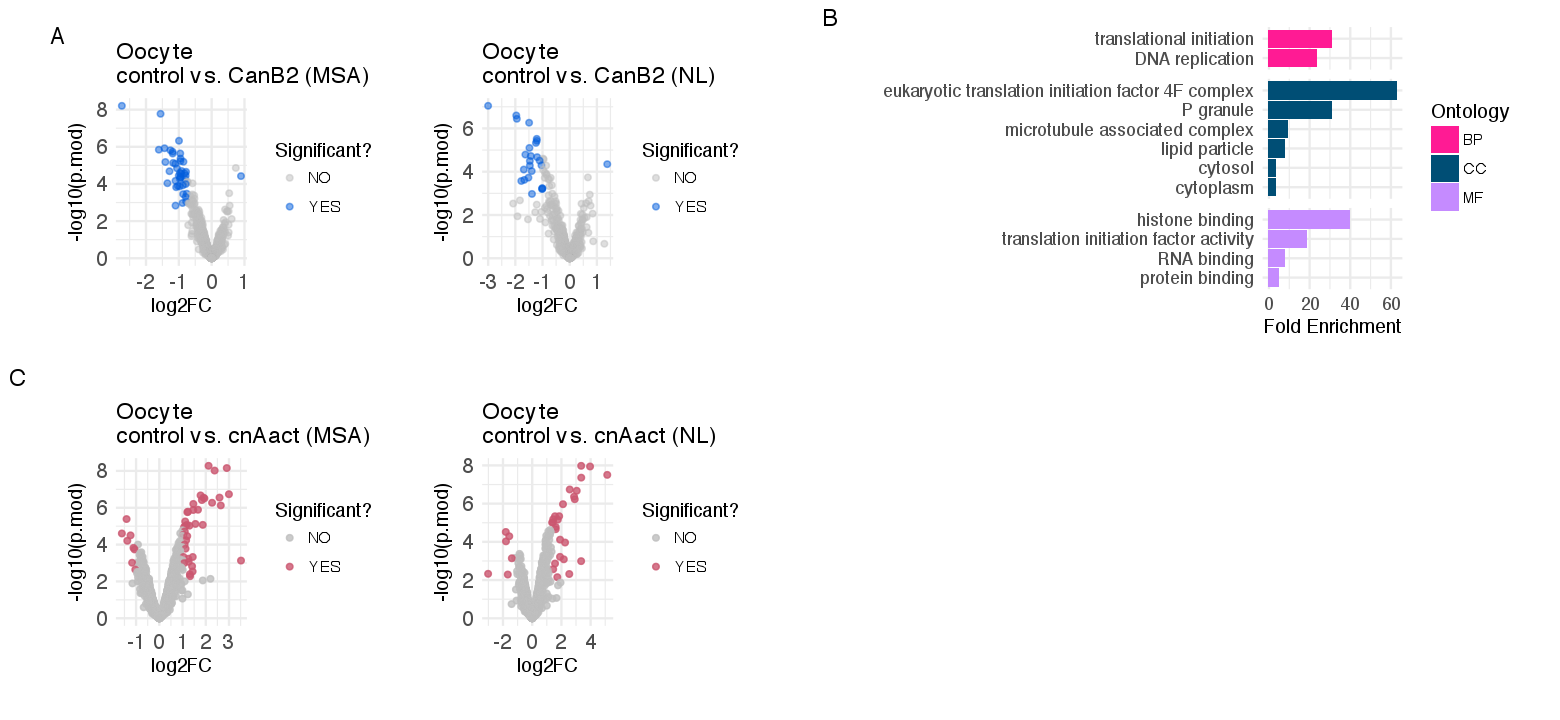

In [149]:
options(repr.plot.width = 13, repr.plot.height = 6)
# fig4_left = plot_grid(fig4A, fig4C, labels = c("", "C"), ncol = 1)
# pdf("manuscript/Figures/Figure_4.pdf", width = 13, height = 6)
# plot_grid(fig4_left, fig4B, ncol = 2, labels = c("", "B"), scale = c(0.9,0.75), rel_widths = c(0.7, 1))
plot_grid(fig4A, fig4B, fig4C, NULL, ncol = 2, labels = c("", "B", "C", ""), scale = c(0.9,0.9, 0.9, 0.0), rel_widths = c(1.2, 1.1))
# dev.off()

### Creating individual peptide/protein plots

In [ ]:
# canB_upregulated.peps = subset(msa.canB.peps.comb, PEPtransition == "wildtype upregulated")$peptide_id
# canB_upregulated.prots = as.character(unique(subset(msa.canB.peps.comb, PEPtransition == "wildtype upregulated")$Accession))
# sampleOne = canB_phosphopeptides.msa.se
# sampleOne$Status = ifelse(sampleOne$peptide_id %in% canB_upregulated.peps, "**", "")
# pdf("Results/peptidePlots.msa_CanB_wildtype_upregulated.pdf", width = 12, height = 7)
# lapply(canB_upregulated.prots, PlotPhosphoPeps)
# dev.off()

In [ ]:
# canB_upregulated.peps = subset(msa.canB.peps.comb, PEPtransition == "CanB2 upregulated")$peptide_id
# canB_upregulated.prots = as.character(unique(subset(msa.canB.peps.comb, PEPtransition == "CanB2 upregulated")$Accession))
# sampleOne = canB_phosphopeptides.msa.se
# sampleOne$Status = ifelse(sampleOne$peptide_id %in% canB_upregulated.peps, "**", "")
# pdf("Results/peptidePlots.msa_CanB_mutant_upregulated.pdf", width = 12, height = 7)
# lapply(canB_upregulated.prots, PlotPhosphoPeps)
# dev.off()

In [ ]:
# canB_downregulated.peps = subset(msa.canB.peps.comb, PEPtransition == "wildtype downregulated")$peptide_id
# canB_downregulated.prots = as.character(unique(subset(msa.canB.peps.comb, PEPtransition == "wildtype downregulated")$Accession))
# sampleOne = canB_phosphopeptides.msa.se
# sampleOne$Status = ifelse(sampleOne$peptide_id %in% canB_downregulated.peps, "**", "")
# pdf("Results/peptidePlots.msa_CanB_wildtype_downregulated.pdf", width = 12, height = 7)
# lapply(canB_downregulated.prots, PlotPhosphoPeps)
# dev.off()

In [ ]:
# canB_downregulated.peps = subset(msa.canB.peps.comb, PEPtransition == "CanB2 downregulated")$peptide_id
# canB_downregulated.prots = as.character(unique(subset(msa.canB.peps.comb, PEPtransition == "CanB2 downregulated")$Accession))
# sampleOne = canB_phosphopeptides.msa.se
# sampleOne$Status = ifelse(sampleOne$peptide_id %in% canB_downregulated.peps, "**", "")
# pdf("Results/peptidePlots.msa_CanB_mutant_downregulated.pdf", width = 12, height = 7)
# lapply(canB_downregulated.prots, PlotPhosphoPeps)
# dev.off()

In [312]:
kinases

[1] "A0A0B4KFU0" "Q9VLL3"     "Q9VXE3"     "D1YSG8"     "Q960X8"    
 [6] "Q9W1B0"     "P81900"     "A8DY76"     "Q540Z9"     "Q9VJ30"    
[11] "P40417"     "P52304"     "Q9VPC0"     "P23572"     "D3DML3"    
[16] "A1Z6I7"

Warning message:
“Removed 8 rows containing missing values (geom_bar).”Warning message:
“Removed 8 rows containing missing values (geom_errorbar).”

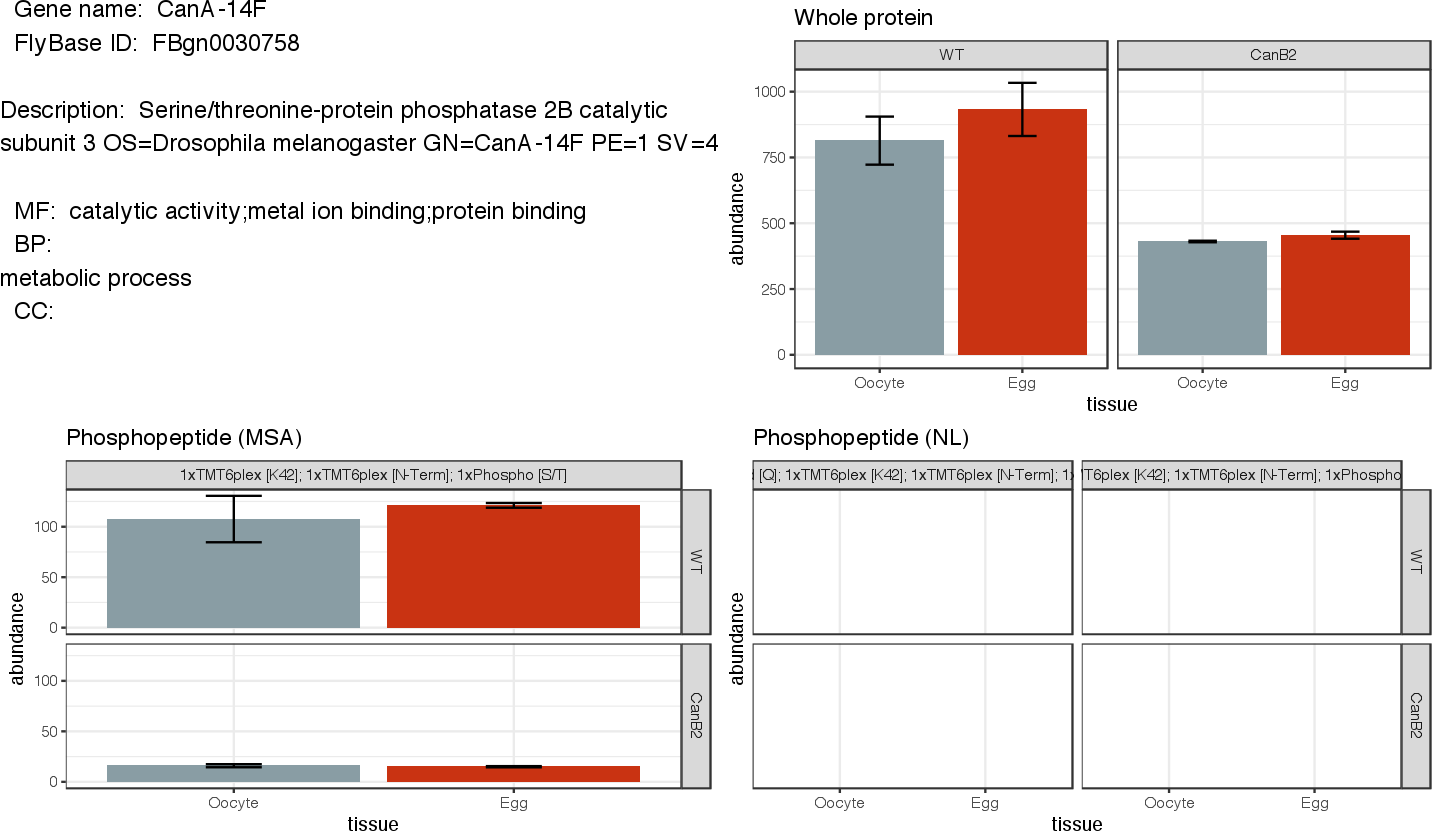

In [268]:
options(repr.plot.width = 12, repr.plot.height = 7)
PlotPhosphoPeps("Q9VXF1")

### Inter-replicate comparisons

In [151]:
canB.peps.msa = read.csv(file = "Source_files/Zijing10393887_TMT10plex_MSA_SPSMS3_2repRuns4_9ratiosPhophoPeptides Only.txt", header = T, sep = "\t", check.name = F)

canB.peps.nl = read.csv(file = "Source_files/Zijing10393887_TMT10plex_NL_SPSMS3_2ReprunsPhosphoPeptidesOnly.txt", header = T, sep = "\t", check.name = F)

cnA.peps.msa = read.csv(file = "Source_files/Zhijing10397862_TMT10plex_MSA_SPSMS3_2repRuns4_9ratios-phosphopeptidesonly(1) (1).txt", header = T, sep = "\t", check.name = F)
cnA.peps.nl = read.csv(file = "Source_files/Zhijing10397862_TMT10plex_NL_SPSMS3_2Repruns-4to9ratio_phosphopeptidesonly1 (1).txt", header = T, sep = "\t", check.name = F)

In [152]:
canB.peps.msa_abundances = select(canB.peps.msa, contains("Abundance: F1"))
colnames(canB.peps.msa_abundances) = gsub("Abundance: F1: ", "X", colnames(canB.peps.msa_abundances))
colnames(canB.peps.msa_abundances) = gsub(", Sample, ", "_", colnames(canB.peps.msa_abundances))
colnames(canB.peps.msa_abundances) = gsub(" ", "_", colnames(canB.peps.msa_abundances))
colnames(canB.peps.msa_abundances) = gsub("_n.*a,_", "_", colnames(canB.peps.msa_abundances))
colnames(canB.peps.msa_abundances) = gsub("__", "_", colnames(canB.peps.msa_abundances))
# head(canB.peps.msa_abundances)

In [153]:
canB.peps.nl_abundances = select(canB.peps.nl, contains("Abundance: F4"))
colnames(canB.peps.nl_abundances) = gsub("Abundance: F4: ", "X", colnames(canB.peps.nl_abundances))
colnames(canB.peps.nl_abundances) = gsub(", Sample, ", "_", colnames(canB.peps.nl_abundances))
colnames(canB.peps.nl_abundances) = gsub(" ", "_", colnames(canB.peps.nl_abundances))
colnames(canB.peps.nl_abundances) = gsub("_n.*a,_", "_", colnames(canB.peps.nl_abundances))
colnames(canB.peps.nl_abundances) = gsub("__", "_", colnames(canB.peps.nl_abundances))
# head(canB.peps.nl_abundances)

In [154]:
canB.peps.nl_abundances = select(canB.peps.nl, contains("Abundance: F4"))
colnames(canB.peps.nl_abundances) = gsub("Abundance: F4: ", "X", colnames(canB.peps.nl_abundances))
colnames(canB.peps.nl_abundances) = gsub(", Sample, ", "_", colnames(canB.peps.nl_abundances))
colnames(canB.peps.nl_abundances) = gsub(" ", "_", colnames(canB.peps.nl_abundances))
colnames(canB.peps.nl_abundances) = gsub("_n.*a,_", "_", colnames(canB.peps.nl_abundances))
colnames(canB.peps.nl_abundances) = gsub("__", "_", colnames(canB.peps.nl_abundances))
# head(canB.peps.nl_abundances)

In [155]:
canB_proteins_customLimma = select(canB_proteins, c("Accession", "Description", "# Peptides", "# PSMs", "# Unique Peptides"))

canB_proteins_abundances = select(canB_proteins, contains("Abundance: F5"))
colnames(canB_proteins_abundances) = gsub("Abundance: F5: ", "X", colnames(canB_proteins_abundances))
colnames(canB_proteins_abundances) = gsub(", Sample, ", "_", colnames(canB_proteins_abundances))
colnames(canB_proteins_abundances) = gsub(" ", "_", colnames(canB_proteins_abundances))
colnames(canB_proteins_abundances) = gsub("_n.*a,_", "_", colnames(canB_proteins_abundances))
colnames(canB_proteins_abundances) = gsub("__", "_", colnames(canB_proteins_abundances))

In [156]:
canB.peps.msa_abs = canB.peps.msa_abundances[complete.cases(canB.peps.msa_abundances), ]
canB.peps.nl_abs = canB.peps.nl_abundances[complete.cases(canB.peps.nl_abundances), ]
canB.prots_abs = canB_proteins_abundances[complete.cases(canB_proteins_abundances), ]

In [157]:
canB_oocyte_1_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.msa_abs[, "X127N_Oocyte_CanB2"], canB.peps.msa_abs[, "X128N_Oocyte_CanB2"]))
canB_oocyte_2_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.msa_abs[, "X127N_Oocyte_CanB2"], canB.peps.msa_abs[, "X128C_Oocyte_CanB2"]))
canB_oocyte_3_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.msa_abs[, "X128N_Oocyte_CanB2"], canB.peps.msa_abs[, "X128C_Oocyte_CanB2"]))
Control_oocyte_corr_label = data.frame(x = 7.5, y = 3.5, label = corr_eqn(canB.peps.msa_abs[, "X126_Oocyte_WT"], canB.peps.msa_abs[, "X127C_Oocyte_WT"]))

canB_oocyte_1 = ggplot(canB.peps.msa_abs, aes(log2(X127N_Oocyte_CanB2), log2(X128N_Oocyte_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#5ba965") + 
        labs(x = "CanB2 kd oocyte (rep 1)", y = "CanB2 kd oocyte (rep 2)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_oocyte_1_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

canB_oocyte_2 = ggplot(canB.peps.msa_abs, aes(log2(X127N_Oocyte_CanB2), log2(X128C_Oocyte_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#5ba965") + 
        labs(x = "CanB2 kd oocyte (rep 1)", y = "CanB2 kd oocyte (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_oocyte_2_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

canB_oocyte_3 = ggplot(canB.peps.msa_abs, aes(log2(X128N_Oocyte_CanB2), log2(X128C_Oocyte_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#5ba965") + 
        labs(x = "CanB2 kd oocyte (rep 2)", y = "CanB2 kd oocyte (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_oocyte_3_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

Control_oocyte = ggplot(canB.peps.msa_abs, aes(log2(X126_Oocyte_WT), log2(X127C_Oocyte_WT))) + 
        geom_point(alpha = 0.2, colour = "#5ba965") + 
        labs(x = "Control oocyte (rep 1)", y = "Control oocyte (rep 2)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = Control_oocyte_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

options(repr.plot.width = 3.5, repr.plot.height = 10)
canB_oocytes_msa = plot_grid(canB_oocyte_1, canB_oocyte_2, canB_oocyte_3, Control_oocyte, ncol = 1, align = "v", labels = c("A", "", ""), scale = c(0.9, 0.9, 0.9, 0.9))

In [158]:
canB_egg_1_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.msa_abs[, "X130N_Egg_CanB2"], canB.peps.msa_abs[, "X130C_Egg_CanB2"]))
canB_egg_2_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.msa_abs[, "X130N_Egg_CanB2"], canB.peps.msa_abs[, "X131_Egg_CanB2"]))
canB_egg_3_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.msa_abs[, "X130C_Egg_CanB2"], canB.peps.msa_abs[, "X131_Egg_CanB2"]))
Control_egg_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.msa_abs[, "X129N_Egg_WT"], canB.peps.msa_abs[, "X129C_Egg_WT"]))

canB_egg_1 = ggplot(canB.peps.msa_abs, aes(log2(X130N_Egg_CanB2), log2(X130C_Egg_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#c15ca5") + 
        labs(x = "CanB2 kd egg (rep 1)", y = "CanB2 kd egg (rep 2)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_egg_1_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

canB_egg_2 = ggplot(canB.peps.msa_abs, aes(log2(X130N_Egg_CanB2), log2(X131_Egg_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#c15ca5") + 
        labs(x = "CanB2 kd egg (rep 1)", y = "CanB2 kd egg (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_egg_2_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

canB_egg_3 = ggplot(canB.peps.msa_abs, aes(log2(X130C_Egg_CanB2), log2(X131_Egg_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#c15ca5") + 
        labs(x = "CanB2 kd egg (rep 2)", y = "CanB2 kd egg (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_egg_3_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

Control_egg = ggplot(canB.peps.msa_abs, aes(log2(X129N_Egg_WT), log2(X129C_Egg_WT))) + 
        geom_point(alpha = 0.2, colour = "#c15ca5") + 
        labs(x = "Control egg (rep 1)", y = "Control egg (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = Control_egg_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

options(repr.plot.width = 3.5, repr.plot.height = 10)
canB_eggs_msa = plot_grid(canB_egg_1, canB_egg_2, canB_egg_3, Control_egg, ncol = 1, align = "v", labels = c("B", "", "", ""), scale = c(0.9, 0.9, 0.9, 0.9))

In [160]:
# options(repr.plot.width = 14, repr.plot.height = 10)
# plot_grid(canB_oocytes_msa, canB_eggs_msa, ncol = 4)

In [161]:
canB_oocyte_1_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.nl_abs[, "X127N_Oocyte_CanB2"], canB.peps.nl_abs[, "X128N_Oocyte_CanB2"]))
canB_oocyte_2_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.nl_abs[, "X127N_Oocyte_CanB2"], canB.peps.nl_abs[, "X128C_Oocyte_CanB2"]))
canB_oocyte_3_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.nl_abs[, "X128N_Oocyte_CanB2"], canB.peps.nl_abs[, "X128C_Oocyte_CanB2"]))
Control_oocyte_corr_label = data.frame(x = 7.5, y = 3.5, label = corr_eqn(canB.peps.nl_abs[, "X126_Oocyte_WT"], canB.peps.nl_abs[, "X127C_Oocyte_WT"]))

canB_oocyte_1 = ggplot(canB.peps.nl_abs, aes(log2(X127N_Oocyte_CanB2), log2(X128N_Oocyte_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#5ba965") + 
        labs(x = "CanB2 kd oocyte (rep 1)", y = "CanB2 kd oocyte (rep 2)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_oocyte_1_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

canB_oocyte_2 = ggplot(canB.peps.nl_abs, aes(log2(X127N_Oocyte_CanB2), log2(X128C_Oocyte_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#5ba965") + 
        labs(x = "CanB2 kd oocyte (rep 1)", y = "CanB2 kd oocyte (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_oocyte_2_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

canB_oocyte_3 = ggplot(canB.peps.nl_abs, aes(log2(X128N_Oocyte_CanB2), log2(X128C_Oocyte_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#5ba965") + 
        labs(x = "CanB2 kd oocyte (rep 2)", y = "CanB2 kd oocyte (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_oocyte_3_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

Control_oocyte = ggplot(canB.peps.nl_abs, aes(log2(X126_Oocyte_WT), log2(X127C_Oocyte_WT))) + 
        geom_point(alpha = 0.2, colour = "#5ba965") + 
        labs(x = "Control oocyte (rep 1)", y = "Control oocyte (rep 2)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = Control_oocyte_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

options(repr.plot.width = 3.5, repr.plot.height = 10)
canB_oocytes_nl = plot_grid(canB_oocyte_1, canB_oocyte_2, canB_oocyte_3, Control_oocyte, ncol = 1, align = "v", labels = c("C", "", ""), scale = c(0.9, 0.9, 0.9, 0.9))

In [162]:
canB_egg_1_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.nl_abs[, "X130N_Egg_CanB2"], canB.peps.nl_abs[, "X130C_Egg_CanB2"]))
canB_egg_2_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.nl_abs[, "X130N_Egg_CanB2"], canB.peps.nl_abs[, "X131_Egg_CanB2"]))
canB_egg_3_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.nl_abs[, "X130C_Egg_CanB2"], canB.peps.nl_abs[, "X131_Egg_CanB2"]))
Control_egg_corr_label = data.frame(x = 7.5, y = 2.5, label = corr_eqn(canB.peps.nl_abs[, "X129N_Egg_WT"], canB.peps.nl_abs[, "X129C_Egg_WT"]))

canB_egg_1 = ggplot(canB.peps.nl_abs, aes(log2(X130N_Egg_CanB2), log2(X130C_Egg_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#c15ca5") + 
        labs(x = "CanB2 kd egg (rep 1)", y = "CanB2 kd egg (rep 2)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_egg_1_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

canB_egg_2 = ggplot(canB.peps.nl_abs, aes(log2(X130N_Egg_CanB2), log2(X131_Egg_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#c15ca5") + 
        labs(x = "CanB2 kd egg (rep 1)", y = "CanB2 kd egg (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_egg_2_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

canB_egg_3 = ggplot(canB.peps.nl_abs, aes(log2(X130C_Egg_CanB2), log2(X131_Egg_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#c15ca5") + 
        labs(x = "CanB2 kd egg (rep 2)", y = "CanB2 kd egg (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_egg_3_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

Control_egg = ggplot(canB.peps.nl_abs, aes(log2(X129N_Egg_WT), log2(X129C_Egg_WT))) + 
        geom_point(alpha = 0.2, colour = "#c15ca5") + 
        labs(x = "Control egg (rep 1)", y = "Control egg (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = Control_egg_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

options(repr.plot.width = 3.5, repr.plot.height = 10)
canB_eggs_nl = plot_grid(canB_egg_1, canB_egg_2, canB_egg_3, Control_egg, ncol = 1, align = "v", labels = c("D", "", "", ""), scale = c(0.9, 0.9, 0.9, 0.9))

In [163]:
# options(repr.plot.width = 14, repr.plot.height = 10)
# plot_grid(canB_oocytes_msa, canB_eggs_msa, canB_oocytes_nl, canB_eggs_nl, ncol = 4)

In [164]:
canB_oocyte_1_corr_label = data.frame(x = 12, y = 5, label = corr_eqn(canB.prots_abs[, "X127N_Oocyte_CanB2"], canB.prots_abs[, "X128N_Oocyte_CanB2"]))
canB_oocyte_2_corr_label = data.frame(x = 12, y = 5, label = corr_eqn(canB.prots_abs[, "X127N_Oocyte_CanB2"], canB.prots_abs[, "X128C_Oocyte_CanB2"]))
canB_oocyte_3_corr_label = data.frame(x = 12, y = 5, label = corr_eqn(canB.prots_abs[, "X128N_Oocyte_CanB2"], canB.prots_abs[, "X128C_Oocyte_CanB2"]))
Control_oocyte_corr_label = data.frame(x = 12, y = 5, label = corr_eqn(canB.prots_abs[, "X126_Oocyte_WT"], canB.prots_abs[, "X127C_Oocyte_WT"]))

canB_oocyte_1 = ggplot(canB.prots_abs, aes(log2(X127N_Oocyte_CanB2), log2(X128N_Oocyte_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#5ba965") + 
        labs(x = "CanB2 kd oocyte (rep 1)", y = "CanB2 kd oocyte (rep 2)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_oocyte_1_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

canB_oocyte_2 = ggplot(canB.prots_abs, aes(log2(X127N_Oocyte_CanB2), log2(X128C_Oocyte_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#5ba965") + 
        labs(x = "CanB2 kd oocyte (rep 1)", y = "CanB2 kd oocyte (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_oocyte_2_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

canB_oocyte_3 = ggplot(canB.prots_abs, aes(log2(X128N_Oocyte_CanB2), log2(X128C_Oocyte_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#5ba965") + 
        labs(x = "CanB2 kd oocyte (rep 2)", y = "CanB2 kd oocyte (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_oocyte_3_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

Control_oocyte = ggplot(canB.prots_abs, aes(log2(X126_Oocyte_WT), log2(X127C_Oocyte_WT))) + 
        geom_point(alpha = 0.2, colour = "#5ba965") + 
        labs(x = "Control oocyte (rep 1)", y = "Control oocyte (rep 2)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = Control_oocyte_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

options(repr.plot.width = 3.5, repr.plot.height = 10)
canB_oocytes = plot_grid(canB_oocyte_1, canB_oocyte_2, canB_oocyte_3, Control_oocyte, ncol = 1, align = "v", labels = c("E", "", ""), scale = c(0.9, 0.9, 0.9, 0.9))

In [165]:
canB_egg_1_corr_label = data.frame(x = 12, y = 5, label = corr_eqn(canB.prots_abs[, "X130N_Egg_CanB2"], canB.prots_abs[, "X130C_Egg_CanB2"]))
canB_egg_2_corr_label = data.frame(x = 12, y = 5, label = corr_eqn(canB.prots_abs[, "X130N_Egg_CanB2"], canB.prots_abs[, "X131_Egg_CanB2"]))
canB_egg_3_corr_label = data.frame(x = 12, y = 5, label = corr_eqn(canB.prots_abs[, "X130C_Egg_CanB2"], canB.prots_abs[, "X131_Egg_CanB2"]))
Control_egg_corr_label = data.frame(x = 12, y = 5, label = corr_eqn(canB.prots_abs[, "X129N_Egg_WT"], canB.prots_abs[, "X129C_Egg_WT"]))

canB_egg_1 = ggplot(canB.prots_abs, aes(log2(X130N_Egg_CanB2), log2(X130C_Egg_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#c15ca5") + 
        labs(x = "CanB2 kd egg (rep 1)", y = "CanB2 kd egg (rep 2)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_egg_1_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

canB_egg_2 = ggplot(canB.prots_abs, aes(log2(X130N_Egg_CanB2), log2(X131_Egg_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#c15ca5") + 
        labs(x = "CanB2 kd egg (rep 1)", y = "CanB2 kd egg (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_egg_2_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

canB_egg_3 = ggplot(canB.prots_abs, aes(log2(X130C_Egg_CanB2), log2(X131_Egg_CanB2))) + 
        geom_point(alpha = 0.2, colour = "#c15ca5") + 
        labs(x = "CanB2 kd egg (rep 2)", y = "CanB2 kd egg (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = canB_egg_3_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 5) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

Control_egg = ggplot(canB.prots_abs, aes(log2(X129N_Egg_WT), log2(X129C_Egg_WT))) + 
        geom_point(alpha = 0.2, colour = "#c15ca5") + 
        labs(x = "Control egg (rep 1)", y = "Control egg (rep 3)") +
        geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
        geom_text(data = Control_egg_corr_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic", size = 6) +
        theme_light() +
        theme(axis.text = element_text(size = 12))

options(repr.plot.width = 3.5, repr.plot.height = 10)
canB_eggs = plot_grid(canB_egg_1, canB_egg_2, canB_egg_3, Control_egg, ncol = 1, align = "v", labels = c("F", "", "", ""), scale = c(0.9, 0.9, 0.9, 0.9))

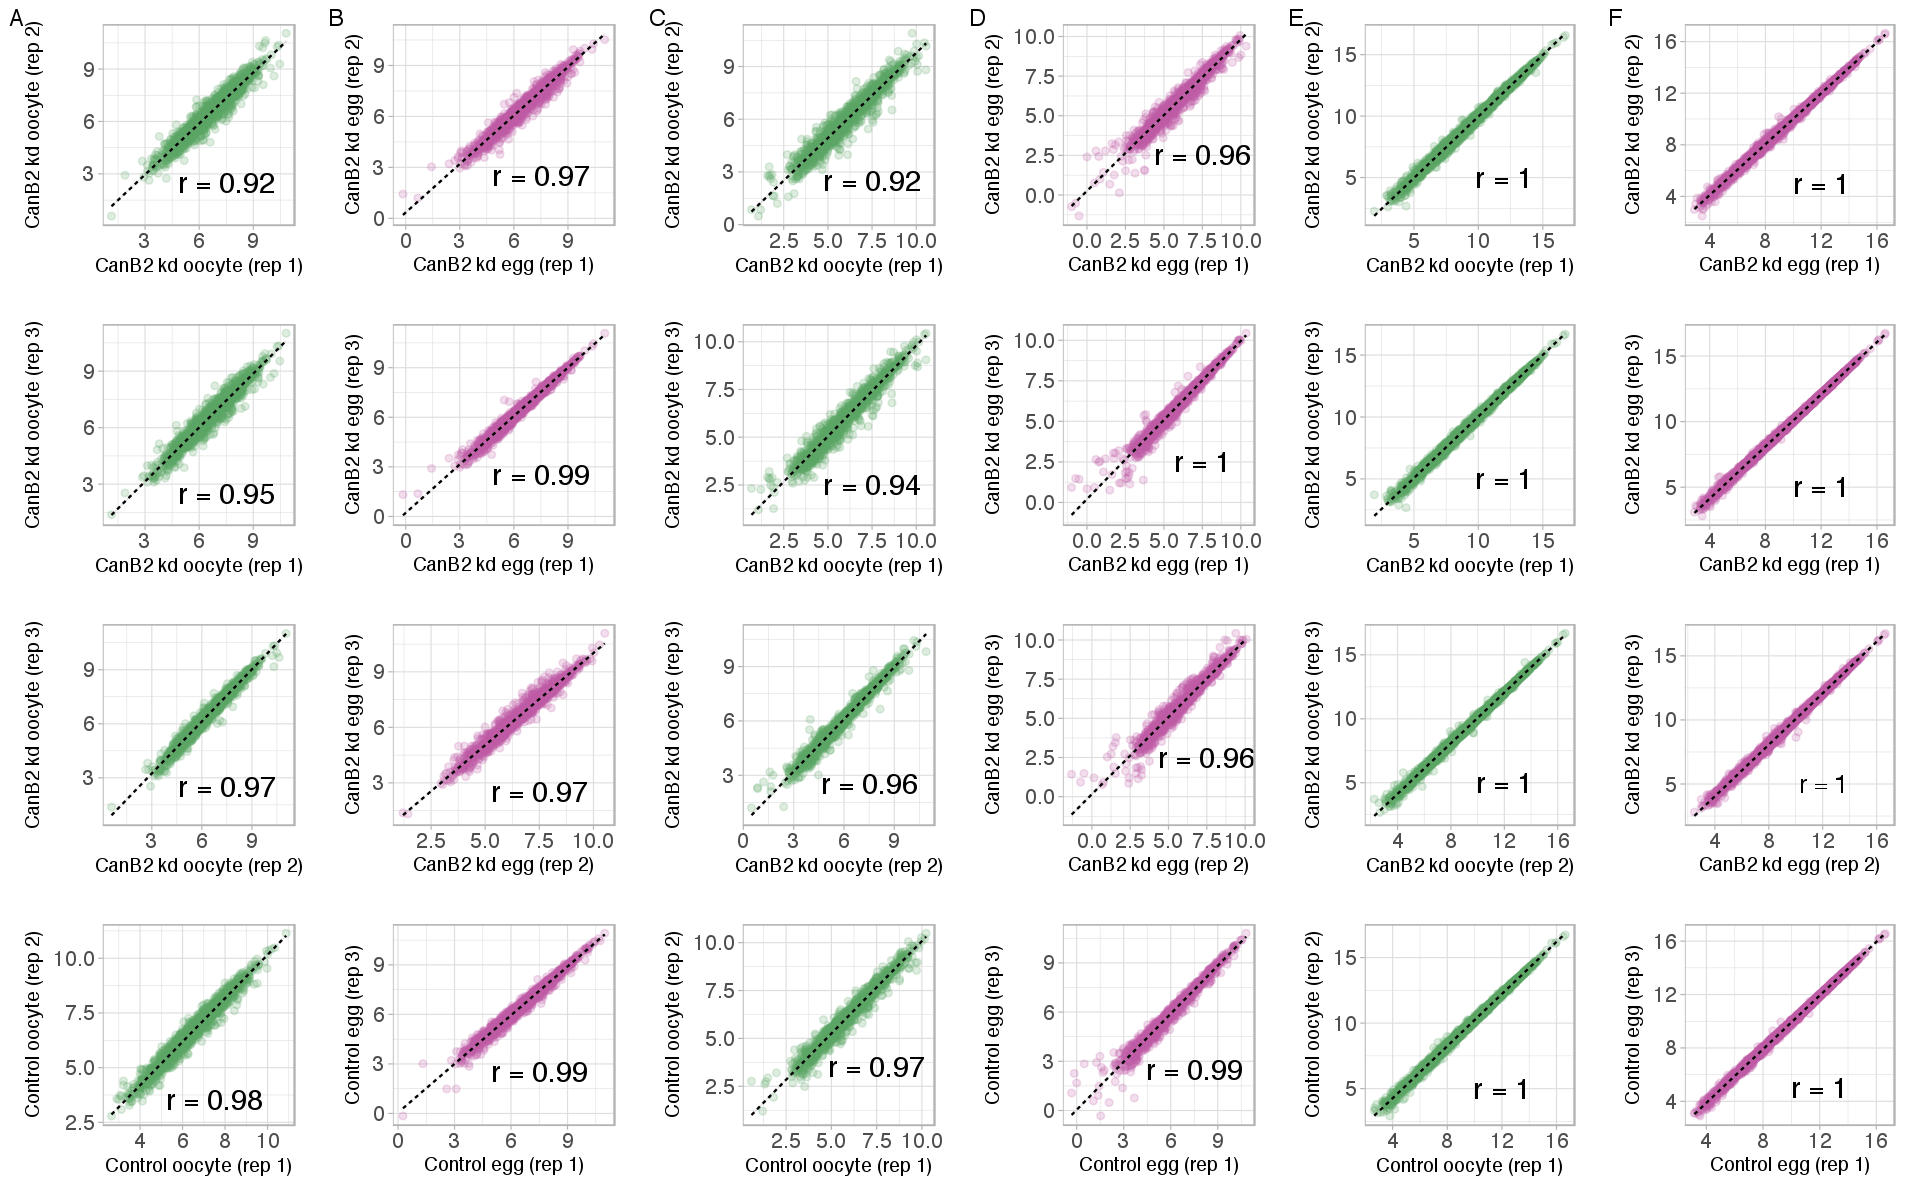

In [166]:
options(repr.plot.width = 16, repr.plot.height = 10)
# pdf("manuscript/Figures/Figure_S4.pdf", width = 16, height = 10)
plot_grid(canB_oocytes_msa, canB_eggs_msa, canB_oocytes_nl, canB_eggs_nl, canB_oocytes, canB_eggs, ncol = 6)
# dev.off()

### Data for individual phosphosite/protein plots:

In [167]:
canB_peptides_msa_logFCs = select(canB_peptides_msa, c("Master Protein Accessions", "Master Protein Descriptions", "Annotated Sequence","Modifications in Master Proteins", "Modifications"))
colnames(canB_peptides_msa_logFCs) = c('Protein.Group.Accessions', 'Protein.Descriptions', 'Sequence', 'Master.Protein.Modification', 'Modifications')
# head(canB_peptides_msa_logFCs)


canB_peptides_msa_abundances = select(canB_peptides_msa, contains("Abundance: F1:"))
colnames(canB_peptides_msa_abundances) = gsub("Abundance: F1: ", "", colnames(canB_peptides_msa_abundances))
colnames(canB_peptides_msa_abundances) = gsub(", Sample, ", "_", colnames(canB_peptides_msa_abundances))
colnames(canB_peptides_msa_abundances) = gsub(" ", "_", colnames(canB_peptides_msa_abundances))

canB_peptides_msa_foldChange = cbind(canB_peptides_msa_logFCs, canB_peptides_msa_abundances)
canB_peptides_msa_foldChange$CanB2_kd_1 = log2(canB_peptides_msa_foldChange$`130N_Egg_CanB2`/canB_peptides_msa_foldChange$`127N_Oocyte_CanB2`)
canB_peptides_msa_foldChange$CanB2_kd_2 = log2(canB_peptides_msa_foldChange$`130N_Egg_CanB2`/canB_peptides_msa_foldChange$`128N_Oocyte_CanB2`)
canB_peptides_msa_foldChange$CanB2_kd_3 = log2(canB_peptides_msa_foldChange$`130N_Egg_CanB2`/canB_peptides_msa_foldChange$`128C_Oocyte_CanB2`)
canB_peptides_msa_foldChange$CanB2_kd_4 = log2(canB_peptides_msa_foldChange$`130C_Egg_CanB2`/canB_peptides_msa_foldChange$`127N_Oocyte_CanB2`)
canB_peptides_msa_foldChange$CanB2_kd_5 = log2(canB_peptides_msa_foldChange$`130C_Egg_CanB2`/canB_peptides_msa_foldChange$`128N_Oocyte_CanB2`)
canB_peptides_msa_foldChange$CanB2_kd_6 = log2(canB_peptides_msa_foldChange$`130C_Egg_CanB2`/canB_peptides_msa_foldChange$`128C_Oocyte_CanB2`)
canB_peptides_msa_foldChange$CanB2_kd_7 = log2(canB_peptides_msa_foldChange$`131_Egg_CanB2`/canB_peptides_msa_foldChange$`127N_Oocyte_CanB2`)
canB_peptides_msa_foldChange$CanB2_kd_8 = log2(canB_peptides_msa_foldChange$`131_Egg_CanB2`/canB_peptides_msa_foldChange$`128N_Oocyte_CanB2`)
canB_peptides_msa_foldChange$CanB2_kd_9 = log2(canB_peptides_msa_foldChange$`131_Egg_CanB2`/canB_peptides_msa_foldChange$`128C_Oocyte_CanB2`)
canB_peptides_msa_foldChange$Control_1 = log2(canB_peptides_msa_foldChange$`129N_Egg_WT`/canB_peptides_msa_foldChange$`126_Oocyte_WT`)
canB_peptides_msa_foldChange$Control_2 = log2(canB_peptides_msa_foldChange$`129N_Egg_WT`/canB_peptides_msa_foldChange$`127C_Oocyte_WT`)
canB_peptides_msa_foldChange$Control_3 = log2(canB_peptides_msa_foldChange$`129C_Egg_WT`/canB_peptides_msa_foldChange$`126_Oocyte_WT`)
canB_peptides_msa_foldChange$Control_4 = log2(canB_peptides_msa_foldChange$`129C_Egg_WT`/canB_peptides_msa_foldChange$`127C_Oocyte_WT`)
canB_peptides_msa_foldChange = subset(canB_peptides_msa_foldChange, select = c('Protein.Group.Accessions', 'Protein.Descriptions', 'Sequence', 'Master.Protein.Modification', 'Modifications', 'CanB2_kd_1', 'CanB2_kd_2', 'CanB2_kd_3', 'CanB2_kd_4', 'CanB2_kd_5', 'CanB2_kd_6', 'CanB2_kd_7', 'CanB2_kd_8', 'CanB2_kd_9', 'Control_1', 'Control_2', 'Control_3', 'Control_4'))

canB_peptides_msa_foldChange$phosphosite = gsub(".*\\[", "\\[", canB_peptides_msa_foldChange$Master.Protein.Modification)
canB_peptides_msa_foldChange$phosphosite = gsub("\\(.*\\)", "",canB_peptides_msa_foldChange$phosphosite)

canB_peptides_msa_foldChange$gene_name = gsub(".*GN=", "", canB_peptides_msa_foldChange$Protein.Descriptions)
canB_peptides_msa_foldChange$gene_name = gsub(" PE=.*", "", canB_peptides_msa_foldChange$gene_name)

canB_peptides_msa_foldChange = melt(canB_peptides_msa_foldChange, id.vars = c("Protein.Group.Accessions", "Protein.Descriptions", "Sequence", "Modifications", "Master.Protein.Modification", "gene_name", "phosphosite"))
colnames(canB_peptides_msa_foldChange) =  c("Protein.Group.Accessions", "Protein.Descriptions", "Sequence", "Modifications", "Master.Protein.Modification", "gene_name", "phosphosite", "comparison", "FC")

canB_peptides_msa_foldChange$sample = ifelse(grepl("Control", canB_peptides_msa_foldChange$comparison), "Control", "CanB2 kd")

# head(canB_peptides_msa_foldChange)

canB_peptides_msa_foldChange.se = summarySE(canB_peptides_msa_foldChange, measurevar = "FC", groupvars = c("Protein.Group.Accessions", "Protein.Descriptions", "Sequence", "Master.Protein.Modification", "gene_name", "sample", "phosphosite"))

canB_peptides_msa_foldChange.se$method = "MSA"

canB_peptides_msa_foldChange.se$sample = factor(canB_peptides_msa_foldChange.se$sample, levels = c("Control", "CanB2 kd"))
subset(canB_peptides_msa_foldChange.se, Protein.Group.Accessions == "Q95TN8")

Protein.Group.Accessions
536  Q95TN8                  
537  Q95TN8                  
1270 Q95TN8                  
2360 Q95TN8                  
2361 Q95TN8                  
3094 Q95TN8                  
     Protein.Descriptions                                            
536  Greatwall, isoform A OS=Drosophila melanogaster GN=gwl PE=1 SV=1
537  Greatwall, isoform A OS=Drosophila melanogaster GN=gwl PE=1 SV=1
1270 Greatwall, isoform A OS=Drosophila melanogaster GN=gwl PE=1 SV=1
2360 Greatwall, isoform A OS=Drosophila melanogaster GN=gwl PE=1 SV=1
2361 Greatwall, isoform A OS=Drosophila melanogaster GN=gwl PE=1 SV=1
3094 Greatwall, isoform A OS=Drosophila melanogaster GN=gwl PE=1 SV=1
     Sequence                                
536  [R].SLSDDEMPINHLLGPEANVANVVFSTPVSSQK.[L]
537  [R].SLSDDEMPINHLLGPEANVANVVFSTPVSSQK.[L]
1270 [R].TPGQLLSLTSHLSFGSEK.[K]              
2360 [R].SLSDDEMPINHLLGPEANVANVVFSTPVSSQK.[L]
2361 [R].SLSDDEMPINHLLGPEANVANVVFSTPVSSQK.[L]
3094 [R].TPGQLLSLTSHLSFGSEK.[K]              
     Master.Protein.Modification              gene_name sample   phosphosite N 
536  Q95TN8 2xPhospho [T606(98.2); S]         gwl       CanB2 kd [T606; S]    9
537                                           gwl       CanB2 kd             18
1270 Q95TN8 2xPhospho [T227(100); S242(98.9)] gwl       CanB2 kd [T227]       9
2360 Q95TN8 2xPhospho [T606(98.2); S]         gwl       Control  [T606; S]    4
2361                                          gwl       Control               8
3094 Q95TN8 2xPhospho [T227(100); S242(98.9)] gwl       Control  [T227]       4
     FC         sd        se         ci         method
536  -0.5544941 0.2056113 0.06853711 0.15804687 MSA   
537  -0.4406965 0.2855661 0.06730857 0.14200867 MSA   
1270  0.2616174 0.1113287 0.03710958 0.08557485 MSA   
2360 -1.2363252 0.1680322 0.08401611 0.26737676 MSA   
2361 -1.0729334 0.1747752 0.06179237 0.14611575 MSA   
3094 -1.1581194 0.2191503 0.10957515 0.34871704 MSA

In [168]:
canB_peptides_nl_logFCs = select(canB_peptides_nl, c("Master Protein Accessions", "Master Protein Descriptions", "Annotated Sequence","Modifications in Master Proteins", "Modifications"))
colnames(canB_peptides_nl_logFCs) = c('Protein.Group.Accessions', 'Protein.Descriptions', 'Sequence', 'Master.Protein.Modification', 'Modifications')
# head(canB_peptides_nl_logFCs)


canB_peptides_nl_abundances = select(canB_peptides_nl, contains("Abundance: F4:"))
colnames(canB_peptides_nl_abundances) = gsub("Abundance: F4: ", "", colnames(canB_peptides_nl_abundances))
colnames(canB_peptides_nl_abundances) = gsub(", Sample, ", "_", colnames(canB_peptides_nl_abundances))
colnames(canB_peptides_nl_abundances) = gsub(" ", "_", colnames(canB_peptides_nl_abundances))

canB_peptides_nl_foldChange = cbind(canB_peptides_nl_logFCs, canB_peptides_nl_abundances)
canB_peptides_nl_foldChange$CanB2_kd_1 = log2(canB_peptides_nl_foldChange$`130N_Egg_CanB2`/canB_peptides_nl_foldChange$`127N_Oocyte_CanB2`)
canB_peptides_nl_foldChange$CanB2_kd_2 = log2(canB_peptides_nl_foldChange$`130N_Egg_CanB2`/canB_peptides_nl_foldChange$`128N_Oocyte_CanB2`)
canB_peptides_nl_foldChange$CanB2_kd_3 = log2(canB_peptides_nl_foldChange$`130N_Egg_CanB2`/canB_peptides_nl_foldChange$`128C_Oocyte_CanB2`)
canB_peptides_nl_foldChange$CanB2_kd_4 = log2(canB_peptides_nl_foldChange$`130C_Egg_CanB2`/canB_peptides_nl_foldChange$`127N_Oocyte_CanB2`)
canB_peptides_nl_foldChange$CanB2_kd_5 = log2(canB_peptides_nl_foldChange$`130C_Egg_CanB2`/canB_peptides_nl_foldChange$`128N_Oocyte_CanB2`)
canB_peptides_nl_foldChange$CanB2_kd_6 = log2(canB_peptides_nl_foldChange$`130C_Egg_CanB2`/canB_peptides_nl_foldChange$`128C_Oocyte_CanB2`)
canB_peptides_nl_foldChange$CanB2_kd_7 = log2(canB_peptides_nl_foldChange$`131_Egg_CanB2`/canB_peptides_nl_foldChange$`127N_Oocyte_CanB2`)
canB_peptides_nl_foldChange$CanB2_kd_8 = log2(canB_peptides_nl_foldChange$`131_Egg_CanB2`/canB_peptides_nl_foldChange$`128N_Oocyte_CanB2`)
canB_peptides_nl_foldChange$CanB2_kd_9 = log2(canB_peptides_nl_foldChange$`131_Egg_CanB2`/canB_peptides_nl_foldChange$`128C_Oocyte_CanB2`)
canB_peptides_nl_foldChange$Control_1 = log2(canB_peptides_nl_foldChange$`129N_Egg_WT`/canB_peptides_nl_foldChange$`126_Oocyte_WT`)
canB_peptides_nl_foldChange$Control_2 = log2(canB_peptides_nl_foldChange$`129N_Egg_WT`/canB_peptides_nl_foldChange$`127C_Oocyte_WT`)
canB_peptides_nl_foldChange$Control_3 = log2(canB_peptides_nl_foldChange$`129C_Egg_WT`/canB_peptides_nl_foldChange$`126_Oocyte_WT`)
canB_peptides_nl_foldChange$Control_4 = log2(canB_peptides_nl_foldChange$`129C_Egg_WT`/canB_peptides_nl_foldChange$`127C_Oocyte_WT`)
canB_peptides_nl_foldChange = subset(canB_peptides_nl_foldChange, select = c('Protein.Group.Accessions', 'Protein.Descriptions', 'Sequence', 'Master.Protein.Modification', 'Modifications', 'CanB2_kd_1', 'CanB2_kd_2', 'CanB2_kd_3', 'CanB2_kd_4', 'CanB2_kd_5', 'CanB2_kd_6', 'CanB2_kd_7', 'CanB2_kd_8', 'CanB2_kd_9', 'Control_1', 'Control_2', 'Control_3', 'Control_4'))

canB_peptides_nl_foldChange$phosphosite = gsub(".*\\[", "\\[", canB_peptides_nl_foldChange$Master.Protein.Modification)
canB_peptides_nl_foldChange$phosphosite = gsub("\\(.*\\)", "",canB_peptides_nl_foldChange$phosphosite)

canB_peptides_nl_foldChange$gene_name = gsub(".*GN=", "", canB_peptides_nl_foldChange$Protein.Descriptions)
canB_peptides_nl_foldChange$gene_name = gsub(" PE=.*", "", canB_peptides_nl_foldChange$gene_name)

canB_peptides_nl_foldChange = melt(canB_peptides_nl_foldChange, id.vars = c("Protein.Group.Accessions", "Protein.Descriptions", "Sequence", "Modifications", "Master.Protein.Modification", "gene_name", "phosphosite"))
colnames(canB_peptides_nl_foldChange) =  c("Protein.Group.Accessions", "Protein.Descriptions", "Sequence", "Modifications", "Master.Protein.Modification", "gene_name", "phosphosite", "comparison", "FC")

canB_peptides_nl_foldChange$sample = ifelse(grepl("Control", canB_peptides_nl_foldChange$comparison), "Control", "CanB2 kd")

# head(canB_peptides_nl_foldChange)

canB_peptides_nl_foldChange.se = summarySE(canB_peptides_nl_foldChange, measurevar = "FC", groupvars = c("Protein.Group.Accessions", "Protein.Descriptions", "Sequence", "Master.Protein.Modification", "gene_name", "sample", "phosphosite"))

canB_peptides_nl_foldChange.se$method = "NL"

canB_peptides_nl_foldChange.se$sample = factor(canB_peptides_nl_foldChange.se$sample, levels = c("Control", "CanB2 kd"))
subset(canB_peptides_nl_foldChange.se, Protein.Group.Accessions == "Q95TN8")

Protein.Group.Accessions
535  Q95TN8                  
1937 Q95TN8                  
2246 Q95TN8                  
2801 Q95TN8                  
4203 Q95TN8                  
4512 Q95TN8                  
     Protein.Descriptions                                            
535  Greatwall, isoform A OS=Drosophila melanogaster GN=gwl PE=1 SV=1
1937 Greatwall, isoform A OS=Drosophila melanogaster GN=gwl PE=1 SV=1
2246 Greatwall, isoform A OS=Drosophila melanogaster GN=gwl PE=1 SV=1
2801 Greatwall, isoform A OS=Drosophila melanogaster GN=gwl PE=1 SV=1
4203 Greatwall, isoform A OS=Drosophila melanogaster GN=gwl PE=1 SV=1
4512 Greatwall, isoform A OS=Drosophila melanogaster GN=gwl PE=1 SV=1
     Sequence                                
535  [R].TPGQLLSLTSHLSFGSEK.[K]              
1937 [R].SLSDDEMPINHLLGPEANVANVVFSTPVSSQK.[L]
2246 [R].SLSDDEMPINHLLGPEANVANVVFSTPVSSQK.[L]
2801 [R].TPGQLLSLTSHLSFGSEK.[K]              
4203 [R].SLSDDEMPINHLLGPEANVANVVFSTPVSSQK.[L]
4512 [R].SLSDDEMPINHLLGPEANVANVVFSTPVSSQK.[L]
     Master.Protein.Modification               gene_name sample   phosphosite N
535  Q95TN8 2xPhospho [T227(100); S242(100)]   gwl       CanB2 kd [T227]      9
1937                                           gwl       CanB2 kd             9
2246 Q95TN8 2xPhospho [S581(80.7); S605(80.4)] gwl       CanB2 kd [S581]      9
2801 Q95TN8 2xPhospho [T227(100); S242(100)]   gwl       Control  [T227]      4
4203                                           gwl       Control              4
4512 Q95TN8 2xPhospho [S581(80.7); S605(80.4)] gwl       Control  [S581]      4
     FC         sd        se         ci        method
535  0.38155949 0.2425895 0.08086315 0.1864708 NL    
1937         NA        NA         NA        NA NL    
2246         NA        NA         NA        NA NL    
2801 0.09219417 0.1239341 0.06196706 0.1972068 NL    
4203         NA        NA         NA        NA NL    
4512         NA        NA         NA        NA NL

In [169]:
options(repr.plot.width = 4.5, repr.plot.height = 3)

df.fig5A = filter(canB_peptides_msa_foldChange.se, Protein.Group.Accessions == "Q9VUB8" | (Protein.Group.Accessions == "Q95TN8" & phosphosite == "[T606; S]") )
df.fig5A$phosphosite = gsub("\\[T606; S\\]", "\\[T606\\]", df.fig5A$phosphosite)
df.fig5A$protein = ifelse(df.fig5A$gene_name == "endos", "Endos", "Gwl")
df.fig5A$gene_phosphosite = paste(df.fig5A$protein, df.fig5A$phosphosite, sep = " ")

fig5A = ggplot(df.fig5A, aes(gene_phosphosite, FC, fill = sample)) + 
    geom_bar(position=position_dodge(), stat="identity", width = 0.7) + 
    geom_errorbar(aes(ymin=FC-se, ymax=FC+se), width=.2, position=position_dodge(.7)) +
    labs(title = "phosphopeptides", y = "log2 fold-change", "") +
 geom_hline(yintercept = 0, linetype = "dashed") +
    theme_minimal() +
    theme(axis.text.y = element_text(size = 13), axis.text.x=element_text(size = 12, angle = 45, hjust = 1), axis.title.y=element_text(size = 14), axis.title.x=element_blank(), legend.text = element_text(size = 13), legend.title = element_blank()) +
    scale_fill_manual(values = c("#537db1","#fd9240"))

Make a similar data frame for proteins:

In [170]:
canB_proteins_logFCs = select(canB_proteins, c("Accession", "Description", "Gene Symbol"))

canB_proteins_abundances = select(canB_proteins, contains("Abundance: F5:"))
colnames(canB_proteins_abundances) = gsub("Abundance: F5: ", "", colnames(canB_proteins_abundances))
colnames(canB_proteins_abundances) = gsub(", Sample, n/a, n/a, ", "_", colnames(canB_proteins_abundances))
colnames(canB_proteins_abundances) = gsub("__", "_", colnames(canB_proteins_abundances))
colnames(canB_proteins_abundances) = gsub(" ", "", colnames(canB_proteins_abundances))

canB_proteins_foldChange = cbind(canB_proteins_logFCs, canB_proteins_abundances)
canB_proteins_foldChange$CanB2_kd_1 = log2(canB_proteins_foldChange$`130N_Egg_CanB2`/canB_proteins_foldChange$`127N_Oocyte_CanB2`)
canB_proteins_foldChange$CanB2_kd_2 = log2(canB_proteins_foldChange$`130N_Egg_CanB2`/canB_proteins_foldChange$`128N_Oocyte_CanB2`)
canB_proteins_foldChange$CanB2_kd_3 = log2(canB_proteins_foldChange$`130N_Egg_CanB2`/canB_proteins_foldChange$`128C_Oocyte_CanB2`)
canB_proteins_foldChange$CanB2_kd_4 = log2(canB_proteins_foldChange$`130C_Egg_CanB2`/canB_proteins_foldChange$`127N_Oocyte_CanB2`)
canB_proteins_foldChange$CanB2_kd_5 = log2(canB_proteins_foldChange$`130C_Egg_CanB2`/canB_proteins_foldChange$`128N_Oocyte_CanB2`)
canB_proteins_foldChange$CanB2_kd_6 = log2(canB_proteins_foldChange$`130C_Egg_CanB2`/canB_proteins_foldChange$`128C_Oocyte_CanB2`)
canB_proteins_foldChange$CanB2_kd_7 = log2(canB_proteins_foldChange$`131_Egg_CanB2`/canB_proteins_foldChange$`127N_Oocyte_CanB2`)
canB_proteins_foldChange$CanB2_kd_8 = log2(canB_proteins_foldChange$`131_Egg_CanB2`/canB_proteins_foldChange$`128N_Oocyte_CanB2`)
canB_proteins_foldChange$CanB2_kd_9 = log2(canB_proteins_foldChange$`131_Egg_CanB2`/canB_proteins_foldChange$`128C_Oocyte_CanB2`)
canB_proteins_foldChange$Control_1 = log2(canB_proteins_foldChange$`129N_Egg_WT`/canB_proteins_foldChange$`126_Oocyte_WT`)
canB_proteins_foldChange$Control_2 = log2(canB_proteins_foldChange$`129N_Egg_WT`/canB_proteins_foldChange$`127C_Oocyte_WT`)
canB_proteins_foldChange$Control_3 = log2(canB_proteins_foldChange$`129C_Egg_WT`/canB_proteins_foldChange$`126_Oocyte_WT`)
canB_proteins_foldChange$Control_4 = log2(canB_proteins_foldChange$`129C_Egg_WT`/canB_proteins_foldChange$`127C_Oocyte_WT`)
canB_proteins_foldChange = subset(canB_proteins_foldChange, select = c("Accession", "Description", "Gene Symbol", 'CanB2_kd_1', 'CanB2_kd_2', 'CanB2_kd_3', 'CanB2_kd_4', 'CanB2_kd_5', 'CanB2_kd_6', 'CanB2_kd_7', 'CanB2_kd_8', 'CanB2_kd_9', 'Control_1', 'Control_2', 'Control_3', 'Control_4'))

canB_proteins_foldChange = melt(canB_proteins_foldChange, id.vars = c("Accession", "Description", "Gene Symbol"))
colnames(canB_proteins_foldChange) =  c("Accession", "Description", "GeneSymbol", "comparison", "FC")

canB_proteins_foldChange$sample = ifelse(grepl("Control", canB_proteins_foldChange$comparison), "Control", "CanB2 kd")

canB_proteins_foldChange.se = summarySE(canB_proteins_foldChange, measurevar = "FC", groupvars = c("Accession", "Description", "GeneSymbol", "sample"))

canB_proteins_foldChange.se$sample = factor(canB_proteins_foldChange.se$sample, levels = c("Control", "CanB2 kd"))

In [171]:
options(repr.plot.width = 4.5, repr.plot.height = 3)

df.fig5B = filter(canB_proteins_foldChange.se, (Accession == "Q23973" | Accession == "A0A0B4KHT9"))
df.fig5B$GeneSymbol = gsub("mtrm", "Mtrm", df.fig5B$GeneSymbol)

fig5B = ggplot(df.fig5B, aes(GeneSymbol, FC, fill = sample)) + 
    geom_bar(position=position_dodge(), stat="identity", width = 0.7) + 
    geom_errorbar(aes(ymin=FC-se, ymax=FC+se), width=.2, position=position_dodge(.7)) +
    labs(title = "proteins", y = "log2 fold-change") +
     geom_hline(yintercept = 0, linetype = "dashed") +
    theme_minimal() +
    theme(axis.text.y = element_text(size = 13), axis.text.x=element_text(size = 14, angle = 45, hjust = 1), axis.title.y=element_text(size = 14), axis.title.x=element_blank(), legend.text = element_text(size = 13), legend.title = element_blank()) +
    scale_fill_manual(values = c("#537db1","#fd9240"))

In [172]:
df.fig5C.phos = filter(canB_peptides_msa_foldChange.se, Protein.Group.Accessions == "Q24044" & !grepl("\\.DSGDKSDEENDK\\.", Sequence) &  !grepl("92\\.1", Master.Protein.Modification) & !grepl(";", phosphosite))
df.fig5C.phos$phosphosite = ifelse(grepl("T82", df.fig5C.phos$Master.Protein.Modification), "[T78, T82]", df.fig5C.phos$phosphosite)
df.fig5C.phos$ID = paste("Fzy", df.fig5C.phos$phosphosite, sep = " ")
df.fig5C.phos = subset(df.fig5C.phos, select = c("Protein.Group.Accessions", "Protein.Descriptions", "ID", "sample", "N", "FC", "sd", "se", "ci"))
colnames(df.fig5C.phos) = c("Accession", "Description", "ID", "sample", "N", "FC", "sd", "se", "ci")
df.fig5C.phos$source = "phosphopeptide"

df.fig5C.prot = filter(canB_proteins_foldChange.se, Accession == "Q24044")
colnames(df.fig5C.prot)[3] <- "ID"
df.fig5C.prot$ID = "Fzy protein"
df.fig5C.prot$source = "protein"

df.fig5C = rbind(df.fig5C.phos, df.fig5C.prot)

options(repr.plot.width = 7, repr.plot.height = 4)
fig5C = ggplot(df.fig5C, aes(ID, FC, fill = sample)) + 
    geom_bar(position=position_dodge(), stat="identity", width = 0.7) + 
    geom_errorbar(aes(ymin=FC-se, ymax=FC+se), width=.2, position=position_dodge(.7)) +
    labs(y = "log2 fold-change") +
    geom_hline(yintercept = 0, linetype = "dashed") +
    facet_grid(.~source, space = "free", scale = "free") +
    theme_minimal() +
    theme(axis.text.y = element_text(size = 13), axis.text.x=element_text(size = 13, angle = 45, hjust = 1), axis.title.y=element_text(size = 14), axis.title.x=element_blank(), legend.text = element_text(size = 13), legend.title = element_blank(), strip.text = element_blank()) +
    scale_fill_manual(values = c("#537db1","#fd9240"))

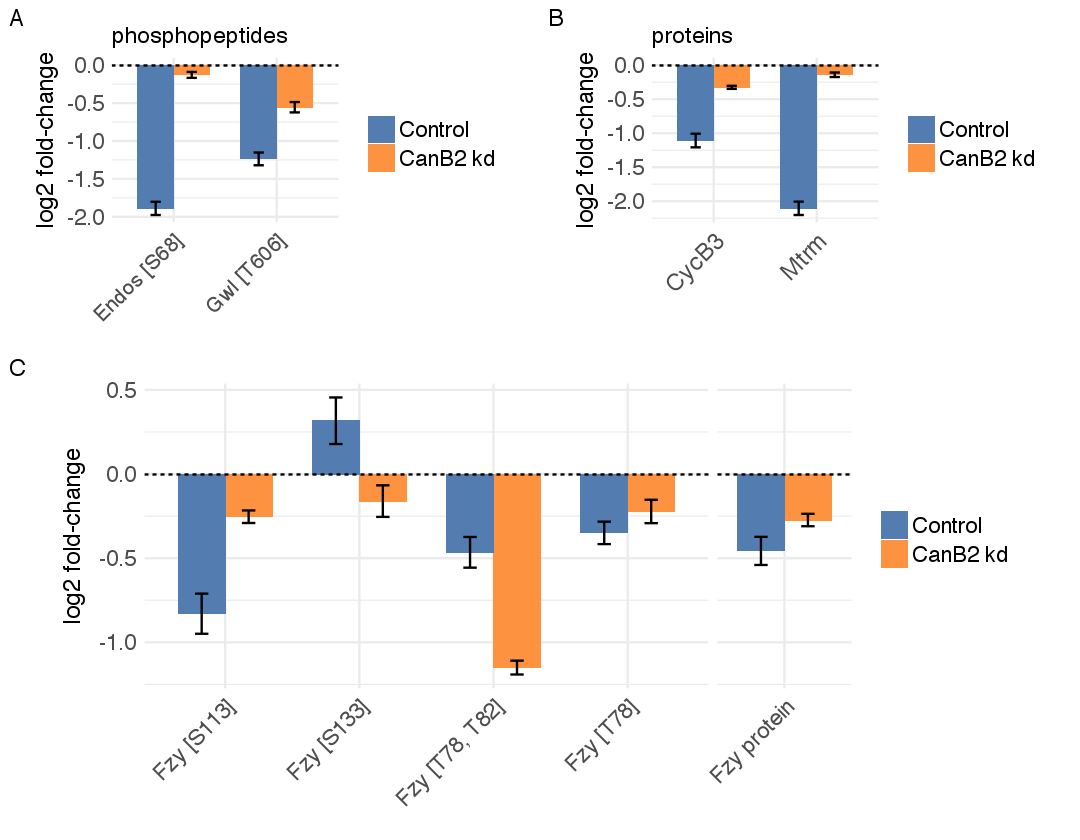

In [173]:
options(repr.plot.width = 9, repr.plot.height = 7)
fig5.top = plot_grid(fig5A, fig5B, labels = c("A", "B"), scale = c(0.9, 0.9), align = "h")

# pdf("manuscript/Figures/Figure_5.pdf", height = 7, width = 9)
plot_grid(fig5.top, fig5C, labels = c("", "C"), ncol = 1, scale = c(1,0.9), rel_heights = c(1, 1.4))
# dev.off()

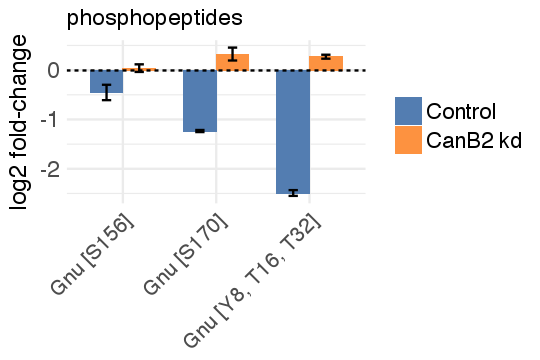

In [174]:
options(repr.plot.width = 4.5, repr.plot.height = 3)

df.fig6A.msa = filter(canB_peptides_msa_foldChange.se, gene_name == "gnu" & phosphosite != "")
df.fig6A.msa$phosphosite = gsub("Y8", "Y8, T16, T32", df.fig6A.msa$phosphosite)

df.fig6A.nl = filter(canB_peptides_nl_foldChange.se, gene_name == "gnu" & grepl("S170" ,phosphosite))
df.fig6A.nl$phosphosite = gsub("; T/S/Y", "", df.fig6A.nl$phosphosite)

df.fig6A = rbind(df.fig6A.msa, df.fig6A.nl)

df.fig6A$ID = paste("Gnu", df.fig6A$phosphosite, sep = " ")

(fig6A = ggplot(df.fig6A, aes(ID, FC, fill = sample)) + 
    geom_bar(position=position_dodge(), stat="identity", width = 0.7) + 
    geom_errorbar(aes(ymin=FC-se, ymax=FC+se), width=.2, position=position_dodge(.7)) +
    labs(title = "phosphopeptides", y = "log2 fold-change") +
 geom_hline(yintercept = 0, linetype = "dashed") +
    theme_minimal() +
    theme(axis.text.y = element_text(size = 13), axis.text.x=element_text(size = 12, angle = 45, hjust = 1), axis.title.y=element_text(size = 14), axis.title.x=element_blank(), legend.text = element_text(size = 13), legend.title = element_blank()) +
    scale_fill_manual(values = c("#537db1","#fd9240")))

In [175]:
options(repr.plot.width = 4.5, repr.plot.height = 3)

df.fig6B = filter(canB_proteins_foldChange.se, GeneSymbol == "CycA" | GeneSymbol == "CycB" | GeneSymbol == "smg")
df.fig6B$GeneSymbol = gsub("smg", "Smg", df.fig6B$GeneSymbol)

fig6B = ggplot(df.fig6B, aes(GeneSymbol, FC, fill = sample)) + 
    geom_bar(position=position_dodge(), stat="identity", width = 0.7) + 
    geom_errorbar(aes(ymin=FC-se, ymax=FC+se), width=.2, position=position_dodge(.7)) +
    labs(title = "proteins", y = "log2 fold-change") +
     geom_hline(yintercept = 0, linetype = "dashed") +
    theme_minimal() +
    theme(axis.text.y = element_text(size = 13), axis.text.x=element_text(size = 14, angle = 45, hjust = 1), axis.title.y=element_text(size = 14), axis.title.x=element_blank(), legend.text = element_text(size = 13), legend.title = element_blank()) +
    scale_fill_manual(values = c("#537db1","#fd9240"))

In [176]:
df.fig6C.nat1.msa =  filter(canB_peptides_msa_foldChange.se, 
       gene_name == "NAT1" & 
       phosphosite != "" & 
       phosphosite != "[S217]" & 
       phosphosite != "[S223]" & 
       phosphosite != "[S143]" & 
       phosphosite != "[S1068; S/T]" & 
       Master.Protein.Modification != "A1Z968 2xPhospho [S1055(100); S/T]" & 
       phosphosite != "[S1483]" & 
       Master.Protein.Modification != "A1Z968 2xPhospho [S816(92.6); S820(92.8)]" & 
       Master.Protein.Modification != "A1Z968 2xPhospho [S816(96.3); S820(99.7)]" & 
       Master.Protein.Modification != "A1Z968 1xPhospho [S389(97.2)]" & 
        Master.Protein.Modification != "A1Z968 1xPhospho [S870(97.7)]" &
                            Sequence != "[R].YNKHNQNGGGSGGGSSNNR.[D]"
      )

df.fig6C.nat1.nl =  filter(canB_peptides_msa_foldChange.se, 
       gene_name == "NAT1" & 
       phosphosite != "" &
       phosphosite == "[S143]" &
        !is.na(FC) 
      )


df.fig6C.nat1.msa$phosphosite = gsub("\\[S1055; S/T\\]", "\\[S1055, S1068\\]", df.fig6C.nat1.msa$phosphosite)
df.fig6C.nat1.msa$phosphosite = gsub("S816", "S816, S820", df.fig6C.nat1.msa$phosphosite)

df.fig6C.eIF4G = filter(canB_peptides_msa_foldChange.se, gene_name == "eIF4G" & phosphosite != "" & phosphosite != "[T621]" & Master.Protein.Modification != "A8DZ29 1xPhospho [S1321(100)]")

df.fig6C.eIF4B = filter(canB_peptides_msa_foldChange.se, gene_name == "eIF-4B" & phosphosite != "" & Master.Protein.Modification == "Q7PLL3 2xPhospho [S212(100); T221(100)]")

df.fig6C = rbind(df.fig6C.nat1.msa, df.fig6C.nat1.nl, df.fig6C.eIF4G, df.fig6C.eIF4B)
df.fig6C$gene_name = gsub("eIF4G", "eIF-4G", df.fig6C$gene_name)
df.fig6C$ID = paste(df.fig6C$gene_name, df.fig6C$phosphosite, sep = " ")

options(repr.plot.width = 7, repr.plot.height = 3)

fig6C = ggplot(df.fig6C, aes(ID, FC, fill = sample)) + 
    geom_bar(position=position_dodge(), stat="identity", width = 0.7) + 
    geom_errorbar(aes(ymin=FC-se, ymax=FC+se), width=.2, position=position_dodge(.7)) +
    labs(title = "phosphopeptides", y = "log2 fold-change") +
 geom_hline(yintercept = 0, linetype = "dashed") +
    theme_minimal() +
    theme(axis.text.y = element_text(size = 13), axis.text.x=element_text(size = 12, angle = 45, hjust = 1), axis.title.y=element_text(size = 14), axis.title.x=element_blank(), legend.text = element_text(size = 13), legend.title = element_blank()) +
    scale_fill_manual(values = c("#537db1","#fd9240"))

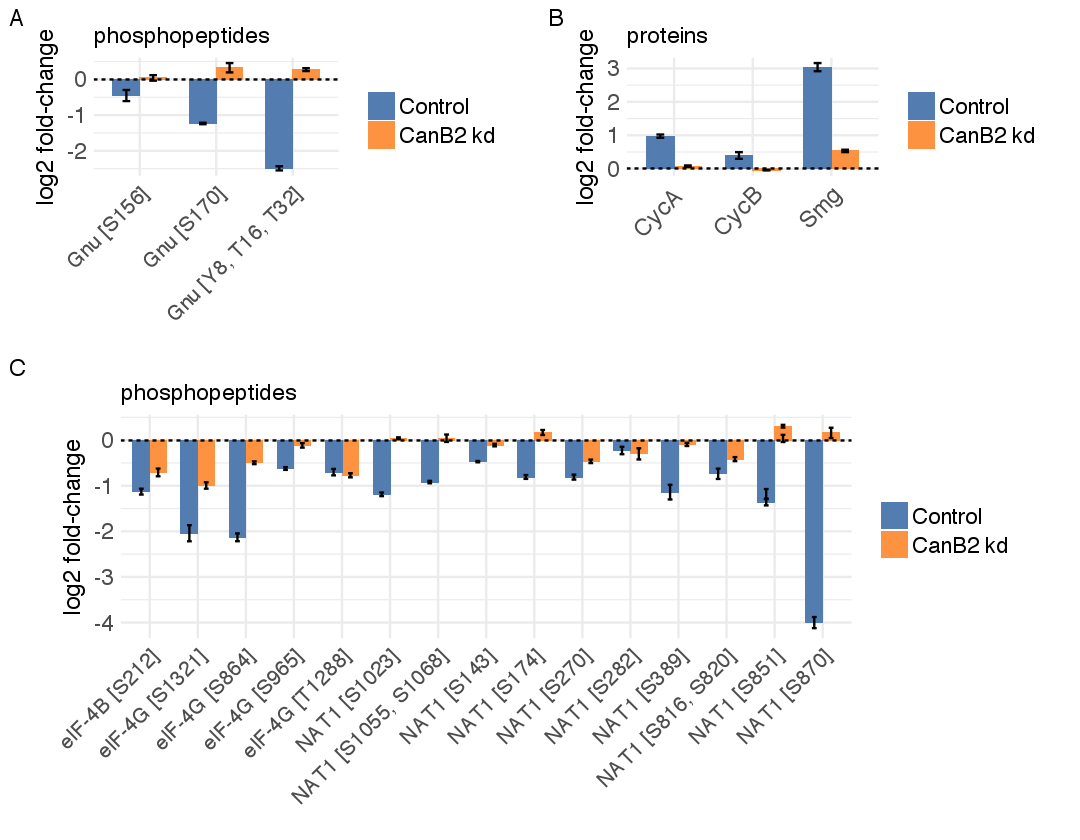

In [177]:
options(repr.plot.width = 9, repr.plot.height = 7)
fig6.top = plot_grid(fig6A, fig6B, labels = c("A", "B"), scale = c(0.9, 0.9), align = "h")

# pdf("manuscript/Figures/Figure_6.pdf", height = 7, width = 9)
plot_grid(fig6.top, fig6C, labels = c("", "C"), ncol = 1, scale = c(1,0.9), rel_heights = c(1, 1.4))
# dev.off()

Accession Description                                                  
1 A4V3W1    Shaggy, isoform J OS=Drosophila melanogaster GN=sgg PE=1 SV=1
2 A4V3W1    Shaggy, isoform J OS=Drosophila melanogaster GN=sgg PE=1 SV=1
  ID       sample   N FC         sd        se         ci        source        
1 Sgg [S9] CanB2 kd 9 -0.4511386 0.3397781 0.11325936 0.2611766 phosphopeptide
2 Sgg [S9] Control  4  2.7952970 0.1854677 0.09273387 0.2951206 phosphopeptide

Accession Description                                                  
1 A4V3W1    Shaggy, isoform J OS=Drosophila melanogaster GN=sgg PE=1 SV=1
2 A4V3W1    Shaggy, isoform J OS=Drosophila melanogaster GN=sgg PE=1 SV=1
  ID          sample   N FC          sd         se         ci         source 
1 Sgg protein CanB2 kd 9  0.12471416 0.05266684 0.01755561 0.04048331 protein
2 Sgg protein Control  4 -0.01694651 0.11546061 0.05773031 0.18372360 protein

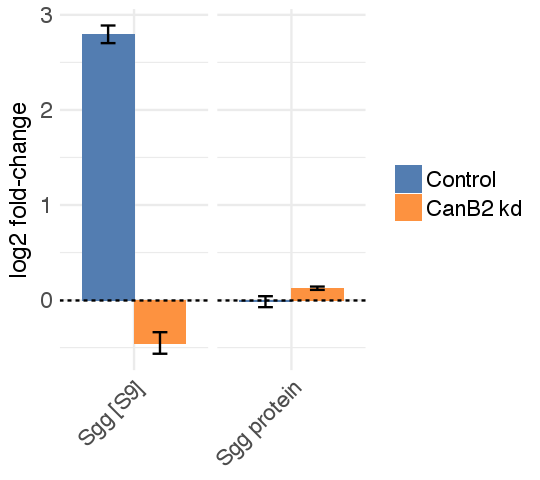

In [178]:
df.fig7A.phos = filter(canB_peptides_msa_foldChange.se, gene_name == "sgg" & phosphosite == "[S9]")
df.fig7A.phos$ID = paste("Sgg", df.fig7A.phos$phosphosite)
df.fig7A.phos = subset(df.fig7A.phos, select = c("Protein.Group.Accessions", "Protein.Descriptions", "ID", "sample", "N", "FC", "sd", "se", "ci"))
colnames(df.fig7A.phos) = c("Accession", "Description", "ID", "sample", "N", "FC", "sd", "se", "ci")
df.fig7A.phos$source = "phosphopeptide"
df.fig7A.phos

df.fig7A.prot = filter(canB_proteins_foldChange.se, GeneSymbol == "sgg")
colnames(df.fig7A.prot)[3] <- "ID"
df.fig7A.prot$ID = "Sgg protein"
df.fig7A.prot$source = "protein"
df.fig7A.prot

df.fig7A = rbind(df.fig7A.phos, df.fig7A.prot)

options(repr.plot.width = 4.5, repr.plot.height = 4)
# pdf("manuscript/Figures/Figure_7A.pdf", width = 4.5, height = 3)
(fig7A = ggplot(df.fig7A, aes(ID, FC, fill = sample)) + 
    geom_bar(position=position_dodge(), stat="identity", width = 0.7) + 
    geom_errorbar(aes(ymin=FC-se, ymax=FC+se), width=.2, position=position_dodge(.7)) +
    labs(y = "log2 fold-change") +
    geom_hline(yintercept = 0, linetype = "dashed") +
    facet_grid(.~source, space = "free", scale = "free") +
    theme_minimal() +
    theme(axis.text.y = element_text(size = 13), axis.text.x=element_text(size = 13, angle = 45, hjust = 1), axis.title.y=element_text(size = 14), axis.title.x=element_blank(), legend.text = element_text(size = 13), legend.title = element_blank(), strip.text = element_blank()) +
    scale_fill_manual(values = c("#537db1","#fd9240")))
# dev.off()

In [179]:
df.fig5C.phos = filter(canB_peptides_msa_foldChange.se, Protein.Group.Accessions == "Q24044" & !grepl("\\.DSGDKSDEENDK\\.", Sequence) &  !grepl("92\\.1", Master.Protein.Modification) & !grepl(";", phosphosite))
df.fig5C.phos$phosphosite = ifelse(grepl("T82", df.fig5C.phos$Master.Protein.Modification), "[T78, T82]", df.fig5C.phos$phosphosite)
df.fig5C.phos$ID = paste("Fzy", df.fig5C.phos$phosphosite, sep = " ")
df.fig5C.phos = subset(df.fig5C.phos, select = c("Protein.Group.Accessions", "Protein.Descriptions", "ID", "sample", "N", "FC", "sd", "se", "ci"))
colnames(df.fig5C.phos) = c("Accession", "Description", "ID", "sample", "N", "FC", "sd", "se", "ci")
df.fig5C.phos$source = "phosphopeptide"

df.fig5C.prot = filter(canB_proteins_foldChange.se, Accession == "Q24044")
colnames(df.fig5C.prot)[3] <- "ID"
df.fig5C.prot$ID = "Fzy protein"
df.fig5C.prot$source = "protein"

df.fig5C = rbind(df.fig5C.phos, df.fig5C.prot)

options(repr.plot.width = 7, repr.plot.height = 4)
fig5C = ggplot(df.fig5C, aes(ID, FC, fill = sample)) + 
    geom_bar(position=position_dodge(), stat="identity", width = 0.7) + 
    geom_errorbar(aes(ymin=FC-se, ymax=FC+se), width=.2, position=position_dodge(.7)) +
    labs(y = "log2 fold-change") +
    geom_hline(yintercept = 0, linetype = "dashed") +
    facet_grid(.~source, space = "free", scale = "free") +
    theme_minimal() +
    theme(axis.text.y = element_text(size = 13), axis.text.x=element_text(size = 13, angle = 45, hjust = 1), axis.title.y=element_text(size = 14), axis.title.x=element_blank(), legend.text = element_text(size = 13), legend.title = element_blank(), strip.text = element_blank()) +
    scale_fill_manual(values = c("#537db1","#fd9240"))

In [180]:
spiekIn.1.msa = filter(canB_peptides_msa_foldChange.se, Protein.Group.Accessions == "P00001" & phosphosite != "" & Master.Protein.Modification != "P00001 3xPhospho [S56(100); S61(99.2); S/T]" & Master.Protein.Modification != "P00001 3xPhospho [S56(98.9); S/T]")
spiekIn.2.msa = filter(canB_peptides_nl_foldChange.se, Protein.Group.Accessions == "P00001" & !is.na(FC))
spiekIn.1.nl = filter(canB_peptides_msa_foldChange.se, Protein.Group.Accessions == "P00002")
spiekIn.2.nl = filter(canB_peptides_nl_foldChange.se, Protein.Group.Accessions == "P00002")

spikeIn = rbind(spiekIn.1.msa, spiekIn.2.msa, spiekIn.1.nl, spiekIn.2.nl )
spikeIn$mods = gsub(".*Phospho ", "", spikeIn$Master.Protein.Modification)
spikeIn$mods = gsub("\\s*\\([^\\)]+\\)","",as.character(spikeIn$mods))
spikeIn$mods = gsub("; S/T", "", spikeIn$mods)
spikeIn$mods = gsub("; S\\]", "\\]", spikeIn$mods)
spikeIn$ID = paste(spikeIn$method, spikeIn$sample, sep = " ")
spikeIn


Protein.Group.Accessions Protein.Descriptions               
1  P00001                   Spiked Bovine CSN1S1 in Wolfner lab
2  P00001                   Spiked Bovine CSN1S1 in Wolfner lab
3  P00001                   Spiked Bovine CSN1S1 in Wolfner lab
4  P00001                   Spiked Bovine CSN1S1 in Wolfner lab
5  P00001                   Spiked Bovine CSN1S1 in Wolfner lab
6  P00001                   Spiked Bovine CSN1S1 in Wolfner lab
7  P00001                   Spiked Bovine CSN1S1 in Wolfner lab
8  P00001                   Spiked Bovine CSN1S1 in Wolfner lab
9  P00001                   Spiked Bovine CSN1S1 in Wolfner lab
10 P00001                   Spiked Bovine CSN1S1 in Wolfner lab
11 P00001                   Spiked Bovine CSN1S1 in Wolfner lab
12 P00001                   Spiked Bovine CSN1S1 in Wolfner lab
13 P00001                   Spiked Bovine CSN1S1 in Wolfner lab
14 P00001                   Spiked Bovine CSN1S1 in Wolfner lab
15 P00002                   Spiked Bovine CSN2 in Wolfner lab  
16 P00002                   Spiked Bovine CSN2 in Wolfner lab  
17 P00002                   Spiked Bovine CSN2 in Wolfner lab  
18 P00002                   Spiked Bovine CSN2 in Wolfner lab  
   Sequence                         Master.Protein.Modification                
1  [K].YKVPQLEIVPNSAEER.[L]         P00001 1xPhospho [S130(100)]               
2  [K].VNELSKDIGSESTEDQAMEDIK.[Q]   P00001 3xPhospho [S56(99.5); S/T]          
3  [K].VNELSKDIGSESTEDQAMEDIK.[Q]   P00001 3xPhospho [S56(100); S61(99.1); S/T]
4  [K].YKVPQLEIVPNSAEER.[L]         P00001 1xPhospho [S130(100)]               
5  [K].VNELSKDIGSESTEDQAMEDIK.[Q]   P00001 3xPhospho [S56(99.5); S/T]          
6  [K].VNELSKDIGSESTEDQAMEDIK.[Q]   P00001 3xPhospho [S56(100); S61(99.1); S/T]
7  [K].DIGSESTEDQAMEDIK.[Q]         P00001 2xPhospho [S61(99.8); S63(100)]     
8  [K].YKVPQLEIVPNSAEER.[L]         P00001 1xPhospho [S130(100)]               
9  [K].EKVNELSKDIGSESTEDQAMEDIK.[Q] P00001 3xPhospho [S56(99.2); S/T]          
10 [K].EKVNELSKDIGSESTEDQAMEDIK.[Q] P00001 3xPhospho [S56(99.4); T64(90); S]   
11 [K].DIGSESTEDQAMEDIK.[Q]         P00001 2xPhospho [S61(99.8); S63(100)]     
12 [K].YKVPQLEIVPNSAEER.[L]         P00001 1xPhospho [S130(100)]               
13 [K].EKVNELSKDIGSESTEDQAMEDIK.[Q] P00001 3xPhospho [S56(99.2); S/T]          
14 [K].EKVNELSKDIGSESTEDQAMEDIK.[Q] P00001 3xPhospho [S56(99.4); T64(90); S]   
15 [K].FQSEEQQQTEDELQDK.[I]         P00002 1xPhospho [S50(100)]                
16 [K].FQSEEQQQTEDELQDK.[I]         P00002 1xPhospho [S50(100)]                
17 [K].FQSEEQQQTEDELQDK.[I]         P00002 1xPhospho [S50(100)]                
18 [K].FQSEEQQQTEDELQDK.[I]         P00002 1xPhospho [S50(100)]                
   gene_name                           sample   phosphosite N FC       
1  Spiked Bovine CSN1S1 in Wolfner lab CanB2 kd [S130]      9 1.8880058
2  Spiked Bovine CSN1S1 in Wolfner lab CanB2 kd [S56; S/T]  9 1.5675401
3  Spiked Bovine CSN1S1 in Wolfner lab CanB2 kd [S56; S/T]  9 2.2370083
4  Spiked Bovine CSN1S1 in Wolfner lab Control  [S130]      4 2.3848406
5  Spiked Bovine CSN1S1 in Wolfner lab Control  [S56; S/T]  4 1.6196249
6  Spiked Bovine CSN1S1 in Wolfner lab Control  [S56; S/T]  4 3.1774088
7  Spiked Bovine CSN1S1 in Wolfner lab CanB2 kd [S61]       9 2.3192123
8  Spiked Bovine CSN1S1 in Wolfner lab CanB2 kd [S130]      9 5.2474868
9  Spiked Bovine CSN1S1 in Wolfner lab CanB2 kd [S56; S/T]  9 4.7957690
10 Spiked Bovine CSN1S1 in Wolfner lab CanB2 kd [S56; S]    9 3.5181158
11 Spiked Bovine CSN1S1 in Wolfner lab Control  [S61]       4 3.1807282
12 Spiked Bovine CSN1S1 in Wolfner lab Control  [S130]      4 6.1868471
13 Spiked Bovine CSN1S1 in Wolfner lab Control  [S56; S/T]  4 5.7680079
14 Spiked Bovine CSN1S1 in Wolfner lab Control  [S56; S]    4 3.7818820
15 Spiked Bovine CSN2 in Wolfner lab   CanB2 kd [S50]       9 1.2737862
16 Spiked Bovine CSN2 in Wolfner lab   Control  [S50]       4 0.9670418
17 Spiked Bovine CSN2 in Wolfner lab   CanB

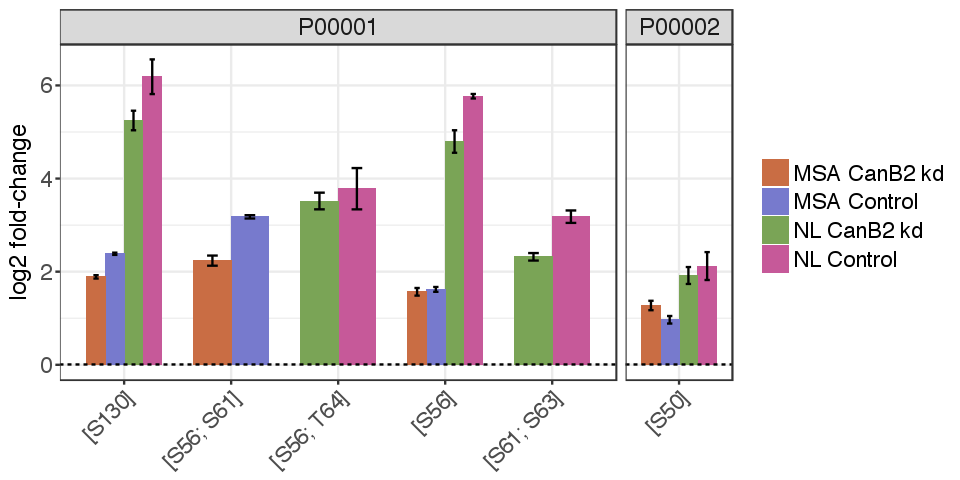

In [182]:
options(repr.plot.width = 8, repr.plot.height = 4)
# pdf("manuscript/Figures/Figure_S3.pdf", width = 8, height = 4)
ggplot(spikeIn, aes(mods, FC, fill = ID)) + 
    geom_bar(position=position_dodge(), stat="identity", width = 0.7) + 
    geom_errorbar(aes(ymin=FC-se, ymax=FC+se), width=.2, position=position_dodge(.7)) +
    labs(y = "log2 fold-change") +
    geom_hline(yintercept = 0, linetype = "dashed") +
    facet_grid(.~Protein.Group.Accessions, space = "free", scale = "free") +
    theme_bw() +
    theme(axis.text.y = element_text(size = 13), axis.text.x=element_text(size = 13, angle = 45, hjust = 1), axis.title.y=element_text(size = 14), axis.title.x=element_blank(), legend.text = element_text(size = 13), legend.title = element_blank(), strip.text = element_text(face = "bold", size = 14)) +
    scale_fill_manual(values = c("#c96d44","#777acd","#7aa456","#c65999"))
# dev.off()